# REPERTOIRE

In [1]:
# C:\Users\dieud\Documents\OPENCLASSROOMS\FORMATION_DATA_SCIENTIST\PROJETS_DS_OCR\PROJET7\OCR_Projet7
# PROJET5_DATA_SCIENTIST_OCR
# Changement du repertoire: A ne plus changer.
import os
os.chdir('C://Users//dieud//Documents//OPENCLASSROOMS//FORMATION_DATA_SCIENTIST//PROJETS_DS_OCR//PROJET7//OCR_Projet7')

# Implémentez un modèle de scoring
## Partie 2 : Modélisation

### 1 - Mise en place de l'environnement de travail

#### 1.1 Librairies

In [2]:
# General
# File system management
import os
import sys

# Visualisation
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import pandas as pd
import seaborn as sns

import math
from termcolor import colored
import time
import re

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score 
from sklearn.metrics import classification_report, confusion_matrix, roc_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler 


import pickle
from urllib.parse import urlparse

import mlflow
import mlflow.sklearn
import mlflow.pyfunc

import joblib
from collections import Counter
import shap
#from tqdm import tqdm
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder,StandardScaler
from termcolor import colored


%matplotlib inline

print("Setup complete.")

pd.set_option('display.max_columns', 125)
pd.set_option('display.max_row', 250)
pd.set_option('display.max_colwidth', 200)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


Setup complete.


In [3]:
# Versions
print('Version des librairies utilisées :')


#print('Matplotlib            : ' + mpl.__version__)
#print('Missingno             : ' + msno.__version__)
print('NumPy                 : ' + np.version.full_version)
print('Pandas                : ' + pd.__version__)
print('Python                : ' + sys.version)
print('Seaborn               : ' + sns.__version__)
print('Shap                  : ' + shap.__version__)
#print('Sklearn               : ' + sklearn.__version__ )

Version des librairies utilisées :
NumPy                 : 1.24.3
Pandas                : 1.5.3
Python                : 3.10.11 | packaged by Anaconda, Inc. | (main, Apr 20 2023, 18:56:50) [MSC v.1916 64 bit (AMD64)]
Seaborn               : 0.12.2
Shap                  : 0.42.1


In [12]:

!

'list' n'est pas reconnu en tant que commande interne
ou externe, un programme ex‚cutable ou un fichier de commandes.


#### 1.2 Paramètres

In [4]:
# Format & option
sns.set(rc={"figure.figsize": (16, 9)})
pd.options.display.max_columns = 150

# Style use
sns.set_style("darkgrid")
plt.style.use("ggplot")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
%matplotlib inline

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

In [5]:
#permet de mesurer le temps d'exécution des cellules lors de l'exécution
#!pip install ipython-autotime
%load_ext autotime

time: 0 ns (started: 2023-11-18 04:21:05 +01:00)


### 2 - Réflexion + fonctions

Dans ce notebook, je vais tout d'abord mettre en place un modèle de régression comme base puis une comparaison d'algorithmes de classification, déterminer celui qui sera le plus adapté à notre problématique (en prenant en compte le fait qu'il y ait un déséquilibre de TARGET) tout en montrant l'importance des features puis séléctionner les features pertinentes pour les visualisations sur notre dashboard.

L'objectif de ce projet est d'utiliser les données historiques des demandes de prêt pour prédire si un demandeur sera en mesure ou non de rembourser un prêt. "Il s'agit d'une classification supervisée".

apprentissage superviser : Les étiquettes sont incluses dans les données d'apprentissage et l'objectif est de former un modèle pour apprendre à prédire les étiquettes à partir des caractéristiques.
Classification : L'étiquette est une variable binaire, 0 (remboursera le prêt à temps), 1 (aura des difficultés à rembourser le prêt)".




Il y a beaucoup plus de prêts remboursés à temps que de prêts non remboursés. 

Une fois que nous entrons dans des modèles d'apprentissage automatique plus sophistiqués, nous pouvons pondérer les classes par leur représentation dans les données pour refléter ce déséquilibre.


#### 2.1 Reflexion

**Métrique adaptée au problème de la banque:**

La banque cherche les personnes ne pouvant rembourser un prêt et lorsque ce but est atteint l'évènement est positif. Le défaut de remboursement sera donc considéré comme l'évènement positif. positif = 1.

>TP (True Positives) : les cas où la prédiction est positive, et où la valeur réelle est effectivement positive.  <font color='red'>LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET</font>

>TN (True Negatives) : les cas où la prédiction est négative, et où la valeur réelle est effectivement négative. <font color='red'>LE PRET EST ACCORDE ET LE CLIENT PEUT REMBOURSER LE PRET</font> 

>FP (False Positive) : les cas où la prédiction est positive, mais où la valeur réelle est négative.  <font color='red'>LE PRET N'EST PAS ACCORDE MAIS LE CLIENT PEUT REMBOURSE LE PRET</font>

>FN (False Negative) : les cas où la prédiction est négative, mais où la valeur réelle est positive. <font color='red'>LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET</font> 

Une banque cherche à ne pas accorder de prêt à des clients qui ne peuvent pas le rembourser (TP à maximiser). La banque ne veut pas accorder un prêt à un client qui ne peut pas le rembourser (FN à minimiser). La banque fait un déficit si elle n'accorde pas de prêt à des clients qui peuvent rembourser le prêt.


**Les algorithmes sont comparés par les métriques suivantes :** 
* Accuracy_score : le ratio entre le nombre total de prédictions correctes et le nombre total de prédictions (c'est la justesse de la prédiction).
* Precision : Le ratio entre les vrais positifs et tous les positifs
* Recall : La moyenne harmonique de Precision et du Recall. Un bon score F1 indique une bonne Precision et une bonne valeur de Recall
* F1_score : Synthèse de Precision et Recall
* AUC : Aire sous la courbe ROC = mesure de la capacité d'un classifieur à distinguer les classes. Plus l'AUC est élevée, plus la performance du modèle à distinguer les classes positives et négatives est bonne.
* Matrice de confusion
* ROC Curve



maximiser : AUC, TP, F1, recall


minimiser : FN


**Définition d'une métrique "métier"**

Il faut créer une métrique pertinente concernant notre problématique pour comparer nos algorithmes. Une société de crédit cherche à "maximiser" ses gains. 
* Accorder un crédit à quelqu'un ne pouvant pas le rembourser par la suite (FN) est synonyme de perte pour l'entreprise
* Accorder un crédit à un client qui le rembousera par la suite (TN) est un gain.
* Ne pas accorder le prêt et que le client ne peut pas rembourser (TP) n'est ni une perte, ni un gain. 
* Ne pas accorder le prêt mais que le client pouvait rembourser (FP) est une perte de client donc d'argent.

On va donc créer un score en pondérant les différents cas possibles qui sera normalisé entre 0 et 1 par une normalisation min-max feature scalling avec : 

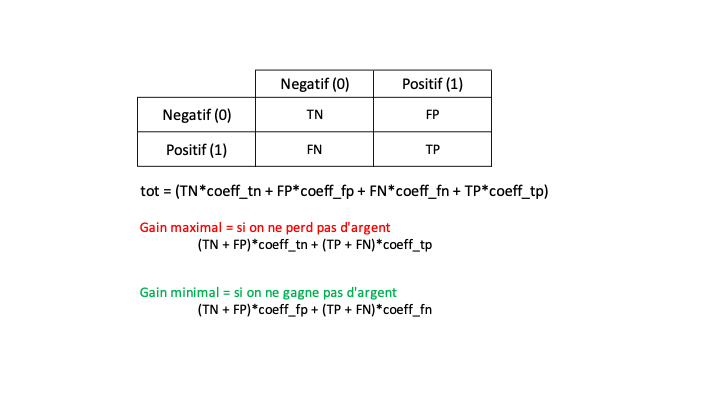

puis gain = (tot-gain_min) / (gain_max-gain_min)


Exemple de coefficients possibles en respectant la métrique métier :
* FN ==> perte d'argent pour la banque ==> 10 
* TP ==> refus de prêt ==> 0
* TN ==> prêt accordé, gain d'argent pour la banque ==> 0
* FP ==> client perdu, perte d'argent pour la banque ==> 1

La courbe ROC (Reciever Operating Characteristic) représente le taux de vrais positifs par rapport au taux de faux positifs.

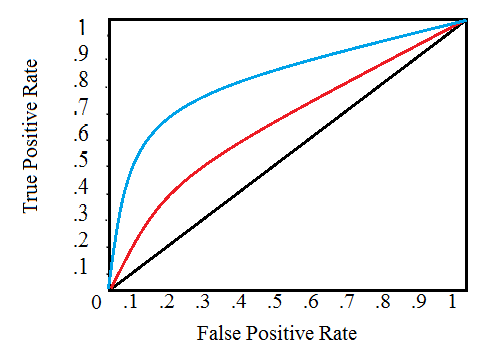

Une seule ligne sur le graphique indique la courbe pour un seul modèle, et le déplacement le long d'une ligne indique le changement du seuil utilisé pour classer une instance positive. Le seuil commence à 0 dans la partie supérieure droite et va jusqu'à 1 dans la partie inférieure gauche. Une courbe qui se trouve à gauche et au-dessus d'une autre courbe indique un meilleur modèle. Par exemple, le modèle bleu est meilleur que le modèle rouge, qui est meilleur que la ligne diagonale noire qui indique un modèle de supposition aléatoire naïve.

AUC :  Il s'agit simplement de l'aire sous la courbe ROC. (C'est l'intégrale de la courbe.) Cette métrique est comprise entre 0 et 1, un meilleur modèle obtenant un score plus élevé. Un modèle qui se contente de deviner au hasard aura une AUC ROC de 0,5. l'AUC est une mesure de la probabilité pour que le modèle classe un exemple positif aléatoire au-dessus d'un exemple négatif aléatoire. 

#### 2.2 Fonctions

In [6]:
# ne pas oublier de lancer le serveure local sur git bash "mlflow server": mlflow ui ------------->à lancer sur git bash.
# Initialisation de MLflow pour enregistrer les métriques
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment('Classification_P7 Models')

2023/11/18 04:22:36 INFO mlflow.tracking.fluent: Experiment with name 'Classification_P7 Models' does not exist. Creating a new experiment.


<Experiment: artifact_location='mlflow-artifacts:/166530598409754275', creation_time=1700277756122, experiment_id='166530598409754275', last_update_time=1700277756122, lifecycle_stage='active', name='Classification_P7 Models', tags={}>

time: 187 ms (started: 2023-11-18 04:22:35 +01:00)


In [7]:
def classification(best_param, X_train, y_train, X_test, y_test, algo_name, file_name=None):
    """
    Fonction pour évaluer la performance d'un modèle de classification donné sur les données de test.

    Arguments :
    best_param : Le modèle d'algorithme de classification avec les meilleurs hyperparamètres.
    X_train : Les données d'entraînement (caractéristiques).
    y_train : Les étiquettes d'entraînement (variable cible).
    X_test : Les données de test (caractéristiques).
    y_test : Les étiquettes de test (variable cible).
    algo_name : Le nom de l'algorithme de classification utilisé (pour l'affichage).
    file_name : Le nom du fichier dans lequel sauvegarder le modèle entraîné (optionnel).

    Retour :
    model : Le modèle entraîné avec les meilleurs hyperparamètres.
    accuracy : L'accuracy score du modèle sur les données de test.
    precision : Le score de précision du modèle sur les données de test.
    recall : Le score recall du modèle sur les données de test.
    f1 : Le score f1 du modèle sur les données de test.
    AUC : L'AUC (Area Under the Curve) du ROC du modèle sur les données de test.
    prediction : Les prédictions du modèle sur les données de test.
    probability : Les probabilités de classification du modèle sur les données de test.
    execution_time : Le temps d'exécution pour entraîner le modèle.
    prediction_time : Le temps d'exécution pour faire les prédictions.
    resume_prediction_class : Un DataFrame contenant les étiquettes réelles et prédites pour les données de test.
    probability_positive_class : Un DataFrame contenant les probabilités de classification positives pour les données de test.
    """
    # Impression en couleur pour indiquer le début de l'exécution
    print(colored("Exécution \n ", 'red'))

    # Initialisation du compteur de temps
    start_time = time.time()

    # Entraînement du modèle avec les meilleurs paramètres
    model = best_param.fit(X_train, y_train)

    # Calcul du temps d'exécution pour l'entraînement du modèle
    execution_time = (time.time() - start_time)

    # Sauvegarde du modèle si un nom de fichier est fourni
    if file_name is None:
        pass
    else:
        filename = file_name
        pickle.dump(model, open(filename, 'wb'))

    # Initialisation du compteur de temps pour les prédictions
    start_time = time.time()

    # Prédiction sur l'ensemble de test
    prediction = best_param.predict(X_test)

    # Calcul du temps d'exécution pour les prédictions
    prediction_time = (time.time() - start_time)

    #prediction de probabilité d'appartenance à 0 et 1
    probability = best_param.predict_proba(X_test)
    probability_positive = probability[:, 1]

    # Création de DataFrames pour les étiquettes réelles et prédites ainsi que les probabilités positives
    resume_prediction_class = pd.DataFrame({'cat_reel': y_test, 'cat_predit': prediction}).reset_index()
    probability_positive_class = pd.DataFrame({'SK_ID_CURR': X_test.index, 'positive_probability': probability_positive})

    # Impression des probabilités positives pour les échantillons de l'ensemble de test
    print(probability_positive_class)
    print(colored("Qualité de la classification \n \n ", 'red'))

    # Calcul et affichage des métriques de qualité de classification
    accuracy = accuracy_score(y_test, prediction)
    print(colored(f'L\'accuracy score est de {accuracy} pour la méthode {algo_name}.\n \n ', 'blue'))

    precision = precision_score(y_test, prediction, average='binary')
    print(colored(f'Le score de précision est de {precision} pour la méthode {algo_name}.\n \n ', 'blue'))

    recall = recall_score(y_test, prediction, average='binary')
    print(colored(f'Le score recall est de {recall} pour la méthode {algo_name}.\n \n ', 'blue'))

    f1 = f1_score(y_test, prediction, average='binary')
    print(colored(f'Le score f1 est de {f1} pour la méthode {algo_name}.\n \n ', 'blue'))

    AUC = roc_auc_score(y_test, probability[:, 1])  # probabilité de ne pas rembourser le prêt donc d'être étiqueté comme 1
    print(colored(f'Le score AUC est de {AUC} pour la méthode {algo_name}.\n \n ', 'blue'))

    with mlflow.start_run(run_name='classification/' + algo_name) as run:
        mlflow.log_metric('accuracy', accuracy)
        mlflow.log_metric('precision', precision)
        mlflow.log_metric('recall', recall)
        mlflow.log_metric('f1', f1)
        mlflow.log_metric('AUC', AUC)
        mlflow.log_metric('execution_time', execution_time)
        mlflow.log_metric('prediction_time', prediction_time)

        # Intégration avec MLflow - enregistrement du modèle
        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model, algo_name, registered_model_name="CreditModels")
        else:
            mlflow.sklearn.log_model(model, algo_name)
            
    # Retourne le modèle entraîné, les métriques et les prédictions pour une utilisation ultérieure si nécessaire
    return model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class

time: 15 ms (started: 2023-11-18 04:22:37 +01:00)


In [8]:
def matrix_TN_FN(y_test, y_prediction):

    '''Cette fonction calcule les éléments d'une matrice de confusion
      à partir des valeurs réelles (y_test) et des valeurs prédites (y_prediction).
    '''

    # Création de la matrice de confusion avec des colonnes pour les prédictions négatives et positives,
    # et des lignes pour les vrais négatifs et les vrais positifs.
    df_matrice_confusion = pd.DataFrame(columns=['Predicted Negative (0)', 'Predicted Positive (1)'],
                                        index=['Real Negative (0)', 'Real Positive (1)'])

    # Création d'un DataFrame de comparaison avec les valeurs réelles et les valeurs prédites côte à côte.
    df_pred_compare = pd.concat([pd.Series(y_test.reset_index(drop=True)), pd.Series(y_prediction)], axis=1)
    df_pred_compare.columns = ['Real category', 'Prediction']

    # Masque pour les vrais positifs, les vrais négatifs, les faux positifs et les faux négatifs.
    mask_real_pos = (df_pred_compare['Real category'] == 1)
    mask_pred_pos = (df_pred_compare['Prediction'] == 1)
    mask_real_neg = (df_pred_compare['Real category'] == 0)
    mask_pred_neg = (df_pred_compare['Prediction'] == 0)

    # Calcul du nombre de vrais négatifs (TN) et de faux négatifs (FN).
    true_negative = df_pred_compare[mask_real_neg & mask_pred_neg].shape[0]
    false_negative = df_pred_compare[mask_real_pos & mask_pred_neg].shape[0]

    # Calcul du nombre de faux positifs (FP) et de vrais positifs (TP).
    false_positive = df_pred_compare[mask_real_neg & mask_pred_pos].shape[0]
    true_positive = df_pred_compare[mask_real_pos & mask_pred_pos].shape[0]

    # Remplissage de la matrice de confusion avec les valeurs calculées.
    df_matrice_confusion['Predicted Negative (0)'] = [f"{true_negative} (TN)", f"{false_negative} (FN)"]
    df_matrice_confusion['Predicted Positive (1)'] = [f"{false_positive} (FP)", f"{true_positive} (TP)"]

    return df_matrice_confusion

time: 0 ns (started: 2023-11-18 04:22:40 +01:00)


In [9]:
def cf_matrix_roc_auc(y_true, y_pred, y_pred_proba, size):
    '''Cette fonction affiche la matrice de confusion et la courbe ROC en fonction des vraies valeurs (y_true),
    des valeurs prédites (y_pred), des probabilités prédites (y_pred_proba) et de la taille de la figure (size).
    '''

    # Crée une nouvelle figure avec la taille spécifiée.
    fig = plt.figure(figsize=size)

    # Ajoute un subplot pour la matrice de confusion.
    ax1 = fig.add_subplot(221)
    ax1.title.set_text('Confusion Matrix')

    # Calcule la matrice de confusion.
    cf_matrix = confusion_matrix(y_true, y_pred)

    # Récupère les valeurs TN, FP, FN et TP à partir de la matrice de confusion.
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0, 1]).ravel()

    # Noms des groupes pour les annotations.    
    group_names = ['True Neg (TN)', 'False Pos (FP)', 'False Neg (FN)', 'True Pos (TP)']

    # Formate les valeurs pour les annotations.
    group_counts = [f"{value :0.0f}" for value in cf_matrix.flatten()]
    group_percentages = [f"{value:.2%}" for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    # Prépare les annotations avec les noms, les comptes et les pourcentages.
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Crée une heatmap avec les annotations.
    sns.heatmap(cf_matrix, annot=labels, fmt="", cmap='RdPu')

    # Paramètres d'affichage pour l'axe des x.
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=False, bottom=False, top=False, labeltop=True)

    # Ajoute un subplot pour la courbe ROC.
    ax2 = fig.add_subplot(222)
    ax2.title.set_text('ROC Curve')

    # Calcule les taux de faux positifs et de vrais positifs pour la courbe ROC.
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba[:, 1])  # Pour la courbe ROC, utilisation de la probabilité d'être 1.

    # Trace la courbe ROC avec l'aire sous la courbe (AUC).
    plt.plot(fpr, tpr, color='pink', linewidth=5, label='AUC = %0.4f' % roc_auc)
    
    # Trace la droite en pointillés (ligne de référence).
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()

    # Affiche la figure avec la matrice de confusion et la courbe ROC.
    plt.show()

    # Affiche les valeurs TN, FP, FN et TP.
    print('True negative = ', tn)
    print('False positive = ', fp)
    print('False negative = ', fn)
    print('True positive = ', tp)

    # Renvoie les valeurs TN, FP, FN et TP.
    return tn, fp, fn, tp

time: 0 ns (started: 2023-11-18 04:22:42 +01:00)


In [10]:
def score_banq(tn, fp, fn, tp, coeff_tn, coeff_fp, coeff_fn, coeff_tp):

    total = (coeff_tn*tn + coeff_fp*fp + coeff_fn*fn + coeff_tp*tp)

    #calcul du gain maximal que peut avoir la banque quand il n'y a pas de perte d'argent. C'est à dire que le modèle ne détecte que TN et les TP.
    max_gain = (tn + fp)*coeff_tn + (tp + fn)*coeff_tp

    #calcul du gain minimal (perte) que peut avoir la banque quand il n'y a pas de gain d'argent. C'est à dire que le modèle ne détecte que FN et les FP.
    min_gain = (tn + fp)*coeff_fp + (tp + fn)*coeff_fn

    #normalisation min-max feature scalling : score= (tot-min)/(max-min) https://en.wikipedia.org/wiki/Normalization_(statistics) 
    score = (total - min_gain)/(max_gain - min_gain)

    return score

time: 0 ns (started: 2023-11-18 04:22:44 +01:00)


### 3 Dernier Traitement des Datasets.

In [11]:
# Importation de données.
dfs = pd.read_csv('dfs.csv', index_col=0)
# Visualisation du train dataset 
dfs.head()

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      0      100002       1            0             0                0   
1      1      100003       0            1             0                1   
2      2      100004       0            0             1                0   
3      3      100006       0            1             0                0   
4      4      100007       0            0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             0          202500.0    406597.5      24700.5         351000.0   
1             0          270000.0   1293502.5      35698.5        1129500.0   
2             0           67500.0    135000.0       6750.0         135000.0   
3             0          135000.0    312682.5      29686.5         297000.0   
4             0          121500.0    513000.0      21865.5         513000.0   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637            -3648.0   
1                    0.003541      -16765          -1188            -1186.0   
2                    0.010032      -19046           -225            -4260.0   
3                    0.008019      -19005          -3039            -9833.0   
4                    0.028663      -19932          -3038            -4311.0   

   DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -2120           1               1                0   
1             -291           1               1                0   
2            -2531           1               1                1   
3            -2437           1               1                0   
4            -3458           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              1.0   
1                 1           1           0              2.0   
2                 1           1           0              1.0   
3                 1           0           0              2.0   
4                 1           0           0              1.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     2                            2                       10   
1                     1                            1                       11   
2                     2                            2                        9   
3                     2                            2                       17   
4                     2                            2                       11   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0      0.083037   
1                       0                        0      0.311267   
2                       0                        0           NaN   
3                       0                        0           NaN   
4                       1                        1           NaN   

   EXT_SOURCE_2  EXT_SOURCE_3  YEARS_BEGINEXPLUATATION_AVG  ENTRANCES_AVG  \
0      0.262949      0.139376                       0.9722         0.0690   
1      0.622246           NaN             

time: 8.53 s (started: 2023-11-18 04:22:53 +01:00)


In [12]:
df = dfs.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df

index  SK_ID_CURR  TARGET  CODE_GENDER  FLAG_OWN_CAR  \
0            0      100002       1            0             0   
1            1      100003       0            1             0   
2            2      100004       0            0             1   
3            3      100006       0            1             0   
4            4      100007       0            0             0   
...        ...         ...     ...          ...           ...   
307504  307504      456248       0            1             0   
307506  307506      456251       0            0             0   
307508  307508      456253       0            1             0   
307509  307509      456254       1            1             0   
307510  307510      456255       0            1             0   

        FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  \
0                     0             0          202500.0    406597.5   
1                     1             0          270000.0   1293502.5   
2                     0             0           67500.0    135000.0   
3                     0             0          135000.0    312682.5   
4                     0             0          121500.0    513000.0   
...                 ...           ...               ...         ...   
307504                0             0          153000.0    331920.0   
307506                1             0          157500.0    254700.0   
307508                0             0          153000.0    677664.0   
307509                0             0          171000.0    370107.0   
307510                1             0          157500.0    675000.0   

        AMT_ANNUITY  AMT_GOODS_PRICE  REGION_POPULATION_RELATIVE  DAYS_BIRTH  \
0           24700.5         351000.0                    0.018801       -9461   
1           35698.5        1129500.0                    0.003541      -16765   
2            6750.0         135000.0                    0.010032      -19046   
3           29686.5         297000.0                    0.008019      -19005   
4           21865.5         513000.0                    0.028663      -19932   
...             ...              ...                         ...         ...   
307504      16096.5         225000.0                    0.022625      -16705   
307506      27558.0         225000.0                    0.032561       -9327   
307508      29979.0         585000.0                    0.005002      -14966   
307509      20205.0         319500.0                    0.005313      -11961   
307510      49117.5         675000.0                    0.046220      -16856   

        DAYS_EMPLOYED  DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  \
0                -637            -3648.0            -2120           1   
1               -1188            -1186.0             -291           1   
2                -225            -4260.0            -2531           1   
3               -3039            -9833.0            -2437           1   
4               -3038            -4311.0            -3458           1   
...               ...                ...              ...         ...   
307504          -7258            -9798.0             -259           1   
307506           -236            -8456.0            -1982           1   
307508          -7921            -6737.0            -5150           1   
307509          -4786            -2562.0             -931           1   
307510          -1262            -5128.0             -410           1   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
0                    1                0                 1           1   
1                    1                0                 1           1   
2                    1                1                 1           1   
3                    1                0                 1           0   
4                    1                0                 1           0   
...                ...              ...               ...         ...   
307504               1    

time: 562 ms (started: 2023-11-18 04:23:18 +01:00)


In [13]:
df_ = df.drop(['index'], axis=1)

time: 140 ms (started: 2023-11-18 04:24:15 +01:00)


In [14]:
df0 = df_.set_index('SK_ID_CURR')
df0

TARGET  CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                                     
100002           1            0             0                0             0   
100003           0            1             0                1             0   
100004           0            0             1                0             0   
100006           0            1             0                0             0   
100007           0            0             0                0             0   
...            ...          ...           ...              ...           ...   
456248           0            1             0                0             0   
456251           0            0             0                1             0   
456253           0            1             0                0             0   
456254           1            1             0                0             0   
456255           0            1             0                1             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
100002              202500.0    406597.5      24700.5         351000.0   
100003              270000.0   1293502.5      35698.5        1129500.0   
100004               67500.0    135000.0       6750.0         135000.0   
100006              135000.0    312682.5      29686.5         297000.0   
100007              121500.0    513000.0      21865.5         513000.0   
...                      ...         ...          ...              ...   
456248              153000.0    331920.0      16096.5         225000.0   
456251              157500.0    254700.0      27558.0         225000.0   
456253              153000.0    677664.0      29979.0         585000.0   
456254              171000.0    370107.0      20205.0         319500.0   
456255              157500.0    675000.0      49117.5         675000.0   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
100002                        0.018801       -9461           -637   
100003                        0.003541      -16765          -1188   
100004                        0.010032      -19046           -225   
100006                        0.008019      -19005          -3039   
100007                        0.028663      -19932          -3038   
...                                ...         ...            ...   
456248                        0.022625      -16705          -7258   
456251                        0.032561       -9327           -236   
456253                        0.005002      -14966          -7921   
456254                        0.005313      -11961          -4786   
456255                        0.046220      -16856          -1262   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR                                                                   
100002                -3648.0            -2120           1               1   
100003                -1186.0             -291           1               1   
100004                -4260.0            -2531           1               1   
100006                -9833.0            -2437           1               1   
100007                -4311.0            -3458           1               1   
...                       ...              ...         ...             ...   
456248                -9798.0             -259           1               1   
456251                -8456.0            -1982           1               1   
456253                -6737.0            -5150           1               1   
456254                -2562.0             -931           1               1   
456255                -5128.0             -410           1               1   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR            

time: 875 ms (started: 2023-11-18 04:24:17 +01:00)


In [15]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252133 entries, 100002 to 456255
Columns: 520 entries, TARGET to INSTAL_COUNT
dtypes: float64(344), int64(176)
memory usage: 1002.2 MB
time: 32 ms (started: 2023-11-18 04:24:27 +01:00)


#### Séparation Des Données.

In [16]:
X = df0.loc[:, ~df0.columns.isin(['TARGET'])]
X_API = df.loc[:, df.columns != 'SK_ID_CURR']
y = df0['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
columns_int = list(X_train.select_dtypes(include=['uint8', 'int64']).columns)
columns_float = list(X_train.select_dtypes(include=['float64']).columns)

time: 2.91 s (started: 2023-11-18 04:24:33 +01:00)


In [17]:
X_API_preprocessed = X_API.copy()

time: 500 ms (started: 2023-11-18 04:24:43 +01:00)


#### Imputation Des Données.

In [18]:
from sklearn.impute import SimpleImputer

time: 0 ns (started: 2023-11-18 04:24:54 +01:00)


In [19]:
imp_most_frequent = SimpleImputer(strategy="most_frequent")
imp_most_frequent.fit(X_train[columns_int])
X_train[columns_int] = imp_most_frequent.transform(X_train[columns_int])
X_test[columns_int] = imp_most_frequent.transform(X_test[columns_int])
X_API_preprocessed[columns_int] = imp_most_frequent.transform(X_API_preprocessed[columns_int])

imp_mean = SimpleImputer(strategy="mean")
imp_mean.fit(X_train[columns_float])
X_train[columns_float] = imp_mean.transform(X_train[columns_float])
X_test[columns_float] = imp_mean.transform(X_test[columns_float])
X_API_preprocessed[columns_float] = imp_mean.transform(X_API_preprocessed[columns_float])

time: 1min 1s (started: 2023-11-18 04:25:20 +01:00)


#### Standardisation Des Données

In [20]:
from sklearn.preprocessing import LabelEncoder,StandardScaler

time: 0 ns (started: 2023-11-18 04:26:28 +01:00)


In [21]:
std_scale_X = StandardScaler().fit(X_train[columns_float])
X_train[columns_float] = std_scale_X.transform(X_train[columns_float])
X_test[columns_float] = std_scale_X.transform(X_test[columns_float])
X_API_preprocessed[columns_float] = std_scale_X.transform(X_API_preprocessed[columns_float])

time: 43.7 s (started: 2023-11-18 04:26:29 +01:00)


In [22]:
df_API = X_API_preprocessed.copy()
df_API.insert(0,'SK_ID_CURR', df['SK_ID_CURR'])

df_API.to_csv('df_API.csv', index=False)

time: 1min 46s (started: 2023-11-18 04:27:16 +01:00)


In [23]:
from termcolor import colored

time: 0 ns (started: 2023-11-18 04:29:10 +01:00)


In [24]:
# Nature des variables.

# Définition du titre
title = {"family": "Arial",
         "color":  "black",
         "weight": "bold",
         "size": 18}

# Configuration du style Seaborn
sns.set_style("whitegrid")

# Définition des couleurs pour chaque type de données
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

time: 16 ms (started: 2023-11-18 04:29:12 +01:00)


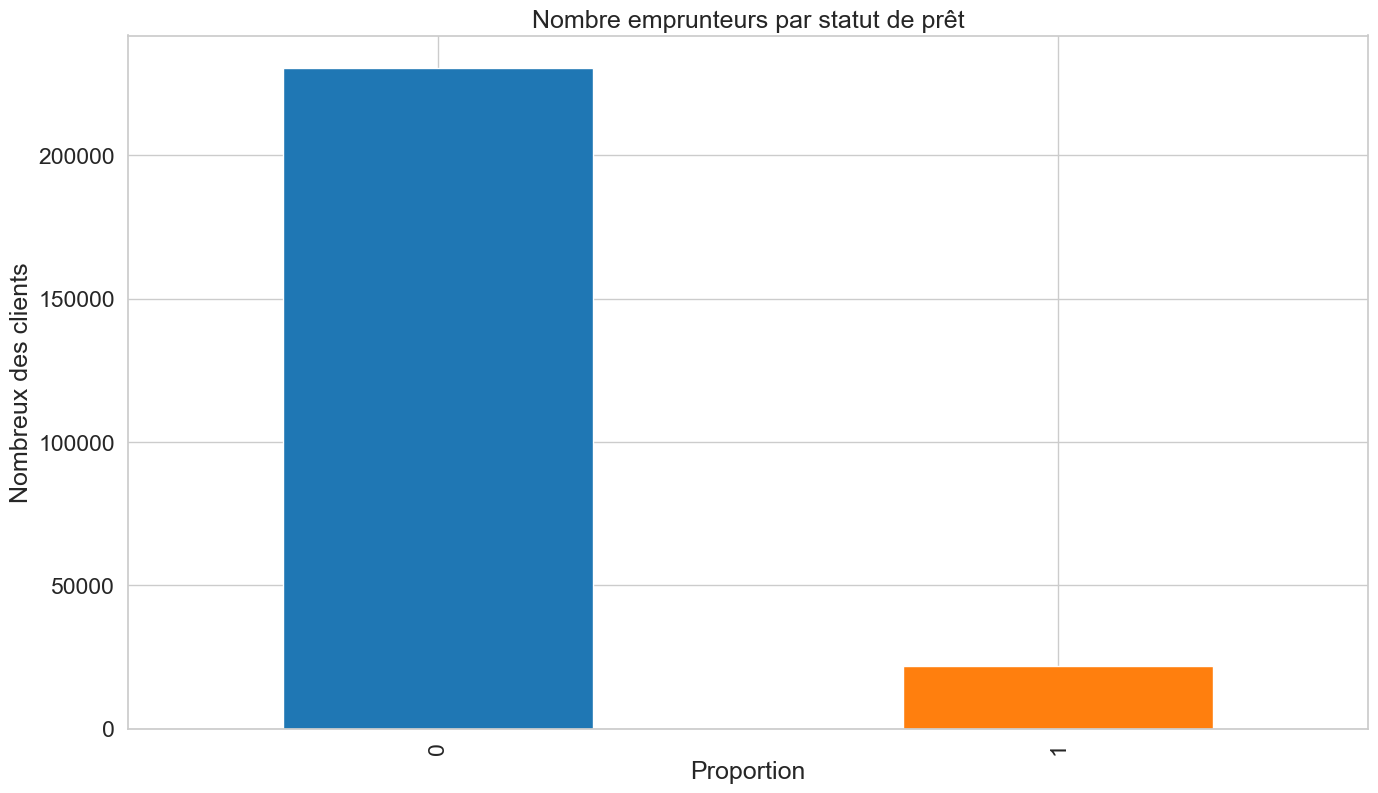

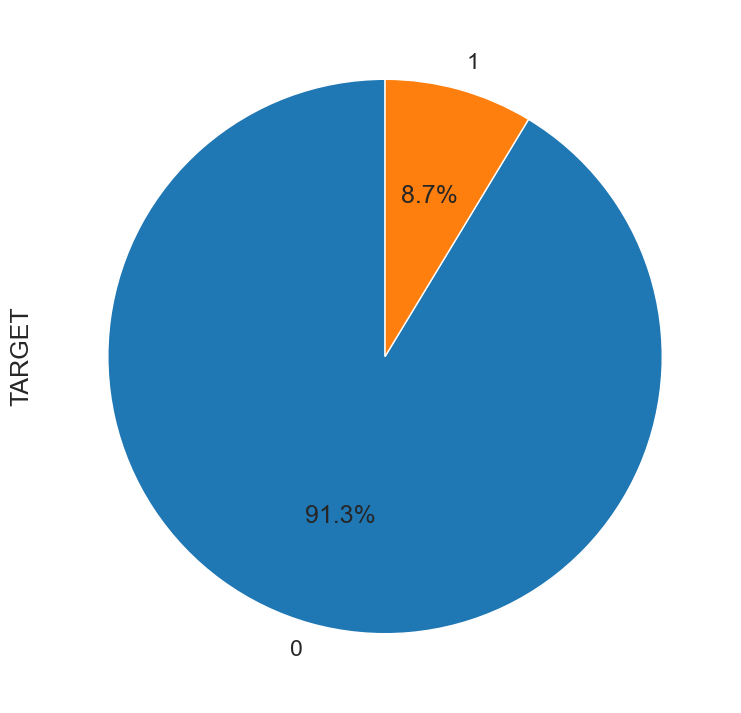

time: 656 ms (started: 2023-11-18 04:29:13 +01:00)


In [25]:
#y.replace(to_replace=[1,0], value= ['YES','NO'], inplace = True)
fig11=plt.figure()
ax11=plt.axes()
#colors = ['#6599CE','#A6CD5C']
plt.title('Nombre emprunteurs par statut de prêt')
ax11 = ax11.set(xlabel='Proportion', ylabel='Nombreux des clients')   
y.value_counts().plot.bar(color=colors)
fig12=plt.figure()
ax12=plt.axes()    
y.value_counts().plot.pie(startangle=90, autopct='%1.1f%%',colors=colors )
plt.show()

# MODELISATION

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(201706, 519)
(50427, 519)
(201706,)
(50427,)
time: 16 ms (started: 2023-11-18 04:29:23 +01:00)


### 5 - Cross Validation

In [27]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 5}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7328486760499594
time: 7min 34s (started: 2023-11-18 04:29:26 +01:00)


In [28]:
# Fixer les valeurs des hyperparamètres à tester
'''param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train, y_train, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)'''

'param_grid = {\n        \'n_estimators\' : np.arange(500, 1500, 100),\n        \'learning_rate\' : [1, 0.1, 0.01, 0.001]\n        }\n\n# Choisir un score à optimiser\nscore = \'roc_auc\'\n\n\n# define the model/ estimator\nmodel = LGBMClassifier(objective=\'binary\', random_state=42)\n\n# define the grid search\nlgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV\n\n# Optimiser ce régresseur sur le jeu d\'entraînement\nlgbm.fit(X_train, y_train, eval_metric=\'auc\')\n\n# Afficher le(s) hyperparamètre(s) optimaux\nprint("Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement (best parameters) :")\nbest_params = lgbm.best_params_\nprint(best_params)\nprint(\' \')\nprint("Meilleur(s) score sur le jeu d\'entraînement (roc_auc):")\nprint(lgbm.best_score_)'

time: 16 ms (started: 2023-11-18 04:37:14 +01:00)


Best paramètre sauvegardés car trop lent sur le GridSherchCV

* Fitting 4 folds for each of 40 candidates, totalling 160 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.01, 'n_estimators': 1400}
 
* Meilleur(s) score sur le jeu d'entraînement (roc_auc):    
0.7524705095804762
* time: 1h 1min 36s (started: 2023-07-04 16:43:34 +02:00)

### 6 - Baseline

#### 6.1 Régression logistique

 La seule modification que nous apporterons aux paramètres du modèle par défaut est de diminuer le paramètre de régularisation, C, qui contrôle le niveau d'ajustement excessif (une valeur plus faible devrait réduire l'ajustement excessif). Nous obtiendrons ainsi des résultats légèrement meilleurs que ceux du modèle LogisticRegression par défaut, mais la barre sera toujours basse pour tous les modèles futurs.

In [29]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=5,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)

time: 15 ms (started: 2023-11-18 04:37:43 +01:00)


In [30]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(best_params, X_train, y_train, X_test, y_test, "Baseline - Regression logistique", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          272844              0.006211
1          262199              0.133556
2          236291              0.164130
3          399708              0.007426
4          151614              0.028164
...           ...                   ...
50422      125398              0.027807
50423      151094              0.026171
50424      287568              0.133173
50425      214293              0.147430
50426      387840              0.045563

[50427 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.9130426160588574 pour la méthode Baseline - Regression logistique.
 
 
Le score de précision est de 0.4215686274509804 pour la méthode Baseline - Regression logistique.
 
 
Le score recall est de 0.019756489777165175 pour la méthode Baseline - Regression logistique.
 
 
Le score f1 est de 0.037744129910028526 pour la méthode Baseline - Regression logistique.
 
 
Le score AUC est de 0.7344307309505923 pour la méthode B

Successfully registered model 'CreditModels'.
2023/11/18 04:38:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 1


time: 22.6 s (started: 2023-11-18 04:37:46 +01:00)


Created version '1' of model 'CreditModels'.


Nous sommes ici dans le cas d'une banque ne souhaitant pas se tromper lors de l'accord d'un prêt. Il ne faut donc pas chercher à maximiser les métriques de Data Science (accuracy, precision, recall à maximiser) mais plus les métriques pouvant satisfaire la problématique métier (AUC à maximiser, F1 à minimiser).


In [31]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             45956 (TN)               118 (FP)
Real Positive (1)              4267 (FN)                86 (TP)

time: 31 ms (started: 2023-11-18 04:38:40 +01:00)


In [32]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7344
Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      1.00      0.95     46074
           1       0.42      0.02      0.04      4353

    accuracy                           0.91     50427
   macro avg       0.67      0.51      0.50     50427
weighted avg       0.87      0.91      0.88     50427

time: 79 ms (started: 2023-11-18 04:38:42 +01:00)


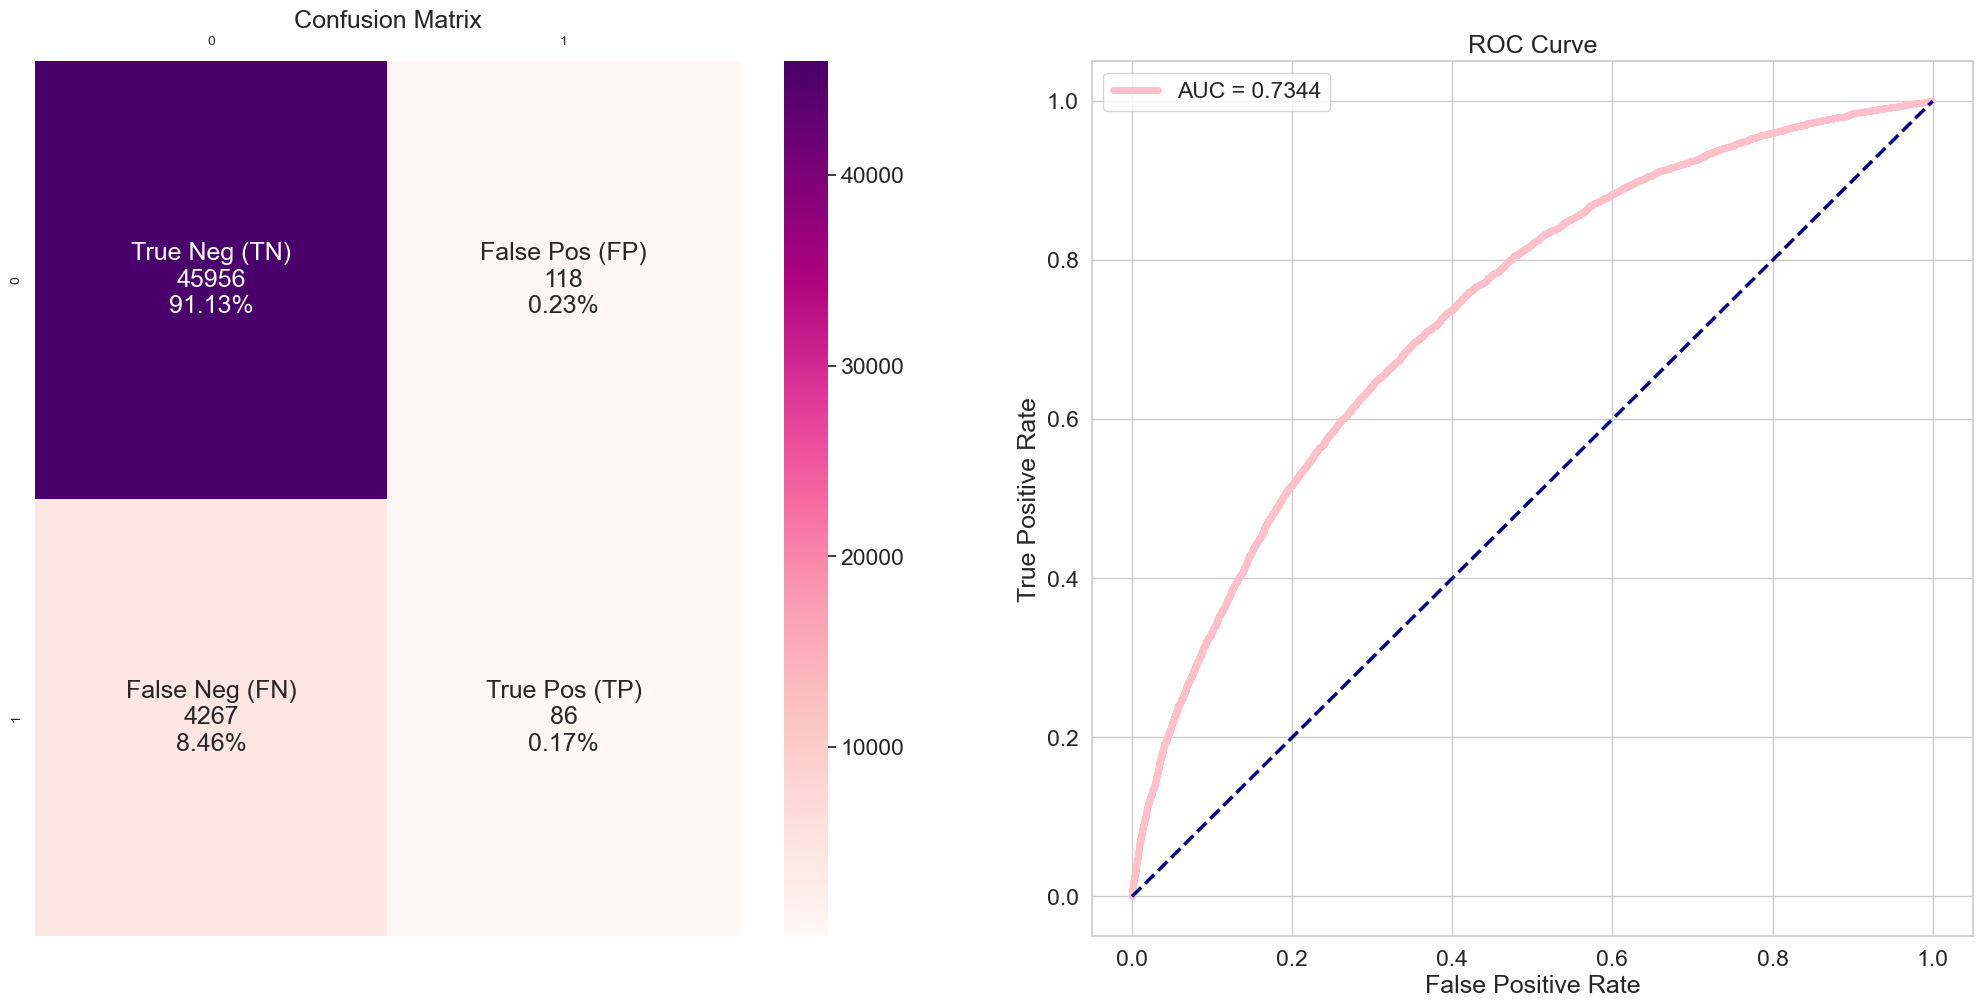

True negative =  45956
False positive =  118
False negative =  4267
True positive =  86
time: 687 ms (started: 2023-11-18 04:38:45 +01:00)


In [33]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [34]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.5224766751484309

time: 0 ns (started: 2023-11-18 04:38:48 +01:00)


Le modèle a une performance de plus de 90%. Plus de 90% de nos observations appartiennent à la catégorie 0 (non défaut de paiement), avec une exactitude (accuracy) de plus de 90% (ici 93%). Celà est caractéristique d'un déséquilibre des target. 

Pour pallier à ce déséquilibre, il faut rééquilibrer le jeu de données en faisant class_weight = balanced, de l’undersampling, en enlevant des données de la classe majoritaire, soit en faisant de l’oversampling, en rajoutant des nouvelles données dans la classe minoritaire.

In [35]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_baseline = pd.DataFrame(
        {
            "Modele": "Baseline - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[0],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_baseline

Modele  Accuracy       AUC  Recall class 1  \
0  Baseline - Regression Logistique  0.913043  0.734431        0.019756   

         F1  TP  Precision    FN  score Gain     time  
0  0.037744  86   0.421569  4267    0.522477  0.89638

time: 16 ms (started: 2023-11-18 04:38:54 +01:00)


#### 6.1 LGBMClassifier

In [36]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=1400,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)

time: 0 ns (started: 2023-11-18 04:39:02 +01:00)


In [37]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train, y_train, X_test, y_test, "Baseline - LGBMClassifier", file_name=None)

Exécution 
 
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 17482, number of negative: 184224
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.250017 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43860
[LightGBM] [Info] Number of data points in the train set: 201706, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.086671 -> initscore=-2.354981
[LightGBM] [Info] Start training from score -2.354981
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
       SK_ID_CURR  positive_probability
0          272844              0.010032
1          262199              0.108956
2          236291              0.515733
3          399708              0.012107
4          151614              0.033138
...           ...                   ...
50422      125398 

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 04:40:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 2


time: 1min 21s (started: 2023-11-18 04:39:05 +01:00)


Created version '2' of model 'CreditModels'.


In [38]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             45948 (TN)               126 (FP)
Real Positive (1)              4201 (FN)               152 (TP)

time: 16 ms (started: 2023-11-18 04:40:38 +01:00)


In [39]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7823
Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     46074
           1       0.55      0.03      0.07      4353

    accuracy                           0.91     50427
   macro avg       0.73      0.52      0.51     50427
weighted avg       0.88      0.91      0.88     50427

time: 79 ms (started: 2023-11-18 04:40:43 +01:00)


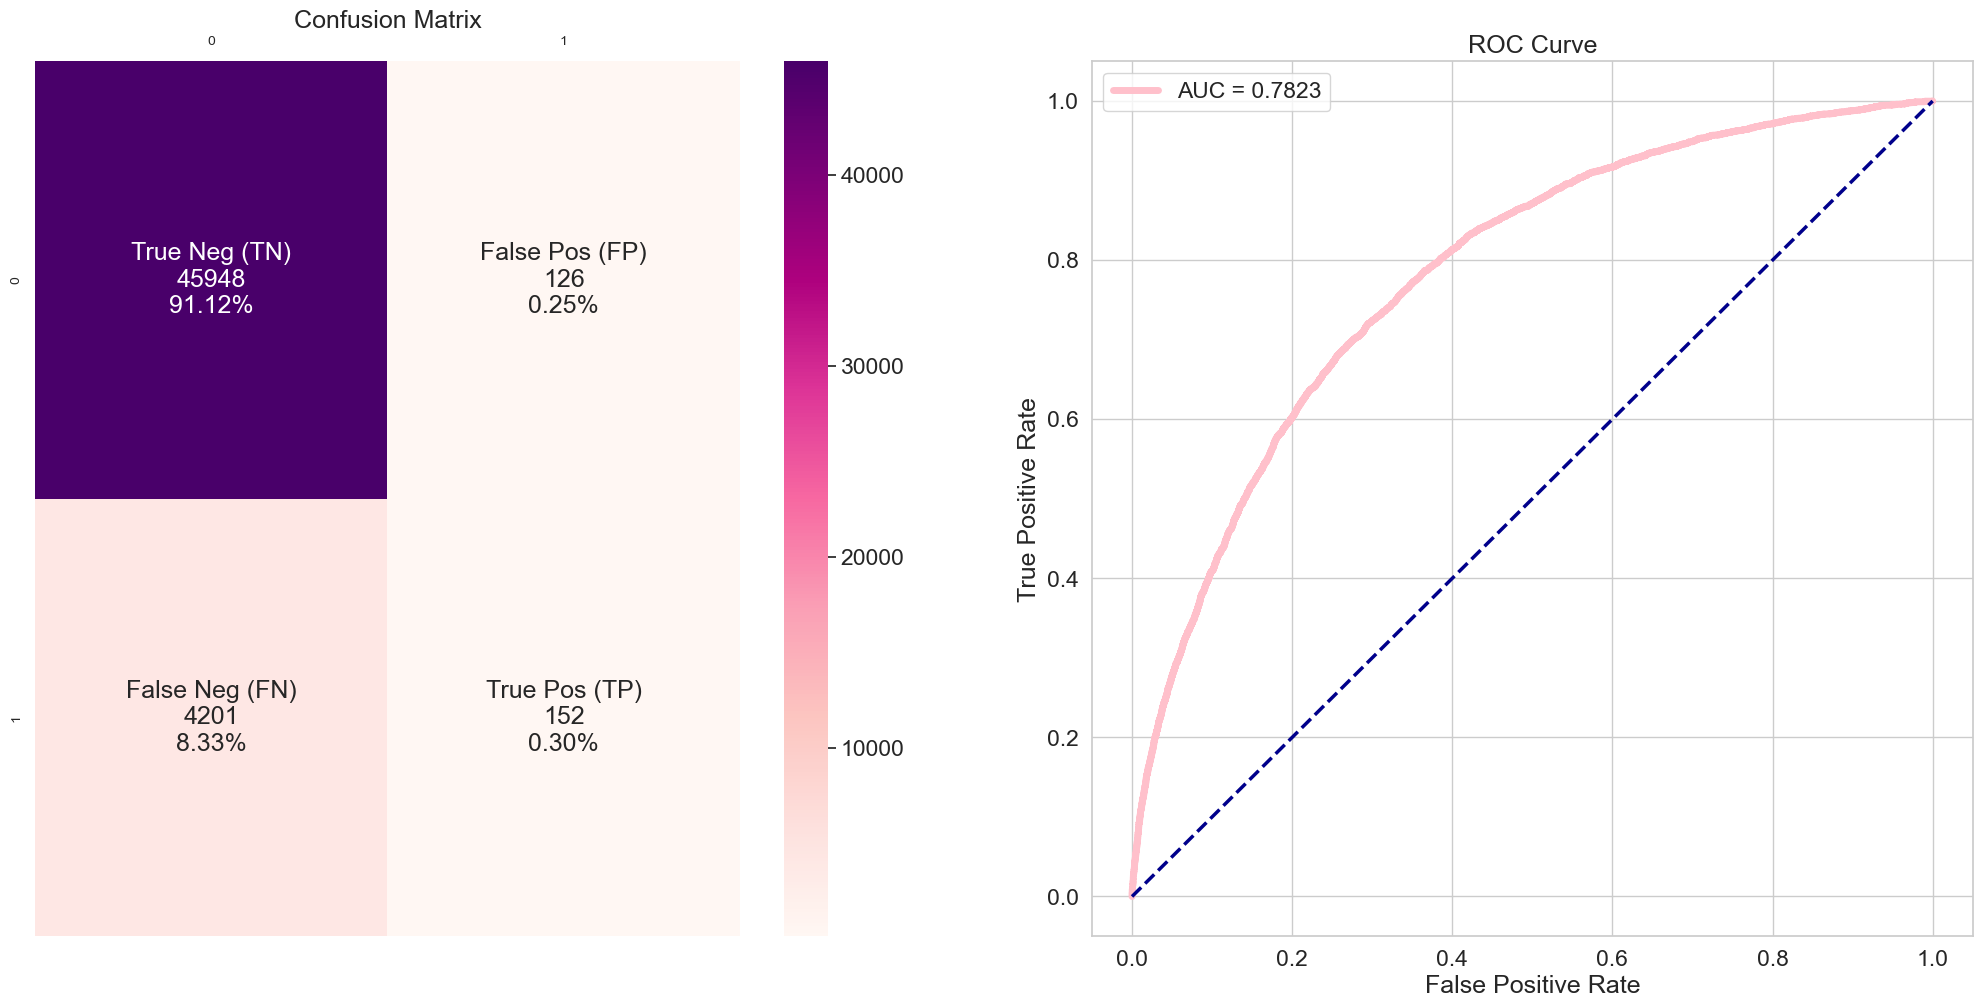

True negative =  45948
False positive =  126
False negative =  4201
True positive =  152
time: 672 ms (started: 2023-11-18 04:40:46 +01:00)


In [40]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [41]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.5297531360207134

time: 0 ns (started: 2023-11-18 04:40:50 +01:00)


In [42]:
# Ajout des métriques du modèle LGBMClassifier à la DataFrame comparison_baseline
comparison_baseline_lgbm = pd.DataFrame(
        {
            "Modele": "Baseline - LGBMClassifier",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[1],                          # Utilisation de l'index 1 pour ajouter une deuxième ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance pour les deux modèles (Régression logistique et LGBMClassifier)
comparison_baseline = pd.concat([comparison_baseline, comparison_baseline_lgbm])
comparison_baseline

Modele  Accuracy       AUC  Recall class 1  \
0  Baseline - Regression Logistique  0.913043  0.734431        0.019756   
1         Baseline - LGBMClassifier  0.914193  0.782269        0.034918   

         F1   TP  Precision    FN  score Gain      time  
0  0.037744   86   0.421569  4267    0.522477  0.896380  
1  0.065645  152   0.546763  4201    0.529753  0.873382

time: 16 ms (started: 2023-11-18 04:40:54 +01:00)


### 7 - Traitement de la classification déséquilibrée

#### 7.1 Class_weight
 avec le paramètre : class_weight=’balanced’

##### 7.1.1 Régression logistique 

In [43]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=5,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight='balanced',  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)

time: 0 ns (started: 2023-11-18 04:41:12 +01:00)


In [44]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class = classification(best_params, X_train, y_train, X_test, y_test, "Class Weight - Regression logistique", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          272844              0.053516
1          262199              0.603075
2          236291              0.765997
3          399708              0.092030
4          151614              0.154641
...           ...                   ...
50422      125398              0.312143
50423      151094              0.227644
50424      287568              0.566342
50425      214293              0.623371
50426      387840              0.382594

[50427 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6779304737541396 pour la méthode Class Weight - Regression logistique.
 
 
Le score de précision est de 0.16576698155645525 pour la méthode Class Weight - Regression logistique.
 
 
Le score recall est de 0.6772340914311968 pour la méthode Class Weight - Regression logistique.
 
 
Le score f1 est de 0.2663414193431811 pour la méthode Class Weight - Regression logistique.
 
 
Le score AUC est de 0.7441402633370954 pour

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 04:41:30 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 3


time: 14.2 s (started: 2023-11-18 04:41:16 +01:00)


Created version '3' of model 'CreditModels'.


In [45]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             31238 (TN)             14836 (FP)
Real Positive (1)              1405 (FN)              2948 (TP)

time: 16 ms (started: 2023-11-18 04:41:48 +01:00)


In [46]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7441
Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     46074
           1       0.17      0.68      0.27      4353

    accuracy                           0.68     50427
   macro avg       0.56      0.68      0.53     50427
weighted avg       0.89      0.68      0.75     50427

time: 63 ms (started: 2023-11-18 04:41:50 +01:00)


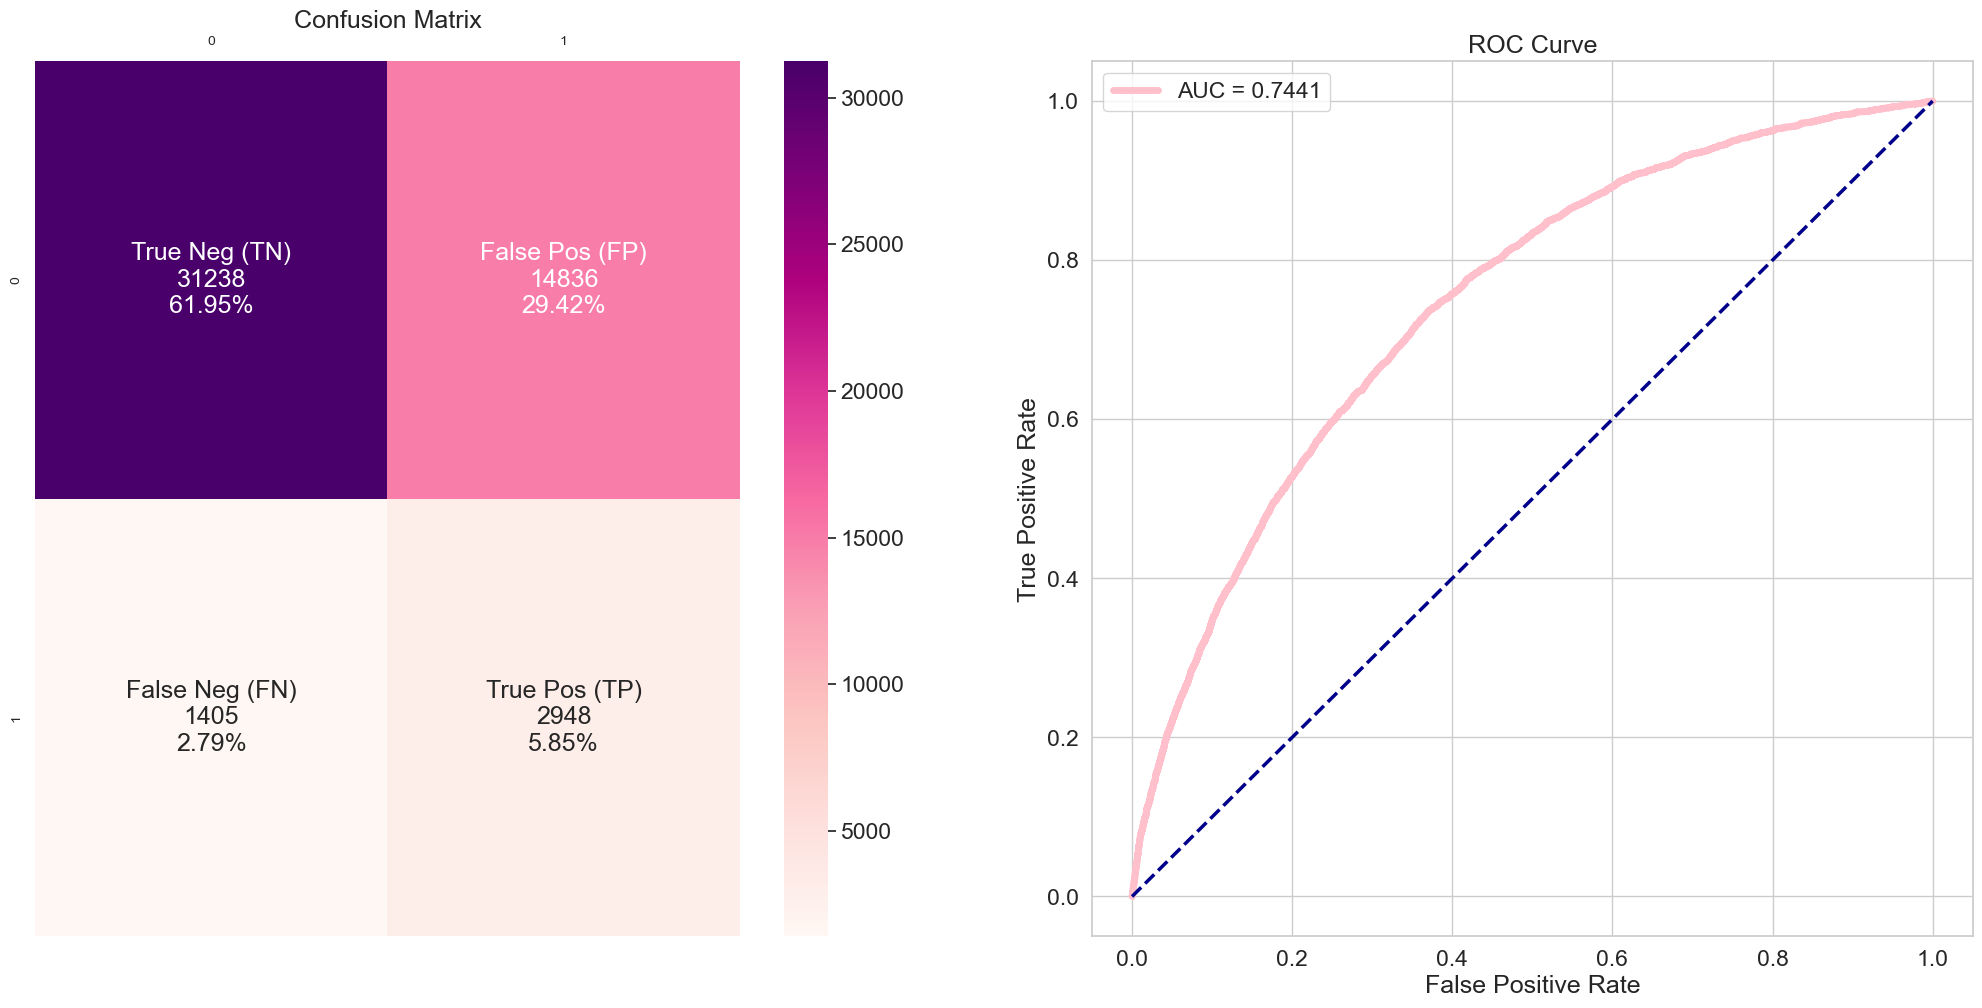

True negative =  31238
False positive =  14836
False negative =  1405
True positive =  2948
time: 563 ms (started: 2023-11-18 04:41:52 +01:00)


In [47]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [48]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.6776259988393375

time: 16 ms (started: 2023-11-18 04:41:54 +01:00)


In [49]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_class_weight_rl = pd.DataFrame(
        {
            "Modele": "Class Weight - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[2],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_baseline, comparison_class_weight_rl])
comparison_model

Modele  Accuracy       AUC  Recall class 1  \
0      Baseline - Regression Logistique  0.913043  0.734431        0.019756   
1             Baseline - LGBMClassifier  0.914193  0.782269        0.034918   
2  Class Weight - Regression Logistique  0.677930  0.744140        0.677234   

         F1    TP  Precision    FN  score Gain      time  
0  0.037744    86   0.421569  4267    0.522477  0.896380  
1  0.065645   152   0.546763  4201    0.529753  0.873382  
2  0.266341  2948   0.165767  1405    0.677626  0.094692

time: 16 ms (started: 2023-11-18 04:41:58 +01:00)


##### 7.1.2 LGBMClassifier

In [50]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=1400,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight='balanced',  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)

time: 0 ns (started: 2023-11-18 04:42:18 +01:00)


In [51]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train, y_train, X_test, y_test, "Class Weight - LGBMClassifier", file_name=None)

Exécution 
 
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 17482, number of negative: 184224
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.301094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43860
[LightGBM] [Info] Number of data points in the train set: 201706, number of used features: 484
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
       SK_ID_CURR  positive_probability
0          272844              0.051632
1          262199              0.596166
2          236291              0.873814
3          399708              0.078849
4          151614              0.259123
...           ...                   ...
50422      125398 

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 04:43:50 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 4


time: 1min 29s (started: 2023-11-18 04:42:21 +01:00)


Created version '4' of model 'CreditModels'.


In [52]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             34023 (TN)             12051 (FP)
Real Positive (1)              1385 (FN)              2968 (TP)

time: 16 ms (started: 2023-11-18 04:44:28 +01:00)


In [53]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7828
Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     46074
           1       0.20      0.68      0.31      4353

    accuracy                           0.73     50427
   macro avg       0.58      0.71      0.57     50427
weighted avg       0.89      0.73      0.79     50427

time: 78 ms (started: 2023-11-18 04:44:31 +01:00)


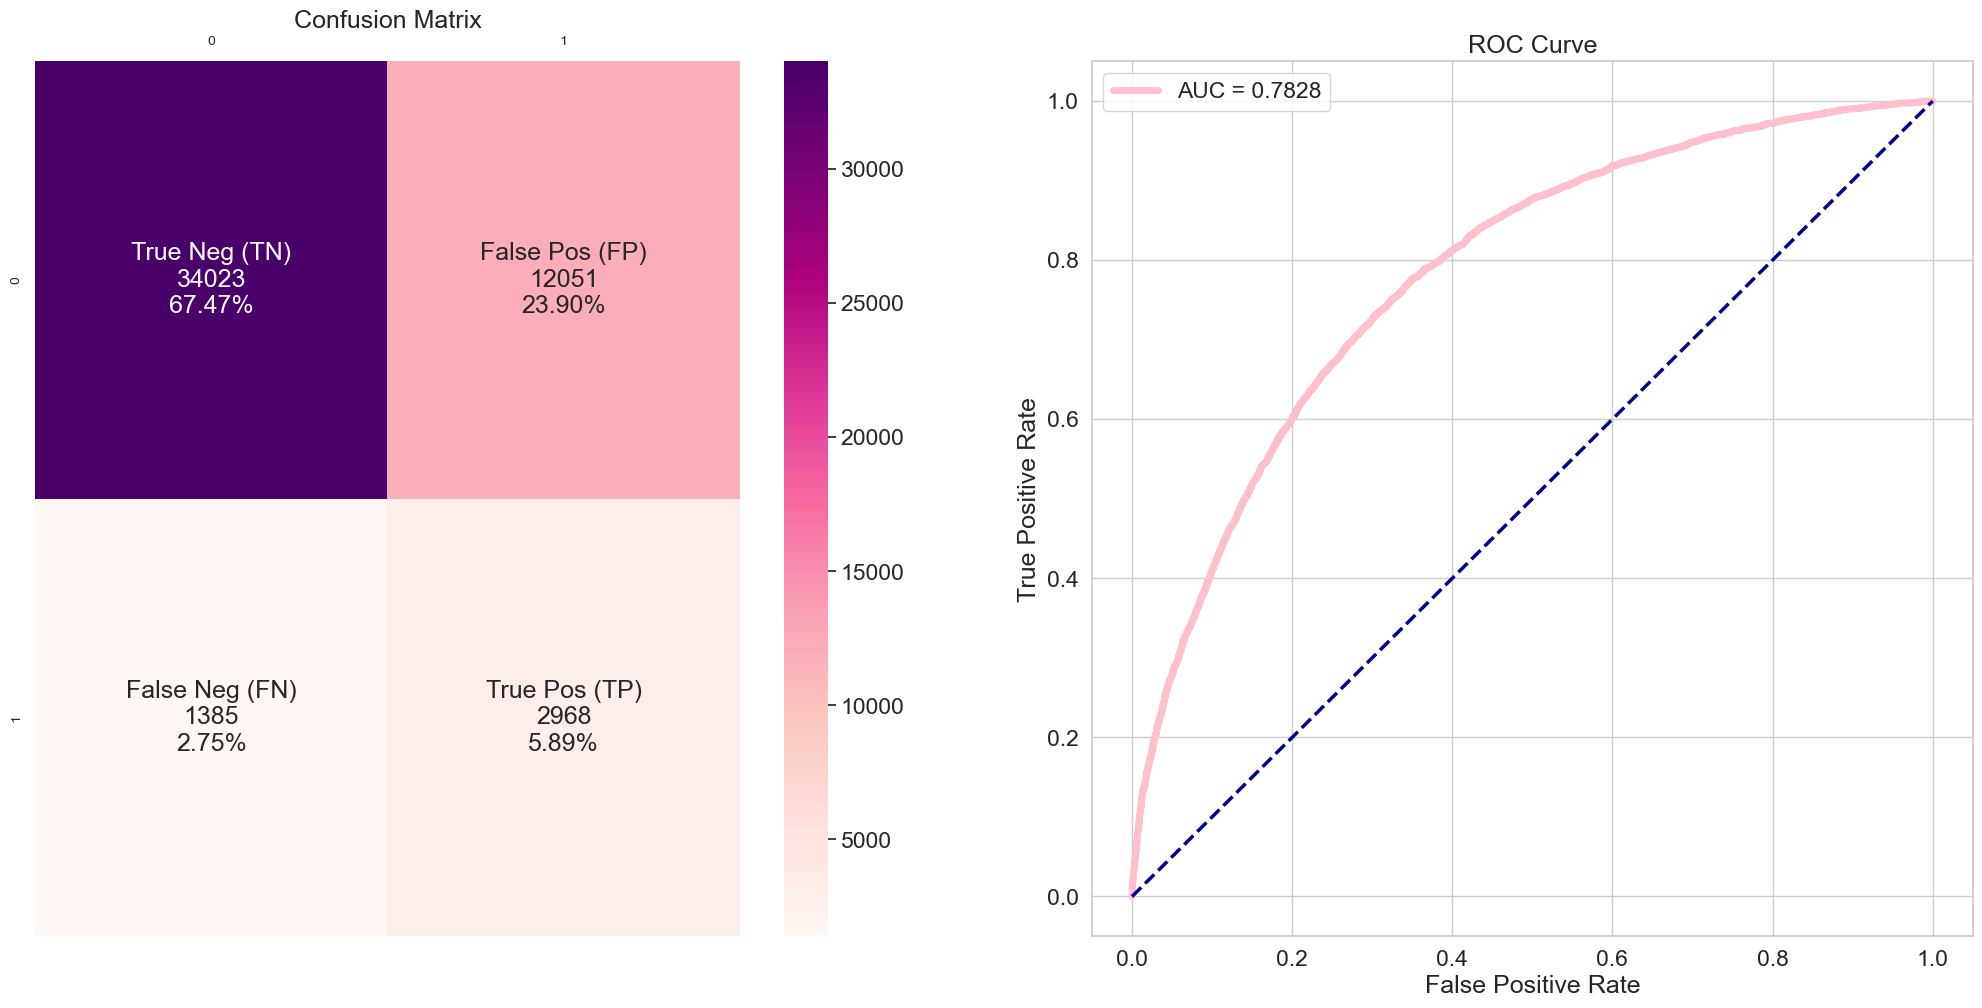

True negative =  34023
False positive =  12051
False negative =  1385
True positive =  2968
time: 531 ms (started: 2023-11-18 04:44:34 +01:00)


In [54]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [55]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.7109392437837596

time: 15 ms (started: 2023-11-18 04:44:40 +01:00)


In [56]:
comparison_class_weight_lgbm = pd.DataFrame(
        {
         "Modele": "Class Weight - LGBMClassifier",
         "Accuracy": accuracy,
         "AUC": AUC,
         "Recall class 1":recall,
         "F1":f1,   
         "TP":tp,
         "Precision":precision,
         "FN":fn,
         "score Gain":score_gain,
         "time": prediction_time
        },
        index=[3],
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_class_weight_lgbm])
comparison_model

Modele  Accuracy       AUC  Recall class 1  \
0      Baseline - Regression Logistique  0.913043  0.734431        0.019756   
1             Baseline - LGBMClassifier  0.914193  0.782269        0.034918   
2  Class Weight - Regression Logistique  0.677930  0.744140        0.677234   
3         Class Weight - LGBMClassifier  0.733555  0.782755        0.681829   

         F1    TP  Precision    FN  score Gain      time  
0  0.037744    86   0.421569  4267    0.522477  0.896380  
1  0.065645   152   0.546763  4201    0.529753  0.873382  
2  0.266341  2948   0.165767  1405    0.677626  0.094692  
3  0.306422  2968   0.197616  1385    0.710939  0.935055

time: 15 ms (started: 2023-11-18 04:44:52 +01:00)


#### 7.2 Undersampling / sous-échantillonnage aléatoires

La sous-échantillonnage aléatoire consiste à retirer aléatoirement des échantillons de la classe majoritaire afin qu'elle ait autant
d'exemples que la classe minoritaire

##### 7.2.1 Mise en place

Supprimez aléatoirement les exemples de la classe majoritaire. Le sous-échantillonnage aléatoire consiste à sélectionner au hasard des exemples de la classe majoritaire et à les supprimer de l'ensemble de données d'apprentissage.

In [57]:
# importer "RandomUnderSampler" pour effectuer une sous-échantillonnage 
# aléatoire des échantillons de la classe majoritaire dans un jeu de données déséquilibré
from imblearn.under_sampling import RandomUnderSampler

time: 0 ns (started: 2023-11-18 04:45:10 +01:00)


In [58]:
print(f"Label 1, Avant d'utiliser RandomUnderSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomUnderSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomUnderSampler: 17482 
Label 0, Avant d'utiliser RandomUnderSampler: 184224 
time: 31 ms (started: 2023-11-18 04:45:13 +01:00)


In [59]:
# Création d'une instance de RandomUnderSampler avec un random_state fixé à 0 pour la reproductibilité
rus = RandomUnderSampler(random_state=0)

# Application du sous-échantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données sous-échantillonnées équilibrées sont stockées dans X_train_undersampled et y_train_undersampled
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Conversion des données sous-échantillonnées en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_undersampled = pd.DataFrame(X_train_undersampled, columns=X_train.columns)

time: 359 ms (started: 2023-11-18 04:45:15 +01:00)


In [60]:
print(f"Label 1, Après avoir utilisé RandomUnderSampler: {sum(y_train_undersampled==1)}")
print(f"Label 0, Après avoir utilisé RandomUnderSampler: {sum(y_train_undersampled==0)}")

Label 1, Après avoir utilisé RandomUnderSampler: 17482
Label 0, Après avoir utilisé RandomUnderSampler: 17482
time: 15 ms (started: 2023-11-18 04:45:18 +01:00)


##### 7.2.2 Régression logistique

In [61]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_undersampled, y_train_undersampled)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 10}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7444695562127545
time: 45.8 s (started: 2023-11-18 04:45:22 +01:00)


In [62]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=10,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)

time: 0 ns (started: 2023-11-18 04:46:56 +01:00)


In [63]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_undersampled, y_train_undersampled, X_test, y_test, "RandomUnderSampler Regression logistique", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          272844              0.029971
1          262199              0.644368
2          236291              0.831544
3          399708              0.124814
4          151614              0.125332
...           ...                   ...
50422      125398              0.321628
50423      151094              0.189544
50424      287568              0.569841
50425      214293              0.591953
50426      387840              0.440769

[50427 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.6689868522815159 pour la méthode RandomUnderSampler Regression logistique.
 
 
Le score de précision est de 0.16343898314330915 pour la méthode RandomUnderSampler Regression logistique.
 
 
Le score recall est de 0.6882609694463588 pour la méthode RandomUnderSampler Regression logistique.
 
 
Le score f1 est de 0.2641509433962264 pour la méthode RandomUnderSampler Regression logistique.
 
 
Le score AUC est de 0.73576

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 04:47:22 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 5


time: 5.86 s (started: 2023-11-18 04:47:16 +01:00)


Created version '5' of model 'CreditModels'.


In [64]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             30739 (TN)             15335 (FP)
Real Positive (1)              1357 (FN)              2996 (TP)

time: 15 ms (started: 2023-11-18 04:47:51 +01:00)


In [65]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7358
Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.67      0.79     46074
           1       0.16      0.69      0.26      4353

    accuracy                           0.67     50427
   macro avg       0.56      0.68      0.53     50427
weighted avg       0.89      0.67      0.74     50427

time: 78 ms (started: 2023-11-18 04:47:55 +01:00)


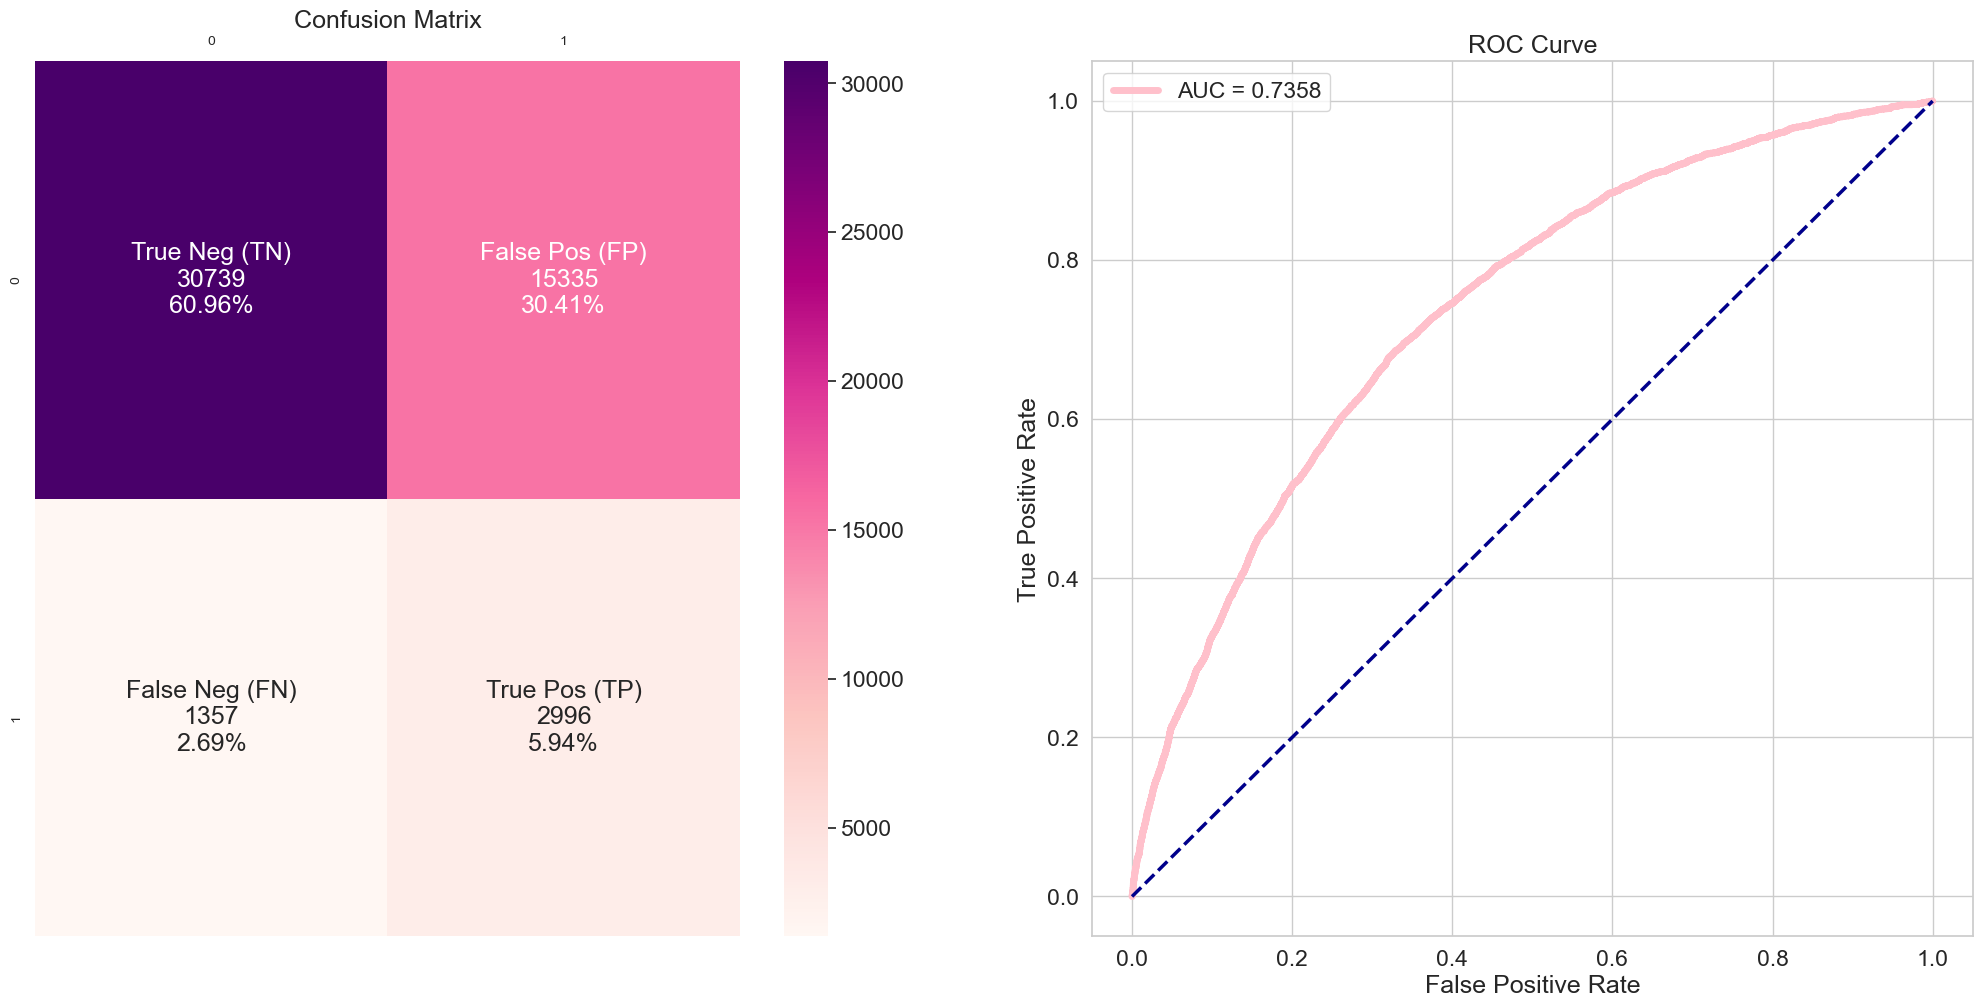

True negative =  30739
False positive =  15335
False negative =  1357
True positive =  2996
time: 578 ms (started: 2023-11-18 04:48:36 +01:00)


In [66]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [67]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.6774139547341637

time: 0 ns (started: 2023-11-18 04:48:40 +01:00)


In [68]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomUnderSampler_rl = pd.DataFrame(
        {
            "Modele": "RandomUnderSampler - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[4],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomUnderSampler_rl])
comparison_model

Modele  Accuracy       AUC  \
0            Baseline - Regression Logistique  0.913043  0.734431   
1                   Baseline - LGBMClassifier  0.914193  0.782269   
2        Class Weight - Regression Logistique  0.677930  0.744140   
3               Class Weight - LGBMClassifier  0.733555  0.782755   
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.019756  0.037744    86   0.421569  4267    0.522477  0.896380  
1        0.034918  0.065645   152   0.546763  4201    0.529753  0.873382  
2        0.677234  0.266341  2948   0.165767  1405    0.677626  0.094692  
3        0.681829  0.306422  2968   0.197616  1385    0.710939  0.935055  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806

time: 31 ms (started: 2023-11-18 04:48:43 +01:00)


##### 7.2.3 LGBMClassifier

In [69]:
# Fixer les valeurs des hyperparamètres à tester
'''param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train_undersampled, y_train_undersampled, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)'''

'param_grid = {\n        \'n_estimators\' : np.arange(500, 1500, 100),\n        \'learning_rate\' : [1, 0.1, 0.01, 0.001]\n        }\n\n# Choisir un score à optimiser\nscore = \'roc_auc\'\n\n\n# define the model/ estimator\nmodel = LGBMClassifier(objective=\'binary\', random_state=42)\n\n# define the grid search\nlgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV\n\n# Optimiser ce régresseur sur le jeu d\'entraînement\nlgbm.fit(X_train_undersampled, y_train_undersampled, eval_metric=\'auc\')\n\n# Afficher le(s) hyperparamètre(s) optimaux\nprint("Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement (best parameters) :")\nbest_params = lgbm.best_params_\nprint(best_params)\nprint(\' \')\nprint("Meilleur(s) score sur le jeu d\'entraînement (roc_auc):")\nprint(lgbm.best_score_)'

time: 0 ns (started: 2023-11-18 04:49:03 +01:00)


Best paramètre sauvegardés car trop lent sur le GridSherchCV

* Fitting 4 folds for each of 40 candidates, totalling 160 fits 
* Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.01, 'n_estimators': 700}
 
* Meilleur(s) score sur le jeu d'entraînement (roc_auc):   
0.7503188069729264
* time: 15min 7s (started: 2023-07-05 00:17:21 +02:00)

In [70]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=700,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)

time: 0 ns (started: 2023-11-18 04:49:09 +01:00)


In [71]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_undersampled, y_train_undersampled, X_test, y_test, "RandomUnderSampler - LGBMClassifier", file_name=None)

Exécution 
 
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 17482, number of negative: 17482
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38397
[LightGBM] [Info] Number of data points in the train set: 34964, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
       SK_ID_CURR  positive_probability
0          272844              0.100725
1          262199              0.538264
2          236291              0.858308
3          399708              0.117296
4          151614              0.189574
...           ...                   ...
50422      125398              0.327563
50423      151094              0.23

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 04:49:29 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 6


time: 17.8 s (started: 2023-11-18 04:49:11 +01:00)


Created version '6' of model 'CreditModels'.


In [72]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             32303 (TN)             13771 (FP)
Real Positive (1)              1268 (FN)              3085 (TP)

time: 0 ns (started: 2023-11-18 04:50:03 +01:00)


In [73]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7733
Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     46074
           1       0.18      0.71      0.29      4353

    accuracy                           0.70     50427
   macro avg       0.57      0.70      0.55     50427
weighted avg       0.89      0.70      0.77     50427

time: 63 ms (started: 2023-11-18 04:50:07 +01:00)


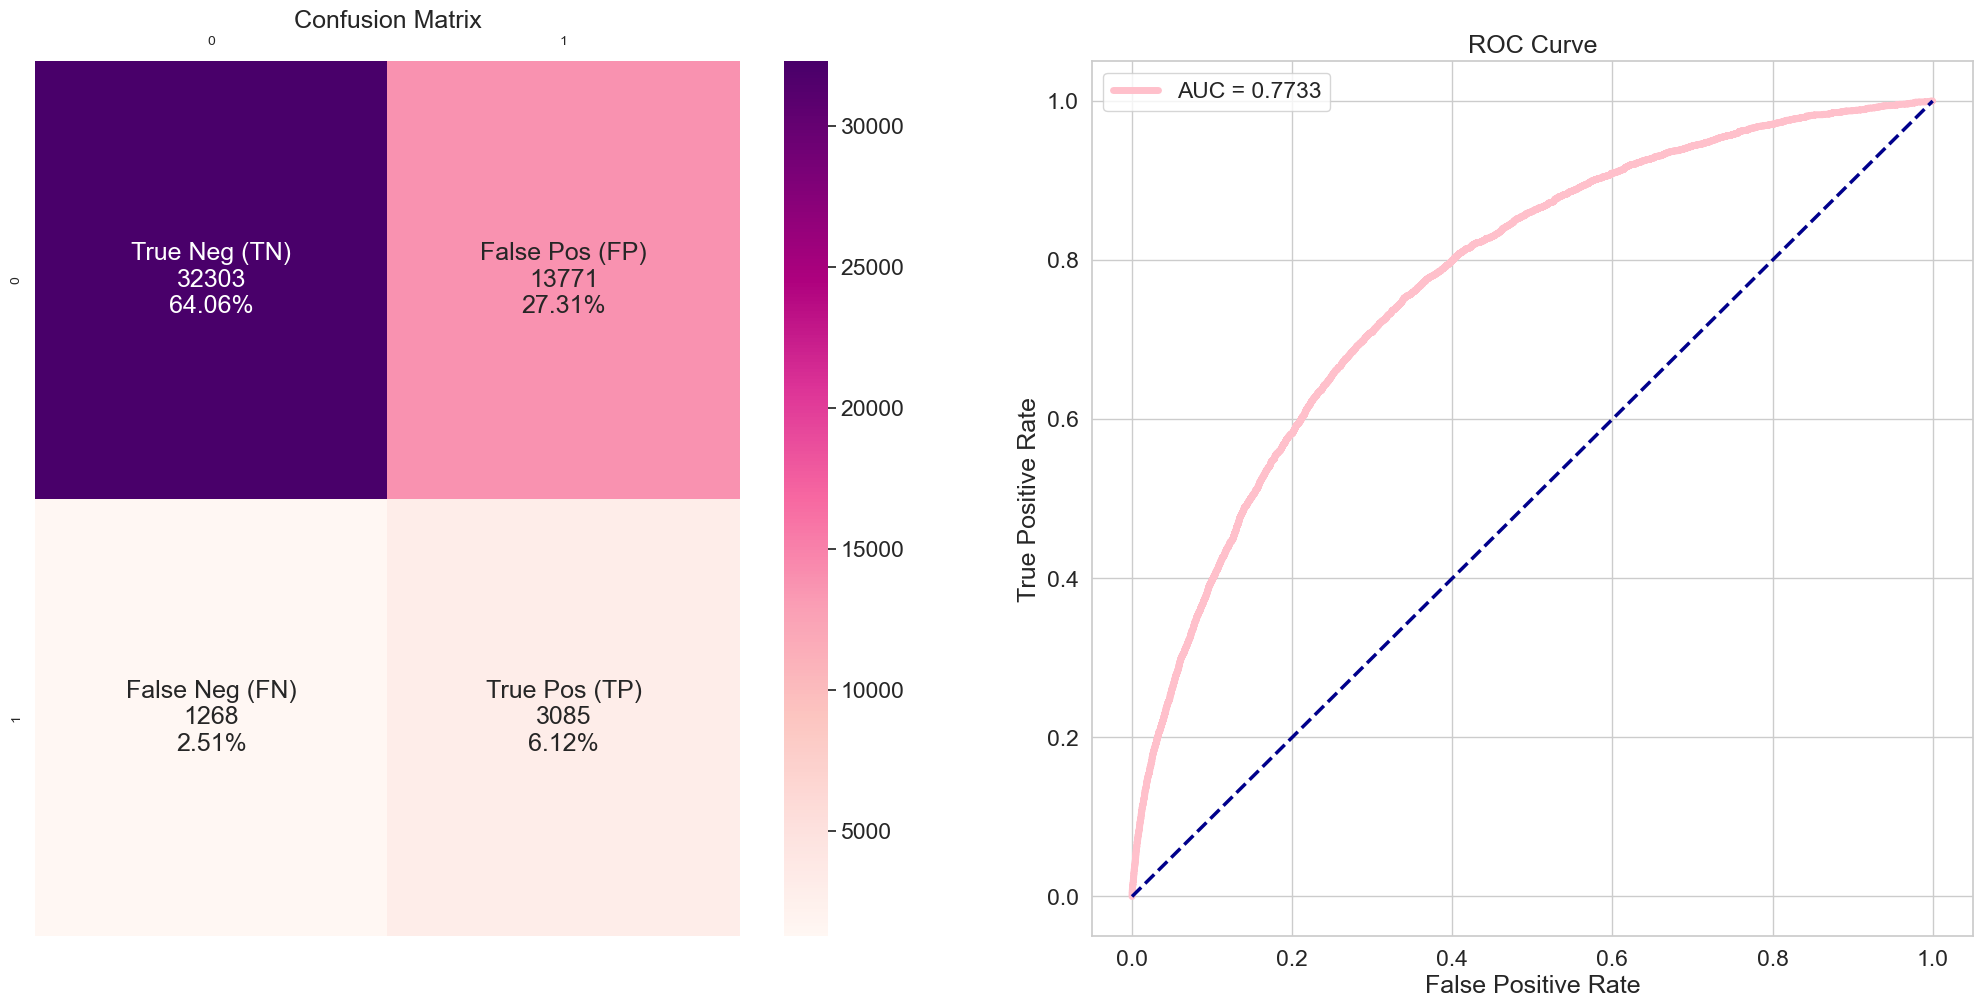

True negative =  32303
False positive =  13771
False negative =  1268
True positive =  3085
time: 516 ms (started: 2023-11-18 04:50:10 +01:00)


In [74]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [75]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.704801124949779

time: 0 ns (started: 2023-11-18 04:50:14 +01:00)


In [76]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomUnderSampler_lgbm = pd.DataFrame(
        {
            "Modele": "RandomUnderSampler - LGBMClassifier",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[5],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomUnderSampler_lgbm])
comparison_model

Modele  Accuracy       AUC  \
0            Baseline - Regression Logistique  0.913043  0.734431   
1                   Baseline - LGBMClassifier  0.914193  0.782269   
2        Class Weight - Regression Logistique  0.677930  0.744140   
3               Class Weight - LGBMClassifier  0.733555  0.782755   
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   
5         RandomUnderSampler - LGBMClassifier  0.701767  0.773315   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.019756  0.037744    86   0.421569  4267    0.522477  0.896380  
1        0.034918  0.065645   152   0.546763  4201    0.529753  0.873382  
2        0.677234  0.266341  2948   0.165767  1405    0.677626  0.094692  
3        0.681829  0.306422  2968   0.197616  1385    0.710939  0.935055  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806  
5        0.708707  0.290914  3085   0.183021  1268    0.704801  0.500069

time: 16 ms (started: 2023-11-18 04:50:18 +01:00)


#### 7.3 Oversampling / suréchantillonnage aléatoires

Le suréchantillonnage aléatoire duplique des exemples de la classe minoritaire dans l'ensemble de données d'apprentissage

C'est une méthode qui va dupliquer aléatoirement des données existantes de la classe minoritaire pour que chaque classe ait le même nombre de données que la classe sur-représentée à l'origine.

##### 7.3.1 Mise en place 

In [77]:
# importer "RandomOverSampler" pour effectuer un suréchantillonnage
#from imblearn.over_sampling import RandomOverSampler

time: 15 ms (started: 2023-11-18 04:51:16 +01:00)


In [78]:
print(f"Label 1, Avant d'utiliser RandomOverSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomOverSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomOverSampler: 17482 
Label 0, Avant d'utiliser RandomOverSampler: 184224 
time: 31 ms (started: 2023-11-18 04:51:19 +01:00)


In [79]:
# Création d'une instance de RandomOverSampler avec un random_state fixé à 0 pour la reproductibilité
ros = RandomOverSampler(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_undersampled et y_train_undersampled
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_oversampled = pd.DataFrame(X_train_oversampled, columns=X_train.columns)

time: 1.7 s (started: 2023-11-18 04:51:23 +01:00)


In [80]:
print(f"Label 1, Après avoir utilisé RandomOverSampler: {sum(y_train_oversampled==1)}")
print(f"Label 0, Après avoir utilisé RandomOverSampler: {sum(y_train_oversampled==0)}")

Label 1, Après avoir utilisé RandomOverSampler: 184224
Label 0, Après avoir utilisé RandomOverSampler: 184224
time: 46 ms (started: 2023-11-18 04:51:31 +01:00)


##### 7.3.2 Régression logistique 

In [81]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_oversampled, y_train_oversampled)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 1}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.7466722936101172
time: 25min 31s (started: 2023-11-18 04:51:41 +01:00)


In [83]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=1,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)

time: 0 ns (started: 2023-11-18 05:18:36 +01:00)


In [84]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_oversampled, y_train_oversampled, X_test, y_test, "RandomOverSampler Regression logistique", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          272844              0.054767
1          262199              0.600527
2          236291              0.765232
3          399708              0.099698
4          151614              0.155177
...           ...                   ...
50422      125398              0.313920
50423      151094              0.230548
50424      287568              0.566982
50425      214293              0.620725
50426      387840              0.398918

[50427 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.677732167291332 pour la méthode RandomOverSampler Regression logistique.
 
 
Le score de précision est de 0.1662739818243016 pour la méthode RandomOverSampler Regression logistique.
 
 
Le score recall est de 0.6809097174362508 pour la méthode RandomOverSampler Regression logistique.
 
 
Le score f1 est de 0.26727985932638987 pour la méthode RandomOverSampler Regression logistique.
 
 
Le score AUC est de 0.7443044285

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 05:19:45 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 7


time: 28.6 s (started: 2023-11-18 05:19:16 +01:00)


Created version '7' of model 'CreditModels'.


In [85]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             31212 (TN)             14862 (FP)
Real Positive (1)              1389 (FN)              2964 (TP)

time: 62 ms (started: 2023-11-18 05:20:22 +01:00)


In [86]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7443
Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.68      0.79     46074
           1       0.17      0.68      0.27      4353

    accuracy                           0.68     50427
   macro avg       0.56      0.68      0.53     50427
weighted avg       0.89      0.68      0.75     50427

time: 94 ms (started: 2023-11-18 05:20:27 +01:00)


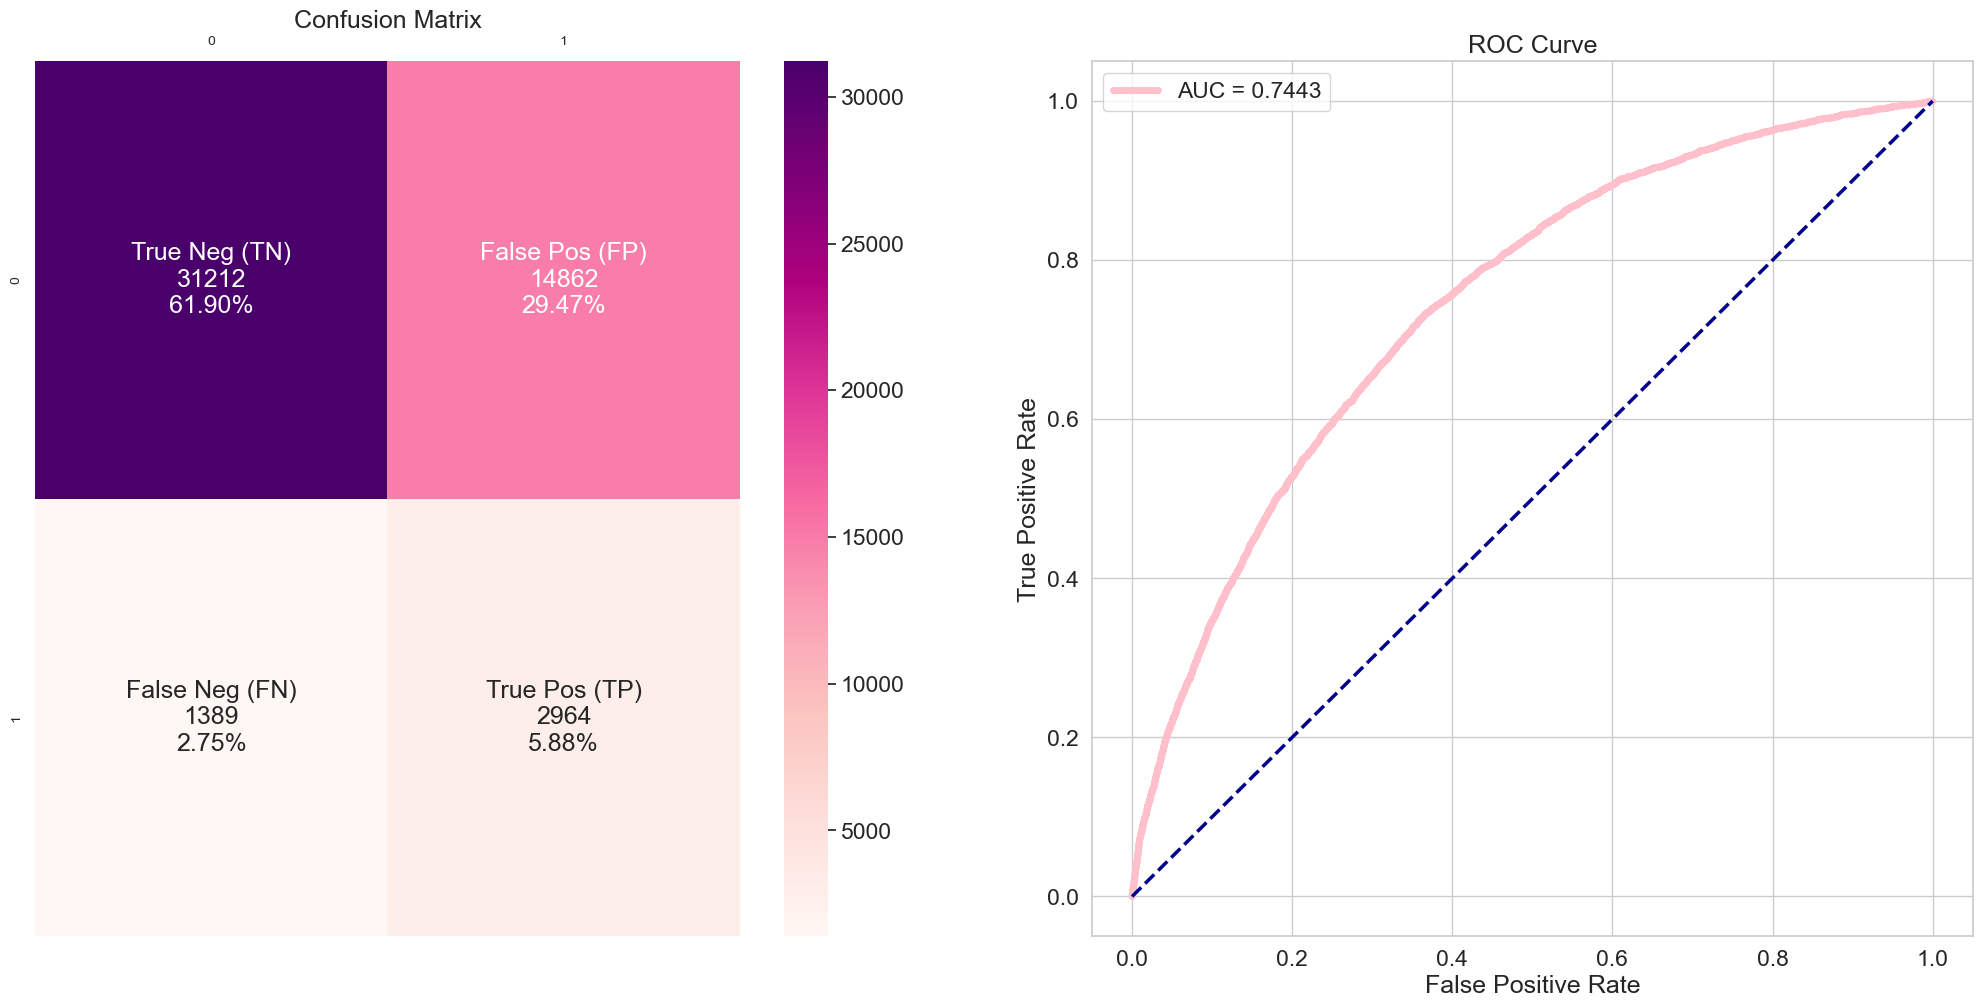

True negative =  31212
False positive =  14862
False negative =  1389
True positive =  2964
time: 828 ms (started: 2023-11-18 05:20:34 +01:00)


In [87]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [88]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.6791214677916164

time: 0 ns (started: 2023-11-18 05:20:49 +01:00)


In [89]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomOverSampler_lr = pd.DataFrame(
        {
            "Modele": "RandomOverSampler - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[6],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomOverSampler_lr])
comparison_model

Modele  Accuracy       AUC  \
0            Baseline - Regression Logistique  0.913043  0.734431   
1                   Baseline - LGBMClassifier  0.914193  0.782269   
2        Class Weight - Regression Logistique  0.677930  0.744140   
3               Class Weight - LGBMClassifier  0.733555  0.782755   
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   
5         RandomUnderSampler - LGBMClassifier  0.701767  0.773315   
6   RandomOverSampler - Regression Logistique  0.677732  0.744304   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.019756  0.037744    86   0.421569  4267    0.522477  0.896380  
1        0.034918  0.065645   152   0.546763  4201    0.529753  0.873382  
2        0.677234  0.266341  2948   0.165767  1405    0.677626  0.094692  
3        0.681829  0.306422  2968   0.197616  1385    0.710939  0.935055  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806  
5        0.708707  0.290914  3085   0.183021  1268    0.704801  0.500069  
6        0.680910  0.267280  2964   0.166274  1389    0.679121  0.639900

time: 15 ms (started: 2023-11-18 05:20:51 +01:00)


##### 7.3.3 LGBMClassifier

In [90]:
# Fixer les valeurs des hyperparamètres à tester
'''param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train_oversampled, y_train_oversampled, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)'''

'param_grid = {\n        \'n_estimators\' : np.arange(500, 1500, 100),\n        \'learning_rate\' : [1, 0.1, 0.01, 0.001]\n        }\n\n# Choisir un score à optimiser\nscore = \'roc_auc\'\n\n\n# define the model/ estimator\nmodel = LGBMClassifier(objective=\'binary\', random_state=42)\n\n# define the grid search\nlgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV\n\n# Optimiser ce régresseur sur le jeu d\'entraînement\nlgbm.fit(X_train_oversampled, y_train_oversampled, eval_metric=\'auc\')\n\n# Afficher le(s) hyperparamètre(s) optimaux\nprint("Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement (best parameters) :")\nbest_params = lgbm.best_params_\nprint(best_params)\nprint(\' \')\nprint("Meilleur(s) score sur le jeu d\'entraînement (roc_auc):")\nprint(lgbm.best_score_)'

time: 0 ns (started: 2023-11-18 05:23:42 +01:00)


Best paramètre sauvegardés car trop lent sur le GridSherchCV

* Fitting 4 folds for each of 40 candidates, totalling 160 fits 
* Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.01, 'n_estimators': 1400}
 
* Meilleur(s) score sur le jeu d'entraînement (roc_auc):   
0.9924004576872585
* time: 1h 35min 15s (started: 2023-07-05 00:53:38 +02:00)

In [91]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=1400,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)

time: 0 ns (started: 2023-11-18 05:23:47 +01:00)


In [92]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_oversampled, y_train_oversampled, X_test, y_test, "RandomOverSampler - LGBMClassifier", file_name=None)

Exécution 
 
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 184224, number of negative: 184224
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.443643 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 43425
[LightGBM] [Info] Number of data points in the train set: 368448, number of used features: 486
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
       SK_ID_CURR  positive_probability
0          272844              0.052868
1          262199              0.538342
2          236291              0.867729
3          399708              0.086491
4          151614              0.230555
...           ...                   ...
50422      125398              0.263571
50423      151094              0

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 05:26:21 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 8


time: 2min 30s (started: 2023-11-18 05:23:51 +01:00)


Created version '8' of model 'CreditModels'.


In [93]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             34164 (TN)             11910 (FP)
Real Positive (1)              1405 (FN)              2948 (TP)

time: 16 ms (started: 2023-11-18 05:26:41 +01:00)


In [94]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7827
Rapport de classification :
              precision    recall  f1-score   support

           0       0.96      0.74      0.84     46074
           1       0.20      0.68      0.31      4353

    accuracy                           0.74     50427
   macro avg       0.58      0.71      0.57     50427
weighted avg       0.89      0.74      0.79     50427

time: 78 ms (started: 2023-11-18 05:27:00 +01:00)


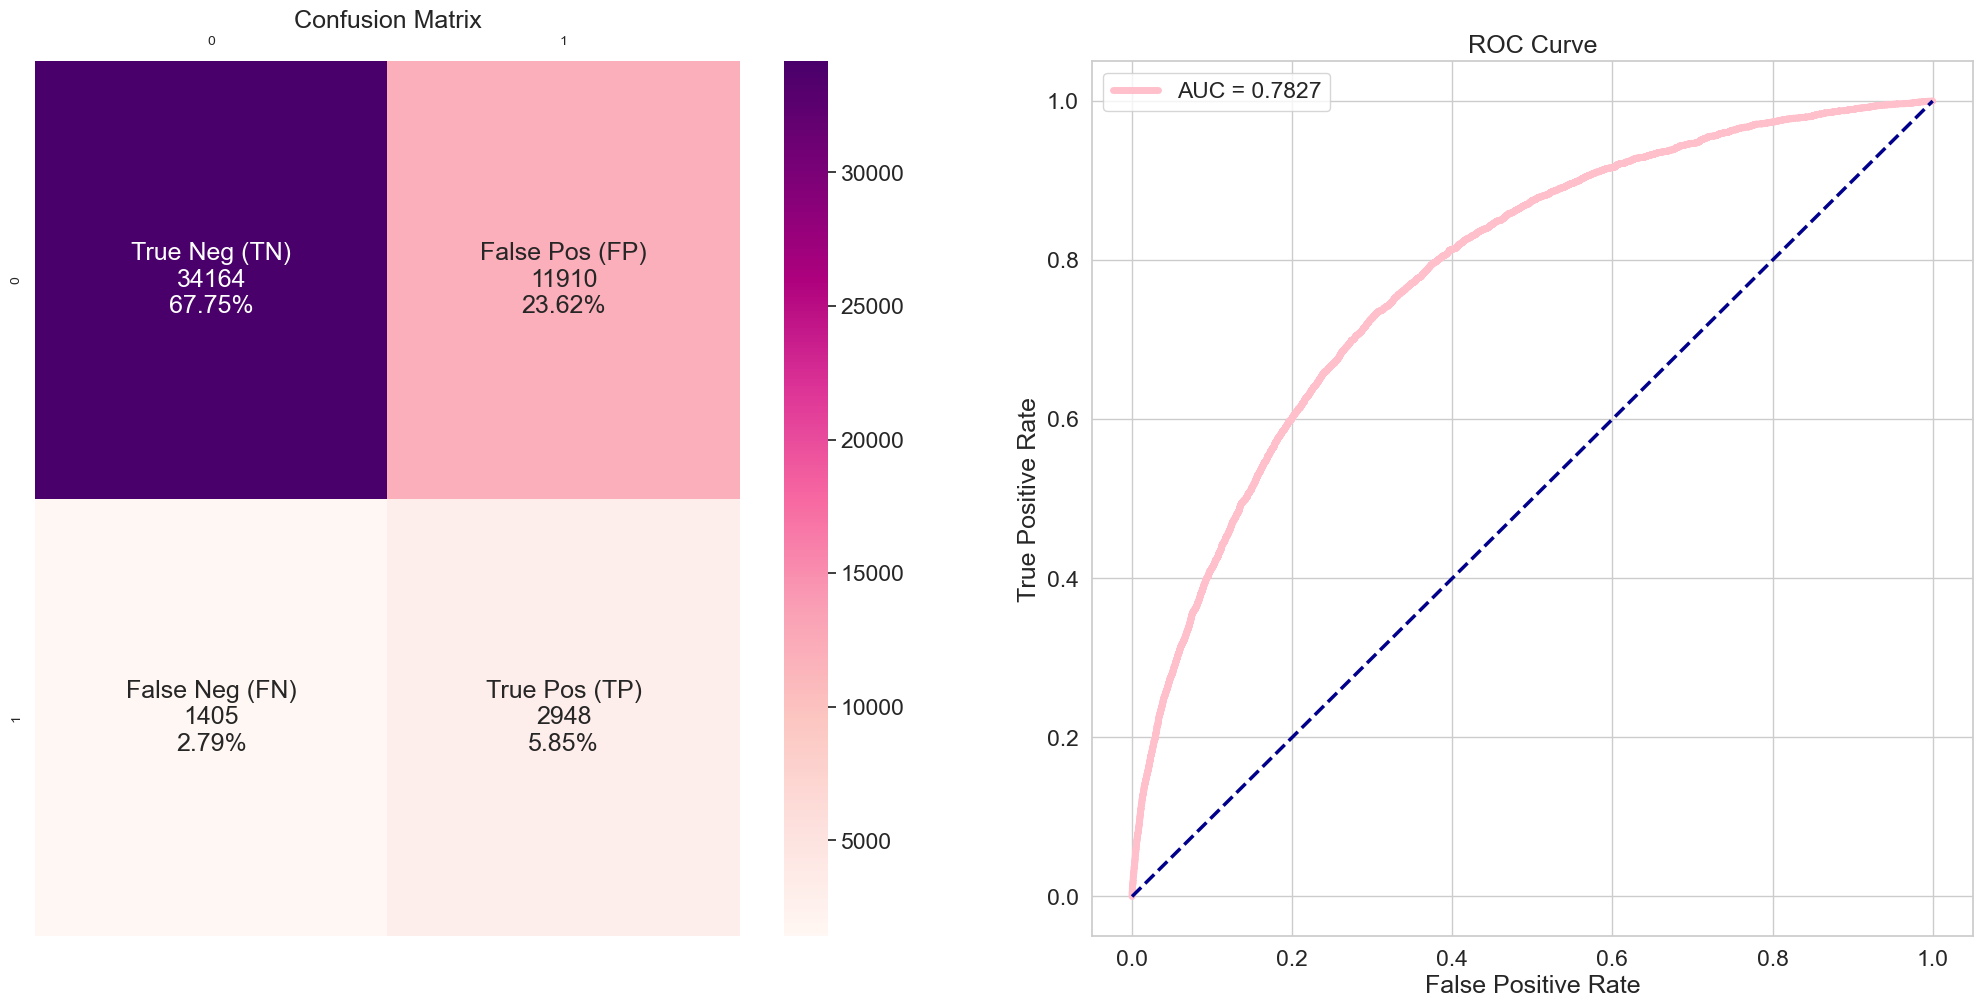

True negative =  34164
False positive =  11910
False negative =  1405
True positive =  2948
time: 546 ms (started: 2023-11-18 05:27:16 +01:00)


In [95]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [96]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.7102807910361144

time: 0 ns (started: 2023-11-18 05:27:36 +01:00)


In [97]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_RandomOverSampler_lgbm = pd.DataFrame(
        {
            "Modele": "RandomOverSampler - LGBMClassifier",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[7],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_RandomOverSampler_lgbm])
comparison_model

Modele  Accuracy       AUC  \
0            Baseline - Regression Logistique  0.913043  0.734431   
1                   Baseline - LGBMClassifier  0.914193  0.782269   
2        Class Weight - Regression Logistique  0.677930  0.744140   
3               Class Weight - LGBMClassifier  0.733555  0.782755   
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   
5         RandomUnderSampler - LGBMClassifier  0.701767  0.773315   
6   RandomOverSampler - Regression Logistique  0.677732  0.744304   
7          RandomOverSampler - LGBMClassifier  0.735955  0.782687   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.019756  0.037744    86   0.421569  4267    0.522477  0.896380  
1        0.034918  0.065645   152   0.546763  4201    0.529753  0.873382  
2        0.677234  0.266341  2948   0.165767  1405    0.677626  0.094692  
3        0.681829  0.306422  2968   0.197616  1385    0.710939  0.935055  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806  
5        0.708707  0.290914  3085   0.183021  1268    0.704801  0.500069  
6        0.680910  0.267280  2964   0.166274  1389    0.679121  0.639900  
7        0.677234  0.306908  2948   0.198412  1405    0.710281  1.047648

time: 31 ms (started: 2023-11-18 05:28:07 +01:00)


#### 7.4 Oversampling (SMOTE) / suréchantillonnage aléatoires

C'est une méthode qui va créer de nouvelles données de la classe sous-représentée à partir des données existantes (et donc de la variété) pour que chaque classe ait le même nombre de données que la classe sur-représentée à l'origine.

##### 7.4.1 Mise en place SMOTE

In [98]:
# importer "SMOTE" pour effectuer un suréchantillonnage
from imblearn.over_sampling import SMOTE

time: 0 ns (started: 2023-11-18 05:28:33 +01:00)


In [99]:
print(f"Label 1, Avant d'utiliser SMOTE: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser SMOTE: {sum(y_train==0)} ")

Label 1, Avant d'utiliser SMOTE: 17482 
Label 0, Avant d'utiliser SMOTE: 184224 
time: 47 ms (started: 2023-11-18 05:28:34 +01:00)


In [100]:
# Création d'une instance de SMOTE avec un random_state fixé à 0 pour la reproductibilité
sm = SMOTE(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_undersampled et y_train_undersampled
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

time: 10.1 s (started: 2023-11-18 05:28:37 +01:00)


In [101]:
print(f"Label 1, Après avoir utilisé SMOTE: {sum(y_train_resampled==1)}")
print(f"Label 0, Après avoir utilisé SMOTE: {sum(y_train_resampled==0)}")

Label 1, Après avoir utilisé SMOTE: 184224
Label 0, Après avoir utilisé SMOTE: 184224
time: 47 ms (started: 2023-11-18 05:28:47 +01:00)


##### 7.4.2 Régression lgistique 

In [102]:
# Fixer les valeurs des hyperparamètres à tester
param_grid = {"C":[-0.001, -0.01, -0.1, 1, 0.1, 0.01, 0.001, 5, 10, 15, 50, 100]} 
        

# Choisir un score à optimiser
score = 'roc_auc'


# définir le modèle/ estimateur
model = LogisticRegression(random_state=42)

# définir le grid search
lr= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lr.fit(X_train_resampled, y_train_resampled)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lr.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lr.best_score_)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'C': 10}
 
Meilleur(s) score sur le jeu d'entraînement (roc_auc):
0.9047789386914508
time: 27min 34s (started: 2023-11-18 05:28:47 +01:00)


In [103]:
# Définition des hyperparamètres optimaux pour le modèle de régression logistique
best_params = LogisticRegression(
    C=10,  # Paramètre de régularisation inverse (plus petit est C, plus forte est la régularisation)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    dual=False,  # Contrainte de dualité (utilisé pour de petites tailles d'échantillons et lorsque le nombre de fonctionnalités est supérieur au nombre d'échantillons)
    fit_intercept=True,  # Indique si une constante (intercept) doit être ajoutée à la fonction de décision
    intercept_scaling=1,  # Paramètre de mise à l'échelle de l'intercept
    l1_ratio=None,  # Paramètre pour la régularisation L1 (None signifie pas de régularisation L1)
    max_iter=100,  # Nombre maximum d'itérations pour la convergence
    multi_class='auto',  # Contrôle la stratégie de résolution du problème de classification multiclasse
    n_jobs=None,  # Nombre de cœurs de processeur à utiliser lors du calcul (None signifie un seul cœur)
    penalty='l2',  # Type de régularisation à utiliser (l2 indique une régularisation L2)
    random_state=42,  # Graine aléatoire pour la reproductibilité des résultats
    solver='lbfgs',  # Algorithme à utiliser pour l'optimisation (lbfgs est un algorithme de descente de gradient limité)
    tol=0.0001,  # Tolérance pour la convergence
    verbose=0,  # Contrôle la verbosité lors de l'ajustement (0 signifie aucune sortie affichée)
    warm_start=False  # Contrôle la réutilisation de la solution précédente pour l'initialisation
)

time: 15 ms (started: 2023-11-18 05:57:21 +01:00)


In [104]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_resampled, y_train_resampled, X_test, y_test, "SMOTE - Regression logistique", file_name=None)

Exécution 
 
       SK_ID_CURR  positive_probability
0          272844              0.001039
1          262199              0.285857
2          236291              0.948502
3          399708              0.025646
4          151614              0.007685
...           ...                   ...
50422      125398              0.223671
50423      151094              0.028383
50424      287568              0.178459
50425      214293              0.379729
50426      387840              0.262807

[50427 rows x 2 columns]
Qualité de la classification 
 
 
L'accuracy score est de 0.7863049556785056 pour la méthode SMOTE - Regression logistique.
 
 
Le score de précision est de 0.19358839805362082 pour la méthode SMOTE - Regression logistique.
 
 
Le score recall est de 0.46611532276590856 pour la méthode SMOTE - Regression logistique.
 
 
Le score f1 est de 0.27356073884319804 pour la méthode SMOTE - Regression logistique.
 
 
Le score AUC est de 0.7196171530051225 pour la méthode SMOTE - Regres

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 05:58:24 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 9


time: 36.8 s (started: 2023-11-18 05:57:48 +01:00)


Created version '9' of model 'CreditModels'.


In [105]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             37622 (TN)              8452 (FP)
Real Positive (1)              2324 (FN)              2029 (TP)

time: 78 ms (started: 2023-11-18 05:58:42 +01:00)


In [106]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7196
Rapport de classification :
              precision    recall  f1-score   support

           0       0.94      0.82      0.87     46074
           1       0.19      0.47      0.27      4353

    accuracy                           0.79     50427
   macro avg       0.57      0.64      0.57     50427
weighted avg       0.88      0.79      0.82     50427

time: 94 ms (started: 2023-11-18 05:58:47 +01:00)


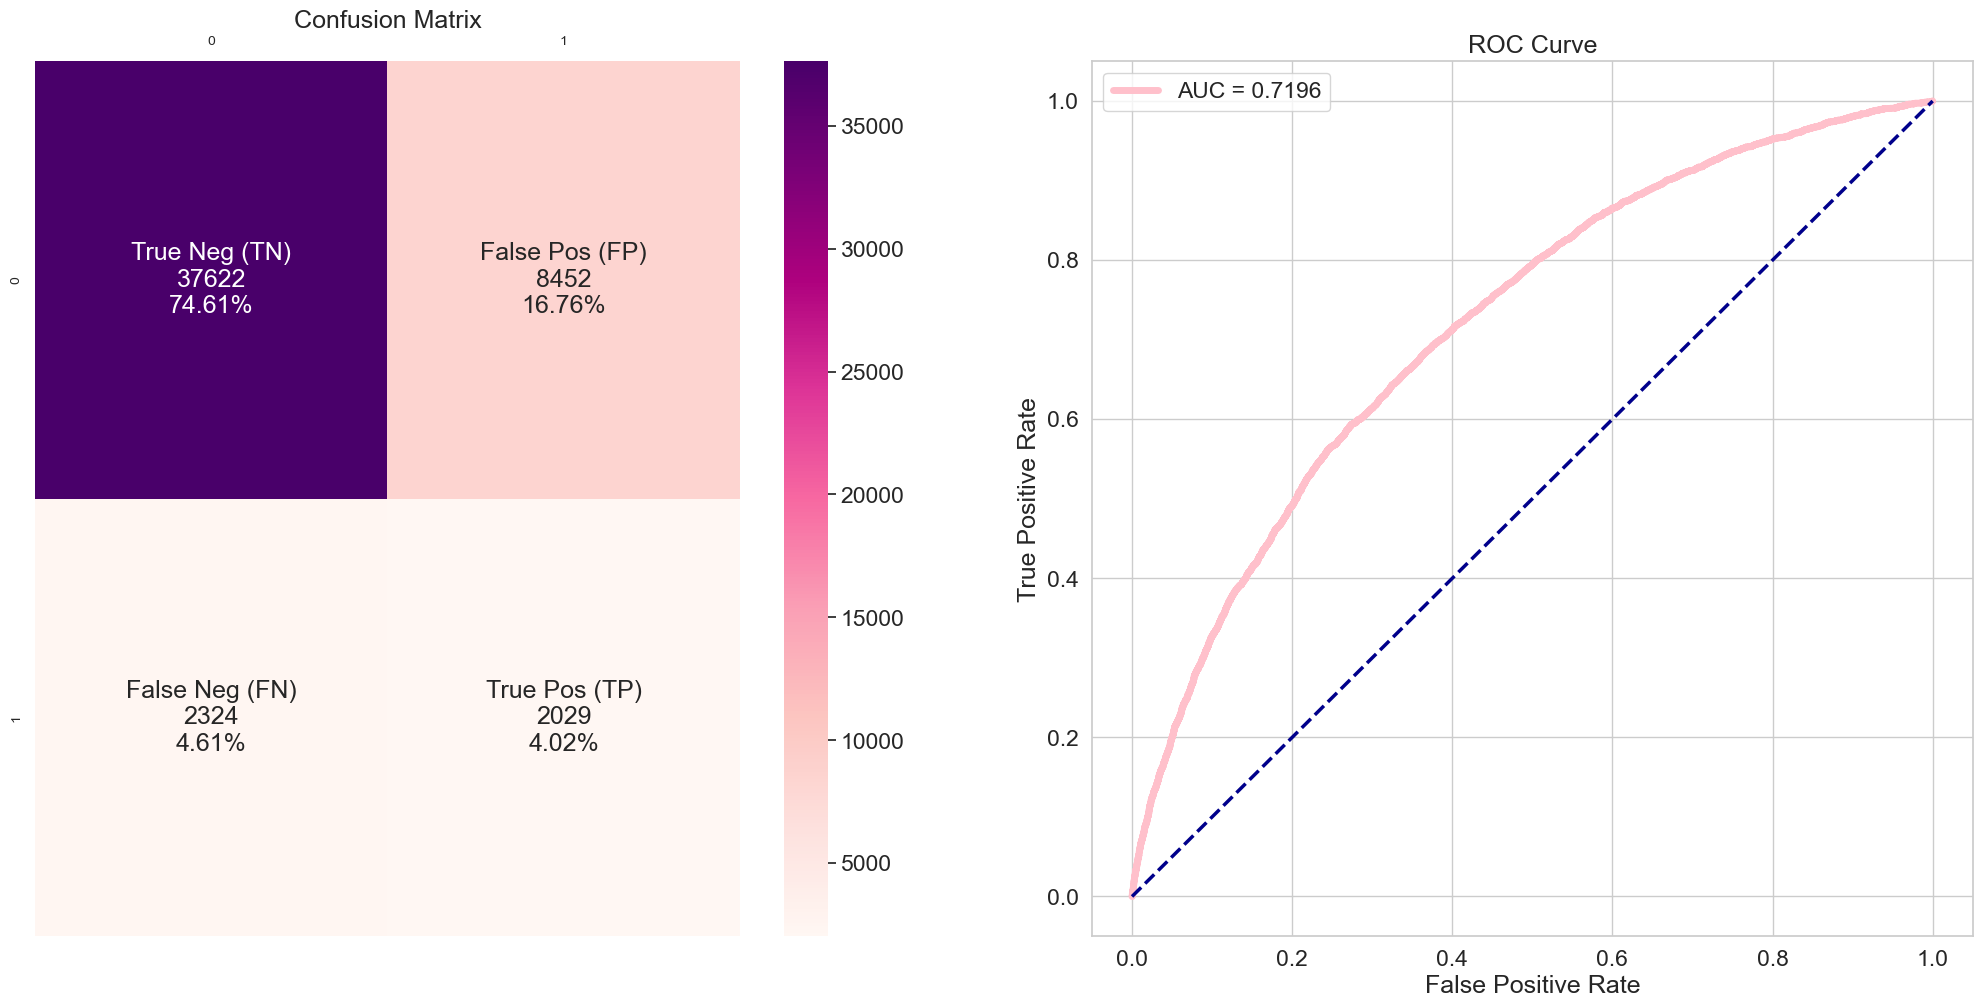

True negative =  37622
False positive =  8452
False negative =  2324
True positive =  2029
time: 890 ms (started: 2023-11-18 05:58:51 +01:00)


In [107]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [108]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.6463104325699746

time: 16 ms (started: 2023-11-18 05:59:06 +01:00)


In [109]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_smote_rl = pd.DataFrame(
        {
            "Modele": "SMOTE - Regression Logistique",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[8],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_smote_rl])
comparison_model

Modele  Accuracy       AUC  \
0            Baseline - Regression Logistique  0.913043  0.734431   
1                   Baseline - LGBMClassifier  0.914193  0.782269   
2        Class Weight - Regression Logistique  0.677930  0.744140   
3               Class Weight - LGBMClassifier  0.733555  0.782755   
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   
5         RandomUnderSampler - LGBMClassifier  0.701767  0.773315   
6   RandomOverSampler - Regression Logistique  0.677732  0.744304   
7          RandomOverSampler - LGBMClassifier  0.735955  0.782687   
8               SMOTE - Regression Logistique  0.786305  0.719617   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.019756  0.037744    86   0.421569  4267    0.522477  0.896380  
1        0.034918  0.065645   152   0.546763  4201    0.529753  0.873382  
2        0.677234  0.266341  2948   0.165767  1405    0.677626  0.094692  
3        0.681829  0.306422  2968   0.197616  1385    0.710939  0.935055  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806  
5        0.708707  0.290914  3085   0.183021  1268    0.704801  0.500069  
6        0.680910  0.267280  2964   0.166274  1389    0.679121  0.639900  
7        0.677234  0.306908  2948   0.198412  1405    0.710281  1.047648  
8        0.466115  0.273561  2029   0.193588  2324    0.646310  0.674076

time: 32 ms (started: 2023-11-18 05:59:11 +01:00)


##### 7.4.3 LGBMClassifier

In [110]:
# Fixer les valeurs des hyperparamètres à tester
'''param_grid = {
        'n_estimators' : np.arange(500, 1500, 100),
        'learning_rate' : [1, 0.1, 0.01, 0.001]
        }

# Choisir un score à optimiser
score = 'roc_auc'


# define the model/ estimator
model = LGBMClassifier(objective='binary', random_state=42)

# define the grid search
lgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV

# Optimiser ce régresseur sur le jeu d'entraînement
lgbm.fit(X_train_resampled, y_train_resampled, eval_metric='auc')

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :")
best_params = lgbm.best_params_
print(best_params)
print(' ')
print("Meilleur(s) score sur le jeu d'entraînement (roc_auc):")
print(lgbm.best_score_)'''

'param_grid = {\n        \'n_estimators\' : np.arange(500, 1500, 100),\n        \'learning_rate\' : [1, 0.1, 0.01, 0.001]\n        }\n\n# Choisir un score à optimiser\nscore = \'roc_auc\'\n\n\n# define the model/ estimator\nmodel = LGBMClassifier(objective=\'binary\', random_state=42)\n\n# define the grid search\nlgbm= GridSearchCV(model, param_grid, scoring=score, cv=4, n_jobs=-1, verbose=2)  #cv : number of cross validation RandomizedSearchCV\n\n# Optimiser ce régresseur sur le jeu d\'entraînement\nlgbm.fit(X_train_resampled, y_train_resampled, eval_metric=\'auc\')\n\n# Afficher le(s) hyperparamètre(s) optimaux\nprint("Meilleur(s) hyperparamètre(s) sur le jeu d\'entraînement (best parameters) :")\nbest_params = lgbm.best_params_\nprint(best_params)\nprint(\' \')\nprint("Meilleur(s) score sur le jeu d\'entraînement (roc_auc):")\nprint(lgbm.best_score_)'

time: 0 ns (started: 2023-11-18 05:59:47 +01:00)


Best paramètre sauvegardés car trop lent sur le GridSherchCV

* Fitting 4 folds for each of 40 candidates, totalling 160 fits 
* Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement (best parameters) :
{'learning_rate': 0.1, 'n_estimators': 800}
 
* Meilleur(s) score sur le jeu d'entraînement (roc_auc):   
0.9742854446562242
* time: 1h 59min 2s (started: 2023-07-05 09:40:14 +02:00)

In [111]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_params = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.1,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=800,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)

time: 15 ms (started: 2023-11-18 06:00:08 +01:00)


In [112]:
# Appliquer la fonction "classification" avec les paramètres appropriés
model, accuracy, precision, recall, f1, AUC, prediction, probability, execution_time, prediction_time, resume_prediction_class, probability_positive_class= classification(best_params, X_train_resampled, y_train_resampled, X_test, y_test, "SMOTE - LGBMClassifier", file_name=None)

Exécution 
 
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 184224, number of negative: 184224
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.729831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 82714
[LightGBM] [Info] Number of data points in the train set: 368448, number of used features: 486
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
       SK_ID_CURR  positive_probability
0          272844              0.006255
1          262199              0.105264
2          236291              0.450454
3          399708              0.005273
4          151614              0.018071
...           ...                   ...
50422      125398              0.036058
50423      151094              0

Registered model 'CreditModels' already exists. Creating a new version of this model...
2023/11/18 06:01:48 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CreditModels, version 10


time: 1min 2s (started: 2023-11-18 06:00:45 +01:00)


Created version '10' of model 'CreditModels'.


In [113]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             45802 (TN)               272 (FP)
Real Positive (1)              4066 (FN)               287 (TP)

time: 15 ms (started: 2023-11-18 06:02:32 +01:00)


In [114]:
# Calcul de l'aire sous la courbe ROC (ROC AUC) à partir des vraies étiquettes "y_test" et des probabilités de la classe positive "probability[:,1]"
# La fonction "roc_auc_score" prend en entrée les vraies étiquettes binaires (0 ou 1) et les probabilités de la classe positive
roc_auc = roc_auc_score(y_test, probability[:,1])

# Affichage de l'aire sous la courbe ROC (ROC AUC)
print('AUC : %0.4f' % roc_auc)

# Affichage du rapport de classification, qui contient différentes métriques pour évaluer les performances du modèle
# Le rapport de classification affiche la précision, le rappel, le score F1 et le support pour chaque classe du modèle (dans ce cas, classe 0 et classe 1)
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
print('Rapport de classification :')
print(classification_report(y_test, prediction))

AUC : 0.7690
Rapport de classification :
              precision    recall  f1-score   support

           0       0.92      0.99      0.95     46074
           1       0.51      0.07      0.12      4353

    accuracy                           0.91     50427
   macro avg       0.72      0.53      0.54     50427
weighted avg       0.88      0.91      0.88     50427

time: 78 ms (started: 2023-11-18 06:02:46 +01:00)


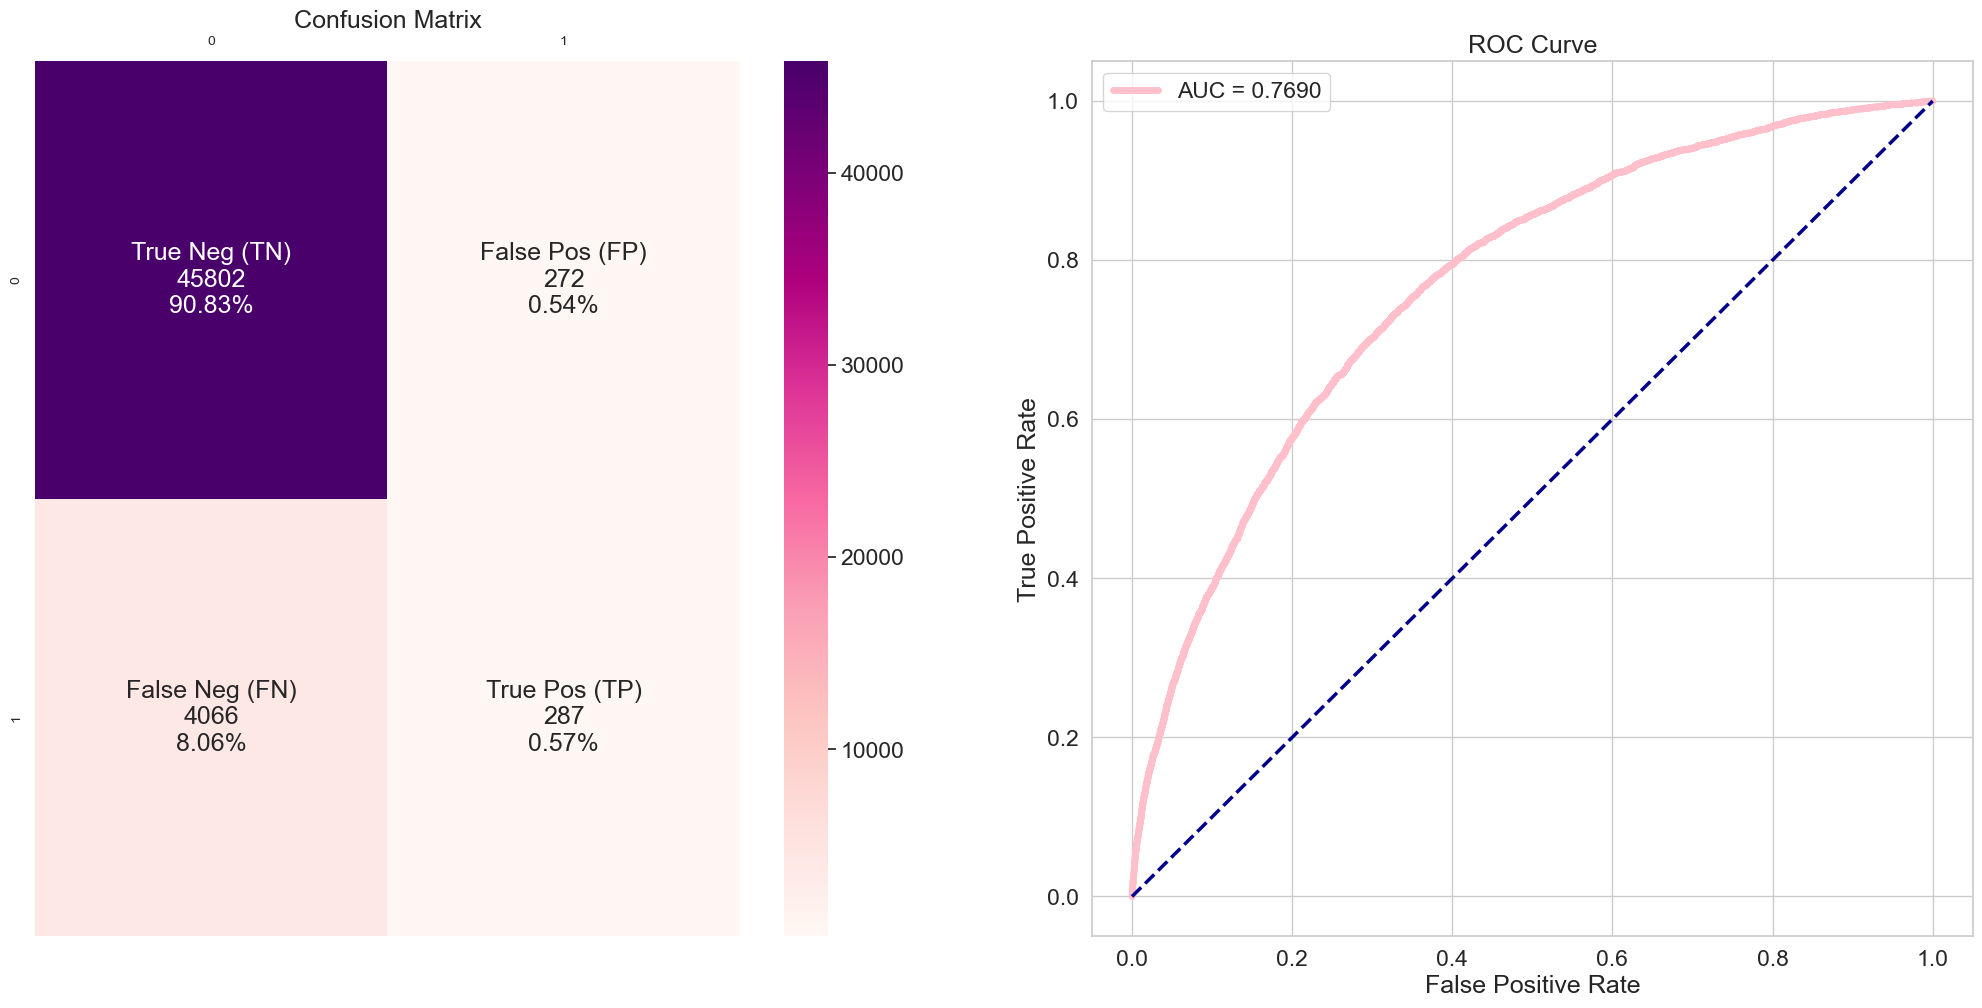

True negative =  45802
False positive =  272
False negative =  4066
True positive =  287
time: 2.69 s (started: 2023-11-18 06:02:51 +01:00)


In [115]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [116]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.5431900361591

time: 0 ns (started: 2023-11-18 06:03:11 +01:00)


In [117]:
# Ajout des métriques du modèle de régression logistique à la DataFrame
comparison_smote_lgbm = pd.DataFrame(
        {
            "Modele": "SMOTE - LGBMClassifier",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[9],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle de régression logistique
comparison_model = pd.concat([comparison_model, comparison_smote_lgbm])
comparison_model

Modele  Accuracy       AUC  \
0            Baseline - Regression Logistique  0.913043  0.734431   
1                   Baseline - LGBMClassifier  0.914193  0.782269   
2        Class Weight - Regression Logistique  0.677930  0.744140   
3               Class Weight - LGBMClassifier  0.733555  0.782755   
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   
5         RandomUnderSampler - LGBMClassifier  0.701767  0.773315   
6   RandomOverSampler - Regression Logistique  0.677732  0.744304   
7          RandomOverSampler - LGBMClassifier  0.735955  0.782687   
8               SMOTE - Regression Logistique  0.786305  0.719617   
9                      SMOTE - LGBMClassifier  0.913975  0.768974   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.019756  0.037744    86   0.421569  4267    0.522477  0.896380  
1        0.034918  0.065645   152   0.546763  4201    0.529753  0.873382  
2        0.677234  0.266341  2948   0.165767  1405    0.677626  0.094692  
3        0.681829  0.306422  2968   0.197616  1385    0.710939  0.935055  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806  
5        0.708707  0.290914  3085   0.183021  1268    0.704801  0.500069  
6        0.680910  0.267280  2964   0.166274  1389    0.679121  0.639900  
7        0.677234  0.306908  2948   0.198412  1405    0.710281  1.047648  
8        0.466115  0.273561  2029   0.193588  2324    0.646310  0.674076  
9        0.065932  0.116857   287   0.513417  4066    0.543190  0.421641

time: 15 ms (started: 2023-11-18 06:03:27 +01:00)


### 8 - Comparaison modèles

#### 8.1 Baseline
comparer les 2 modèles de base

In [118]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec baseline
baseline = comparison_model[comparison_model["Modele"].str.contains("Baseline")]
baseline

Modele  Accuracy       AUC  Recall class 1  \
0  Baseline - Regression Logistique  0.913043  0.734431        0.019756   
1         Baseline - LGBMClassifier  0.914193  0.782269        0.034918   

         F1   TP  Precision    FN  score Gain      time  
0  0.037744   86   0.421569  4267    0.522477  0.896380  
1  0.065645  152   0.546763  4201    0.529753  0.873382

time: 15 ms (started: 2023-11-18 06:04:09 +01:00)


In [119]:
baseline.to_csv("comparison_baseline.csv", index=False)

time: 16 ms (started: 2023-11-18 06:04:14 +01:00)


L'AUC est maximisé avec l'algorithme  LGBMClassifier en Baseline.

Le Recall pour la class 1 est maximisé avec l'algorithme  LGBMClassifier en Baseline, on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme LGBMClassifier en Baseline.

Le F1_score est maximisé avec l'algorithme  LGBMClassifier en Baseline.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme LGBMClassifier en Baseline.

La métrique personnelle créée permet de dire que c'est avec l'algorithme LGBMClassifier en Baseline que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

En Baseline le modèle optimal choisi est  LGBMClassifier.

#### 8.2 Class_weight 
comparer les 2 modèles avec Class_weight qui est à "balanced" intégré au modèle

In [120]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec class weight
class_Weight = comparison_model[comparison_model["Modele"].str.contains("Class Weight")]
class_Weight

Modele  Accuracy       AUC  Recall class 1  \
2  Class Weight - Regression Logistique  0.677930  0.744140        0.677234   
3         Class Weight - LGBMClassifier  0.733555  0.782755        0.681829   

         F1    TP  Precision    FN  score Gain      time  
2  0.266341  2948   0.165767  1405    0.677626  0.094692  
3  0.306422  2968   0.197616  1385    0.710939  0.935055

time: 0 ns (started: 2023-11-18 06:06:20 +01:00)


In [121]:
class_Weight.to_csv("comparison_class_weight.csv", index=False)

time: 0 ns (started: 2023-11-18 06:06:22 +01:00)


L'AUC est maximisé avec l'algorithme LGBMClassifier.

Le Recall est maximisé avec l'algorithme LGBMClassifier, on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme LGBMClassifier.

Le F1_score est maximisé avec l'algorithme LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme LGBMClassifier.

La métrique personnelle créée permet de dire que c'est avec l'algorithme LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Avec la méthode Class_weight='balanced'et si on se base sur la métrique d'optimisation des coûts, il s'agit de l'algorithme LGBMClassifier qui maximise les gains.

#### 8.3 Undersampling 

In [122]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec RandomUnderSampler
randomUnderSampler = comparison_model[comparison_model["Modele"].str.contains("RandomUnderSampler")]
randomUnderSampler

Modele  Accuracy       AUC  \
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   
5         RandomUnderSampler - LGBMClassifier  0.701767  0.773315   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806  
5        0.708707  0.290914  3085   0.183021  1268    0.704801  0.500069

time: 16 ms (started: 2023-11-18 06:07:46 +01:00)


In [123]:
randomUnderSampler.to_csv("comparison_RandomUnderSampler.csv", index=False)

time: 0 ns (started: 2023-11-18 06:07:48 +01:00)


L'AUC est maximisé avec l'algorithme LGBMClassifier.

Le Recall est maximisé avec l'algorithme LGBMClassifier, on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme LGBMClassifier.

Le F1_score est maximisé avec l'algorithme LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme LGBMClassifier.

La métrique personnelle créée permet de dire que c'est avec l'algorithme LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Avec la méthode undersampler, et si on se base sur la métrique d'optimisation des coûts, il s'agit de l'algorithme LGBMClassifier qui maximise les gains.

#### 8.4 Oversampling

In [124]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec RandomOverSampler
randomOverSampler = comparison_model[comparison_model["Modele"].str.contains("RandomOverSampler")]
randomOverSampler

Modele  Accuracy       AUC  \
6  RandomOverSampler - Regression Logistique  0.677732  0.744304   
7         RandomOverSampler - LGBMClassifier  0.735955  0.782687   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
6        0.680910  0.267280  2964   0.166274  1389    0.679121  0.639900  
7        0.677234  0.306908  2948   0.198412  1405    0.710281  1.047648

time: 16 ms (started: 2023-11-18 06:09:57 +01:00)


In [125]:
randomOverSampler.to_csv("comparison_RandomOverSampler.csv", index=False)

time: 15 ms (started: 2023-11-18 06:09:59 +01:00)


L'AUC est maximisé avec l'algorithme LGBMClassifier.

Le Recall est maximisé avec l'algorithme de Régression Logistique, on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme de Régression Logistique.

Le F1_score est maximisé avec l'algorithme LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme Régression Logistique.

La métrique personnelle créée permet de dire que c'est avec l'algorithme LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Avec la méthode oversampler, et si on se base sur la métrique d'optimisation des coûts, il s'agit de l'algorithme LGBMClassifier qui maximise les gains.

#### 8.5 Oversampling (SMOTE)

In [126]:
# Filtrer le DataFrame sur la colonne "Modele" pour ne conserver que les lignes avec SMOTE
smote = comparison_model[comparison_model["Modele"].str.contains("SMOTE")]
smote

Modele  Accuracy       AUC  Recall class 1  \
8  SMOTE - Regression Logistique  0.786305  0.719617        0.466115   
9         SMOTE - LGBMClassifier  0.913975  0.768974        0.065932   

         F1    TP  Precision    FN  score Gain      time  
8  0.273561  2029   0.193588  2324     0.64631  0.674076  
9  0.116857   287   0.513417  4066     0.54319  0.421641

time: 0 ns (started: 2023-11-18 06:12:38 +01:00)


In [127]:
smote.to_csv("comparison_smote.csv", index=False)

time: 0 ns (started: 2023-11-18 06:13:44 +01:00)


L'AUC est maximisé avec l'algorithme LGBMClassifier.

Le Recall est maximisé avec l'algorithme de Régression Logistique, on rate donc le moins de TP avec cet algorithme.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme de Régression Logistique.

Le F1_score est maximisé avec de Régression Logistique.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme de Régression Logistique.

La métrique personnelle créée permet de dire que c'est avec l'algorithme de Régression Logistique que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Avec la méthode SMOTE, on peut dire que l'algorithme optimal est l'algorithme de Régression Logistique. 

#### 8.6 Best of the Best sur toute les approches 

In [128]:
comparison_model

Modele  Accuracy       AUC  \
0            Baseline - Regression Logistique  0.913043  0.734431   
1                   Baseline - LGBMClassifier  0.914193  0.782269   
2        Class Weight - Regression Logistique  0.677930  0.744140   
3               Class Weight - LGBMClassifier  0.733555  0.782755   
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   
5         RandomUnderSampler - LGBMClassifier  0.701767  0.773315   
6   RandomOverSampler - Regression Logistique  0.677732  0.744304   
7          RandomOverSampler - LGBMClassifier  0.735955  0.782687   
8               SMOTE - Regression Logistique  0.786305  0.719617   
9                      SMOTE - LGBMClassifier  0.913975  0.768974   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.019756  0.037744    86   0.421569  4267    0.522477  0.896380  
1        0.034918  0.065645   152   0.546763  4201    0.529753  0.873382  
2        0.677234  0.266341  2948   0.165767  1405    0.677626  0.094692  
3        0.681829  0.306422  2968   0.197616  1385    0.710939  0.935055  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806  
5        0.708707  0.290914  3085   0.183021  1268    0.704801  0.500069  
6        0.680910  0.267280  2964   0.166274  1389    0.679121  0.639900  
7        0.677234  0.306908  2948   0.198412  1405    0.710281  1.047648  
8        0.466115  0.273561  2029   0.193588  2324    0.646310  0.674076  
9        0.065932  0.116857   287   0.513417  4066    0.543190  0.421641

time: 16 ms (started: 2023-11-18 06:17:10 +01:00)


In [129]:
comparison_model.to_csv("all_comparison_method.csv", index=False)

time: 0 ns (started: 2023-11-18 06:17:56 +01:00)


In [130]:
# Triez le DataFrame sur la colonne "AUC"  ordre décroissant
comparison_model_sorted = comparison_model.sort_values(by=["AUC"], ascending=False)
comparison_model_sorted

Modele  Accuracy       AUC  \
3               Class Weight - LGBMClassifier  0.733555  0.782755   
7          RandomOverSampler - LGBMClassifier  0.735955  0.782687   
1                   Baseline - LGBMClassifier  0.914193  0.782269   
5         RandomUnderSampler - LGBMClassifier  0.701767  0.773315   
9                      SMOTE - LGBMClassifier  0.913975  0.768974   
6   RandomOverSampler - Regression Logistique  0.677732  0.744304   
2        Class Weight - Regression Logistique  0.677930  0.744140   
4  RandomUnderSampler - Regression Logistique  0.668987  0.735761   
0            Baseline - Regression Logistique  0.913043  0.734431   
8               SMOTE - Regression Logistique  0.786305  0.719617   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
3        0.681829  0.306422  2968   0.197616  1385    0.710939  0.935055  
7        0.677234  0.306908  2948   0.198412  1405    0.710281  1.047648  
1        0.034918  0.065645   152   0.546763  4201    0.529753  0.873382  
5        0.708707  0.290914  3085   0.183021  1268    0.704801  0.500069  
9        0.065932  0.116857   287   0.513417  4066    0.543190  0.421641  
6        0.680910  0.267280  2964   0.166274  1389    0.679121  0.639900  
2        0.677234  0.266341  2948   0.165767  1405    0.677626  0.094692  
4        0.688261  0.264151  2996   0.163439  1357    0.677414  0.093806  
0        0.019756  0.037744    86   0.421569  4267    0.522477  0.896380  
8        0.466115  0.273561  2029   0.193588  2324    0.646310  0.674076

time: 0 ns (started: 2023-11-18 06:18:10 +01:00)


Nous sélectionnons les meilleurs  modèles par chaque approche

* LGBMClassifier en Class Weight
* LGBMClassifier en RandomOverSampler
* LGBMClassifier en Baseline
* LGBMClassifier en RandomUnderSampler
* LGBMClassifier en Smote 

In [131]:
# Liste des modèles à conserver
best_model = ['Class Weight - LGBMClassifier', 'RandomOverSampler - LGBMClassifier', 'Baseline - LGBMClassifier', 
              'RandomUnderSampler - LGBMClassifier', 'SMOTE - LGBMClassifier']

# Filtrer le dataset en utilisant
comparison_best_model = comparison_model.loc[comparison_model['Modele'].isin(best_model)]

#comparison_best_model.sort_values()
comparison_best_model

Modele  Accuracy       AUC  Recall class 1  \
1            Baseline - LGBMClassifier  0.914193  0.782269        0.034918   
3        Class Weight - LGBMClassifier  0.733555  0.782755        0.681829   
5  RandomUnderSampler - LGBMClassifier  0.701767  0.773315        0.708707   
7   RandomOverSampler - LGBMClassifier  0.735955  0.782687        0.677234   
9               SMOTE - LGBMClassifier  0.913975  0.768974        0.065932   

         F1    TP  Precision    FN  score Gain      time  
1  0.065645   152   0.546763  4201    0.529753  0.873382  
3  0.306422  2968   0.197616  1385    0.710939  0.935055  
5  0.290914  3085   0.183021  1268    0.704801  0.500069  
7  0.306908  2948   0.198412  1405    0.710281  1.047648  
9  0.116857   287   0.513417  4066    0.543190  0.421641

time: 15 ms (started: 2023-11-18 06:20:55 +01:00)


In [132]:
comparison_best_model.sort_values(by=["TP"], ascending=False)

Modele  Accuracy       AUC  Recall class 1  \
5  RandomUnderSampler - LGBMClassifier  0.701767  0.773315        0.708707   
3        Class Weight - LGBMClassifier  0.733555  0.782755        0.681829   
7   RandomOverSampler - LGBMClassifier  0.735955  0.782687        0.677234   
9               SMOTE - LGBMClassifier  0.913975  0.768974        0.065932   
1            Baseline - LGBMClassifier  0.914193  0.782269        0.034918   

         F1    TP  Precision    FN  score Gain      time  
5  0.290914  3085   0.183021  1268    0.704801  0.500069  
3  0.306422  2968   0.197616  1385    0.710939  0.935055  
7  0.306908  2948   0.198412  1405    0.710281  1.047648  
9  0.116857   287   0.513417  4066    0.543190  0.421641  
1  0.065645   152   0.546763  4201    0.529753  0.873382

time: 0 ns (started: 2023-11-18 06:22:50 +01:00)


In [133]:
# Classement des modèles en fonctions des métrique

# Métriques à considérer pour le classement
metrics = ["Accuracy", "AUC", "Recall class 1", "F1", "TP", "Precision","score Gain"]

# Dictionnaire pour stocker les informations des meilleurs modèles pour chaque métrique
best_models = {}

# Classement des modèles pour chaque métrique
for metric in metrics:
    # Trouver l'indice du modèle ayant la valeur maximale pour la métrique donnée
    best_model_index = comparison_best_model[metric].idxmax()

    # Obtenir le nom du meilleur modèle à l'aide de l'indice et la colonne "Modele"
    best_model_name = comparison_best_model.loc[best_model_index, "Modele"]

    # Stocker le nom du meilleur modèle dans le dictionnaire
    best_models[metric] = best_model_name
    
for metric, model_name in best_models.items():
    print(f"Meilleur modèle pour la métrique '{metric}': {model_name}")
    print("---------------------")

Meilleur modèle pour la métrique 'Accuracy': Baseline - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'AUC': Class Weight - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'Recall class 1': RandomUnderSampler - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'F1': RandomOverSampler - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'TP': RandomUnderSampler - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'Precision': Baseline - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'score Gain': Class Weight - LGBMClassifier
---------------------
time: 15 ms (started: 2023-11-18 06:23:16 +01:00)


In [134]:
# Classement des modèles en fonctions des métrique

# Métriques à considérer pour le classement
metrics = ["FN","time"]

# Dictionnaire pour stocker les informations des meilleurs modèles pour chaque métrique
best_models = {}

# Classement des modèles pour chaque métrique
for metric in metrics:
    # Trouver l'indice du modèle ayant la valeur minimale pour la métrique donnée
    best_model_index = comparison_best_model[metric].idxmin()

    # Obtenir le nom du meilleur modèle à l'aide de l'indice et la colonne "Modele"
    best_model_name = comparison_best_model.loc[best_model_index, "Modele"]

    # Stocker le nom du meilleur modèle dans le dictionnaire
    best_models[metric] = best_model_name
    
for metric, model_name in best_models.items():
    print(f"Meilleur modèle pour la métrique '{metric}': {model_name}")
    print("---------------------")

Meilleur modèle pour la métrique 'FN': RandomUnderSampler - LGBMClassifier
---------------------
Meilleur modèle pour la métrique 'time': SMOTE - LGBMClassifier
---------------------
time: 0 ns (started: 2023-11-18 06:27:10 +01:00)


In [135]:
comparison_best_model.to_csv("comparison_finale.csv", index=False)

time: 16 ms (started: 2023-11-18 06:28:10 +01:00)


L'AUC est maximisé avec l'algorithme Class Weight - LGBMClassifier.

Le Recall est maximisé avec l'algorithme RandomUnderSampler - LGBMClassifier.

Le F1_score est maximisé avec l'algorithme RandomOverSampler - LGBMClassifier.

Le nombre de TP (LE PRET N'EST PAS ACCORDE ET LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est maximisé avec l'algorithme RandomUnderSampler - LGBMClassifier.

Le nombre de FN ( LE PRET EST ACCORDE MAIS LE CLIENT NE PEUT PAS REMBOURSER LE PRET) est minimisé avec l'algorithme RandomUnderSampler - LGBMClassifier.

La métrique personnelle créée permet de dire que c'est avec l'algorithme Class Weight - LGBMClassifier que la Banque peut maximiser ses gains lors de l'acceptation d'un prêt.

Au vue des comparaisons précédentes, RandomUnderSampler - LGBMClassifier et Class Weight - LGBMClassifier sont les modèles optimums pour notre problème mais je décide de garder pour la suite l'RandomUnderSampler - LGBMClassifier qui a le meilleur recall ce qui évitera d'accorder des prêts à des personnes qui ne peuvent pas rembourser(le but est d'avoir un recall important pour la prédiction des 1) tout en ayant un gain d'argent important pour la banque (score gain important).

### 9 - Analyse avec le meilleur modèle retenu 

#### 9.1 Exécution au seuil 0.5 (de base dans sklearn)

In [136]:
print(f"Label 1, Avant d'utiliser RandomUnderSampler: {sum(y_train==1)} ")
print(f"Label 0, Avant d'utiliser RandomUnderSampler: {sum(y_train==0)} ")

Label 1, Avant d'utiliser RandomUnderSampler: 17482 
Label 0, Avant d'utiliser RandomUnderSampler: 184224 
time: 47 ms (started: 2023-11-18 06:36:48 +01:00)


In [137]:
# Création d'une instance de RandomUnderSampler avec un random_state fixé à 0 pour la reproductibilité
rus = RandomUnderSampler(random_state=0)

# Application du suréchantillonnage aléatoire aux données d'entraînement X_train et y_train
# Les données suréchantillonnage équilibrées sont stockées dans X_train_undersampled et y_train_undersampled
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train, y_train)

# Conversion des données suréchantillonnage en DataFrame pandas
# Cela permet de garder les noms de colonnes de X_train pour faciliter l'utilisation ultérieure
X_train_undersampled = pd.DataFrame(X_train_undersampled, columns=X_train.columns)

time: 3.84 s (started: 2023-11-18 06:37:00 +01:00)


In [138]:
print(f"Label 1, Après avoir utilisé RandomUnderSampler: {sum(y_train_undersampled==1)}")
print(f"Label 0, Après avoir utilisé RandomUnderSampler: {sum(y_train_undersampled==0)}")

Label 1, Après avoir utilisé RandomUnderSampler: 17482
Label 0, Après avoir utilisé RandomUnderSampler: 17482
time: 0 ns (started: 2023-11-18 06:37:11 +01:00)


In [139]:
# Définition des hyperparamètres optimaux pour le modèle LightGBM
best_model = LGBMClassifier(
    boosting_type='gbdt',  # Type d'algorithme de boosting à utiliser ('gbdt' est l'algorithme de boosting par défaut)
    num_leaves=31,  # Nombre maximal de feuilles dans un arbre (contrôle la complexité de l'arbre)
    max_depth=-1,  # Profondeur maximale des arbres (valeur négative indique aucune limite de profondeur)
    learning_rate=0.01,  # Taux d'apprentissage (contrôle l'ampleur des mises à jour des poids)
    n_estimators=700,  # Nombre d'arbres (estimateurs) à utiliser dans l'ensemble (boosting)
    subsample_for_bin=200000,  # Nombre d'échantillons à utiliser pour l'histogramme des bins
    objective='binary',  # Fonction objectif à optimiser ('binary' pour la classification binaire)
    class_weight=None,  # Poids des classes ajustés automatiquement pour l'équilibrage des classes
    min_split_gain=0.0,  # Gain minimal requis pour effectuer une séparation lors de la construction d'arbre
    min_child_weight=0.001,  # Poids minimal requis pour les feuilles des arbres
    min_child_samples=20,  # Nombre minimal d'échantillons requis pour une feuille dans un arbre
    subsample=1.0,  # Pourcentage d'échantillons à utiliser pour chaque arbre (1.0 signifie utiliser tous les échantillons)
    subsample_freq=0,  # Fréquence de sous-échantillonnage (0 signifie aucun sous-échantillonnage)
    colsample_bytree=1.0,  # Pourcentage de fonctionnalités à utiliser pour chaque arbre (1.0 signifie utiliser toutes les fonctionnalités)
    reg_alpha=0.0,  # Terme de régularisation L1 pour empêcher le surajustement
    reg_lambda=0.0,  # Terme de régularisation L2 pour empêcher le surajustement
    random_state=None,  # Graine aléatoire pour la reproductibilité des résultats
    n_jobs=-1,  # Nombre de cœurs de processeur à utiliser lors du calcul (-1 signifie utiliser tous les cœurs disponibles)
    silent=True,  # Contrôle la verbosité du modèle (True signifie aucune sortie affichée)
    importance_type='split'  # Méthode pour calculer l'importance des fonctionnalités ('split' utilise le nombre de splits)
)

time: 16 ms (started: 2023-11-18 06:37:29 +01:00)


In [140]:
# Entrainer le modèle avec les données undersampled
model_fitted = best_model.fit(X_train_undersampled, y_train_undersampled)

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Number of positive: 17482, number of negative: 17482
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 38397
[LightGBM] [Info] Number of data points in the train set: 34964, number of used features: 474
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
time: 11.9 s (started: 2023-11-18 06:37:41 +01:00)


In [141]:
import joblib

time: 0 ns (started: 2023-11-18 06:38:03 +01:00)


In [142]:
# enregistrer (sérialiser  le modèle entraîné et le conserver pour une utilisation ultérieure) pour le dashboard
joblib.dump(best_model, 'best_model.joblib')

['best_model.joblib']

time: 47 ms (started: 2023-11-18 06:38:06 +01:00)


In [143]:
# Faire des prédictions de probabilité pour chaque classe sur l'ensemble de test (X_test)
probability = best_model.predict_proba(X_test)

# Extraire les probabilités associées à la classe 1 (probabilité d'être en défaut de paiement)
# Les probabilités de chaque classe sont stockées dans un tableau 2D, où la première colonne
# représente la probabilité d'appartenir à la classe 0 et la deuxième colonne représente la
# probabilité d'appartenir à la classe 1.

probability_default_payment = probability[:, 1]
# Le tableau probability_default_payment contient maintenant les probabilités d'être en
# défaut de paiement pour chaque échantillon de l'ensemble de test X_test.

probability_default_payment

[LightGBM] [Warning] Unknown parameter: silent


array([0.10072476, 0.53826398, 0.85830798, ..., 0.38812857, 0.66596503,
       0.3257867 ])

time: 485 ms (started: 2023-11-18 06:39:38 +01:00)


In [144]:
# Prédire les classes pour l'ensemble de test (X_test) à l'aide du modèle best_model
prediction = best_model.predict(X_test)

# Le tableau 'prediction' contient maintenant les classes prédites pour chaque échantillon de l'ensemble de test.
# Chaque valeur dans le tableau est une prédiction binaire :
#   - 0 : correspond à la classe "non défaut de paiement"
#   - 1 : correspond à la classe "défaut de paiement"
prediction

[LightGBM] [Warning] Unknown parameter: silent


array([0, 1, 1, ..., 0, 1, 0], dtype=int64)

time: 453 ms (started: 2023-11-18 06:39:52 +01:00)


In [145]:
# Crée un nouveau DataFrame pour stocker les prédictions du modèle.
# Les colonnes 'SK_ID_CURR' et 'probability_default_payment' au DataFrame.
predictive_class_50 = pd.DataFrame({
    'SK_ID_CURR': X_test.index,  # La première colonne 'SK_ID_CURR' contiendra les identifiants uniques des emprunteurs dans l'ensemble de test.
    'probability_default_payment': prediction  # La deuxième colonne 'probability_default_payment' contiendra les probabilités de défaut de paiement prédites par le modèle pour chaque emprunteur dans X_test.
})

time: 0 ns (started: 2023-11-18 06:40:11 +01:00)


In [146]:
predictive_class_50.head()

SK_ID_CURR  probability_default_payment
0      272844                            0
1      262199                            1
2      236291                            1
3      399708                            0
4      151614                            0

time: 0 ns (started: 2023-11-18 06:40:14 +01:00)


In [147]:
# Calcul de l'accuracy score en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
accuracy = accuracy_score(y_test, prediction)

# Affichage du résultat de l'accuracy score 
# Le score est inséré dans le message en utilisant la méthode 'format' pour remplacer le {} par la valeur de 'accuracy'.
print(colored(f'L\'accuracy score est de {accuracy}', 'blue'))

L'accuracy score est de 0.701766910583616
time: 0 ns (started: 2023-11-18 06:40:44 +01:00)


Le modèle a une accuracy de 70% ce qui nous permet de dire que 70% des individus sont bien classés avec ce modèle et que le modèle a une bonne justesse de prédiction.

In [148]:
# Calcul du score de précision en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
precision = precision_score(y_test, prediction, average='binary')

# Affichage du résultat du score de précision.
print(colored(f'Le score de précision est de {precision}', 'blue'))

Le score de précision est de 0.18302088277171333
time: 16 ms (started: 2023-11-18 06:42:13 +01:00)


Le modèle a une précision de 18% ce qui montre qu'une proportion de 82% de classification positive (individus en défaut de paiement) était correcte donc il y a 18% de vrai positif pour 82% de faux positif. Moins il y a de faux positif plus la précision se rapproche de 1,0. 

In [149]:
# Calcul du score de recall (rappel) en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
recall = recall_score(y_test, prediction, average='binary')

# Affichage du résultat du score de recall 
print(colored(f'Le score recall est de {recall}', 'blue'))

Le score recall est de 0.7087066390994716
time: 15 ms (started: 2023-11-18 06:44:23 +01:00)


Cette métrique montre la proportion de résultats positifs réels correctement identifiée. Un modèle ne produisant pas de faux négatif a un rappel de 1. 

Notre modèle a un rappel de 0,70. En d'autres termes, il identifie correctement 70 % des individus défaillants pour le paiement.



In [150]:
# Calcul du score F1 en comparant les vraies étiquettes 'y_test' avec les prédictions 'prediction'.
# L'argument 'average' est réglé sur 'binary' car nous avons une tâche de classification binaire.
f1 = f1_score(y_test, prediction, average='binary')

# Affichage du résultat du score F1 
print(colored(f'Le score f1 est de {f1}', 'blue'))

Le score f1 est de 0.2909142345230798
time: 31 ms (started: 2023-11-18 06:45:46 +01:00)


Le score F1 est la moyenne harmonique de la précision et du recall qui est une mesure de la performance de la capacité de classification du modèle car il prend en compte le nombre de faux positifs et négatifs. Plus ce terme est grand, plus le modèle est performant. 

In [151]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
AUC = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print(colored(f'Le score AUC est de {AUC}', 'blue'))

Le score AUC est de 0.7733147918607669
time: 31 ms (started: 2023-11-18 06:46:52 +01:00)


L'AUC correspond à l'aire sous la courbe ROC Plus l’AUC est grande, meilleur est le modèle.

In [152]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             32303 (TN)             13771 (FP)
Real Positive (1)              1268 (FN)              3085 (TP)

time: 16 ms (started: 2023-11-18 06:47:24 +01:00)


In [153]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
roc_auc = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print('AUC : %0.4f' % roc_auc)

# Calcul du rapport de classification en comparant les étiquettes réelles 'y_test' et les prédictions 'prediction'.
# La fonction 'classification_report' produit un rapport complet incluant les métriques de précision, rappel, F1-score et le support pour chaque classe.
report = classification_report(y_test, prediction)

# Affichage du rapport de classification.
print(report)

AUC : 0.7733
              precision    recall  f1-score   support

           0       0.96      0.70      0.81     46074
           1       0.18      0.71      0.29      4353

    accuracy                           0.70     50427
   macro avg       0.57      0.70      0.55     50427
weighted avg       0.89      0.70      0.77     50427

time: 78 ms (started: 2023-11-18 06:48:21 +01:00)


Ce modèle est intéressant car pour la détection des défauts de paiement (1), le recall est de 0,71 ce qui évitera d'accorder des prêts à des personnes qui ne peuvent pas rembourser( le but est d'avoir un recall impoortant pour la prédiction des 1).

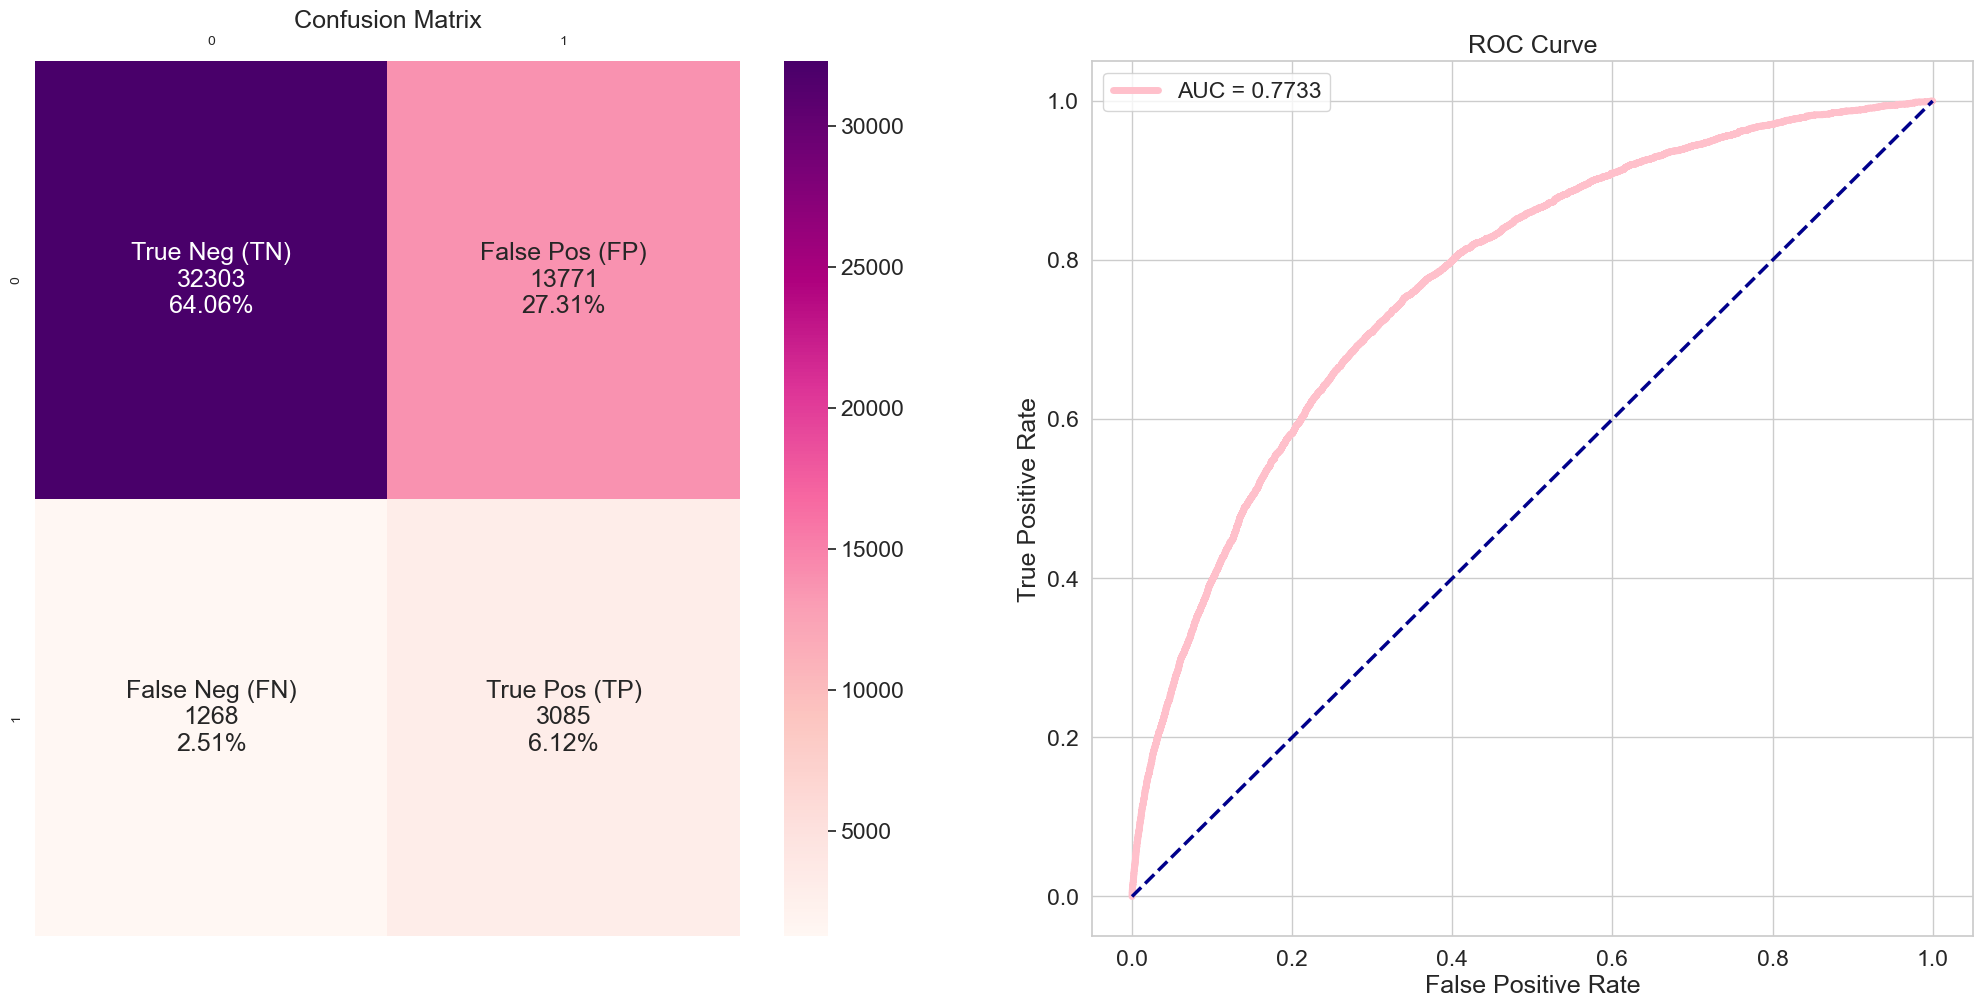

True negative =  32303
False positive =  13771
False negative =  1268
True positive =  3085
time: 563 ms (started: 2023-11-18 06:51:38 +01:00)


In [154]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [155]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.704801124949779

time: 15 ms (started: 2023-11-18 06:51:57 +01:00)


In [156]:
# Ajout des métriques du modèle 
comparison_thresh = pd.DataFrame(
        {
            "Modele": "Avant de déterminer le seuil optimal (0,50)",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[0],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle 
comparison_thresh 

Modele  Accuracy       AUC  \
0  Avant de déterminer le seuil optimal (0,50)  0.701767  0.773315   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.708707  0.290914  3085   0.183021  1268    0.704801  0.421641

time: 16 ms (started: 2023-11-18 06:52:25 +01:00)


#### 9.2 Ordre de grandeur optimal pour les coefficients de la fonction coût 

Des coefficients arbitraires ont précédemment été définis mais ceux-ci ne sont peut-être pas optimums. Le coefficient de FN est celui qui a la plus grande importance dans notre métrique mais le coefficient a-t-il le bon ordre de grandeur. Pour vérifier cela, le score gain a été recalculé avec le modèle optimal pour différents seuils de probabilité en variant l'ordre de grandeur du coefficient FN

In [157]:
# Création d'une séquence d'intervalles de seuils allant de 0 à 1 avec un pas de 0.01.
int_seuil = np.arange(0.0, 1.01, 0.01)

# Coefficients utilisés pour calculer le score en fonction des valeurs de faux positifs et faux négatifs.
coeff_fn = [1000, 100, 10]

# Initialisation de listes pour stocker les scores en fonction des seuils pour chaque coefficient.
scor_int_1000 = []
scor_int_100 = []
scor_int_10 = []

# Regroupement des listes de scores dans une liste de listes.
scor_int = [scor_int_1000, scor_int_100, scor_int_10]

# Boucle pour calculer les scores en fonction des seuils et des coefficients.
for idx, lis in enumerate(scor_int):
    for s in int_seuil:
        # Initialisation d'une liste pour stocker les étiquettes de classe en fonction du seuil 's'.
        y_seuil = []
        # Conversion des probabilités de classe en étiquettes binaires (0 ou 1) en fonction du seuil 's'.
        for i in probability_default_payment:
            if i >= s:
                y_seuil.append(1)
            elif i < s:
                y_seuil.append(0)
        
        # Calcul de la matrice de confusion en comparant les étiquettes réelles 'y_test' avec les étiquettes binaires 'y_seuil'.
        tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()

        # Calcul du score en utilisant la fonction 'score_banq' avec les valeurs de faux positifs, faux négatifs et les coefficients spécifiés.
        score = score_banq(tn, fp, fn, tp, 0, 1, coeff_fn[idx], 0)
        
        # Ajout du score calculé à la liste appropriée dans 'scor_int'.
        scor_int[idx].append(score)

time: 7.53 s (started: 2023-11-18 06:58:00 +01:00)


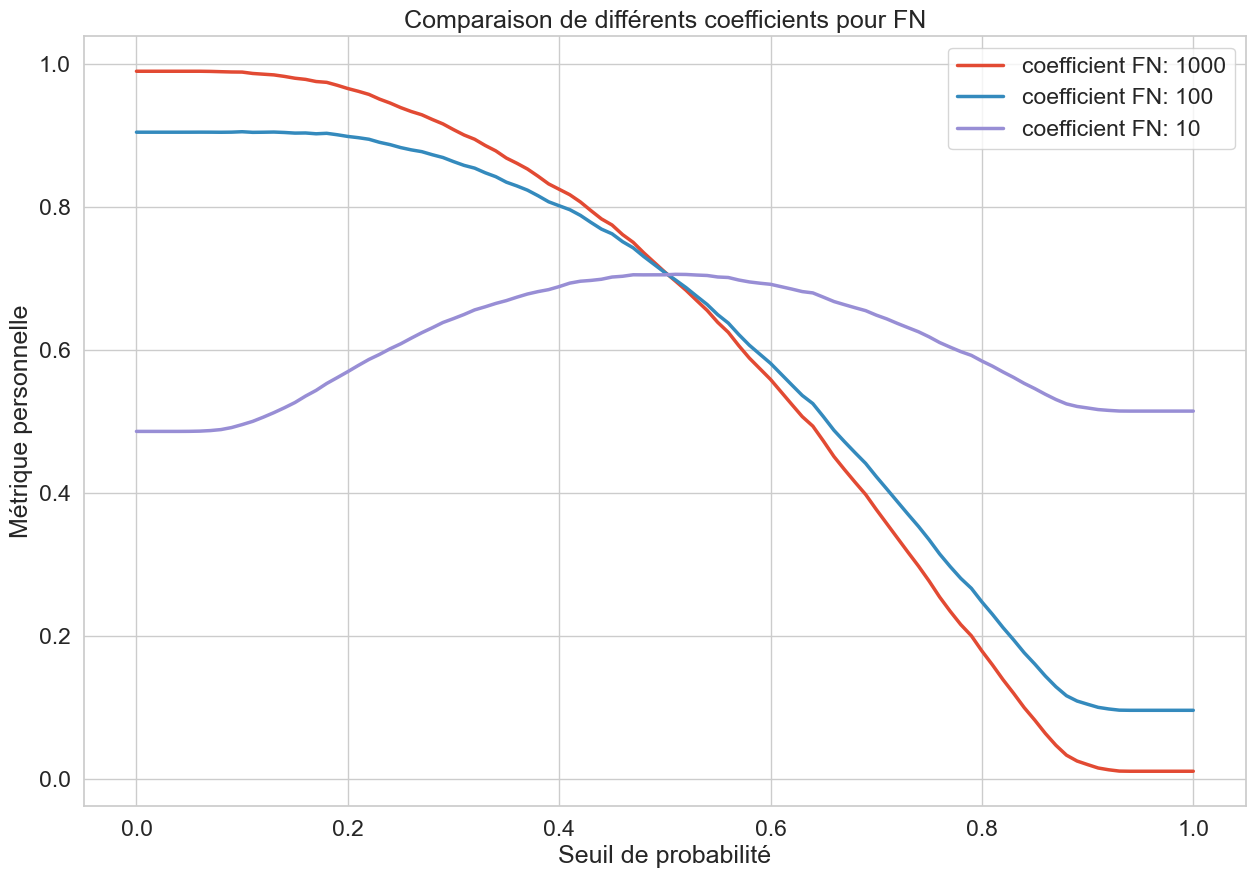

time: 297 ms (started: 2023-11-18 06:58:52 +01:00)


In [158]:
# Affichage du gain en fonction du seuil de solvabilité   

# Définition de la taille de la figure du graphique.
plt.figure(figsize=(15, 10))

# Tracé des courbes pour les scores en fonction des seuils pour chaque coefficient FN.
plt.plot(int_seuil, scor_int_1000, label="coefficient FN: 1000")
plt.plot(int_seuil, scor_int_100, label="coefficient FN: 100")
plt.plot(int_seuil, scor_int_10, label="coefficient FN: 10")

# Ajout d'étiquettes pour les axes x et y.
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métrique personnelle")

# Titre du graphique.
plt.title('Comparaison de différents coefficients pour FN')

# Ajout de la légende pour identifier chaque courbe.
plt.legend()

# Affichage du graphique.
plt.show()

Ces courbes montrent que la métrique personnelle est pertinente pour notre problématique. 
Lorque l'on donne un coefficient de 1000 pour les FN, le seuil optimal pour que la banque ait le maximum de gain d'argent se situe aux alentours d'une probabilité de 0,18 à partir de laquelle on peut voir que la courbe des gains décroit rapidement. Ce coefficient est trop strict car seuls les clients avec une probabilité de défaut de paiement < 0,18% se voient accepter leur prêt ce qui correspond à peu de personnes.


De même, lorsque l'on donne un coefficient de 100 pour les FN, on peut dire que la banque demeure rigide dans le choix des clients pour l'accord d'un prêt, car le seuil optimal pour que la banque ait le maximum de gain d'argent se situe aux alentours d'une probabilité de 0,2 et tous les clients avec une probabilité de défaut de paiement < 0,2% se verraient accepter leur prêt ce qui correspond toujours à peu de personnes.

Un coefficient de 10 pour les FN est mieux adapté, car le seuil optimal se situerait aux alentours de 0,57 ce qui est correct pour déterminer si oui ou non le prêt est accepté. 

#### 9.3 Seuil optimal pour maximiser les gains de la banque

La métrique personnelle gain doit être maximisée pour que la banque gagne le plus d'argent et ainsi permettre de déterminer à partir de quel seuil de probabilité un client est considéré comme solvable ou non. Généralement le seuil de probabilité choisi par les modèles pour classer les individus est de 0,5 mais au vu de la courbe du score gain, il ne s'agit pas du seuil optimal pour que la banque maximise ses gains.

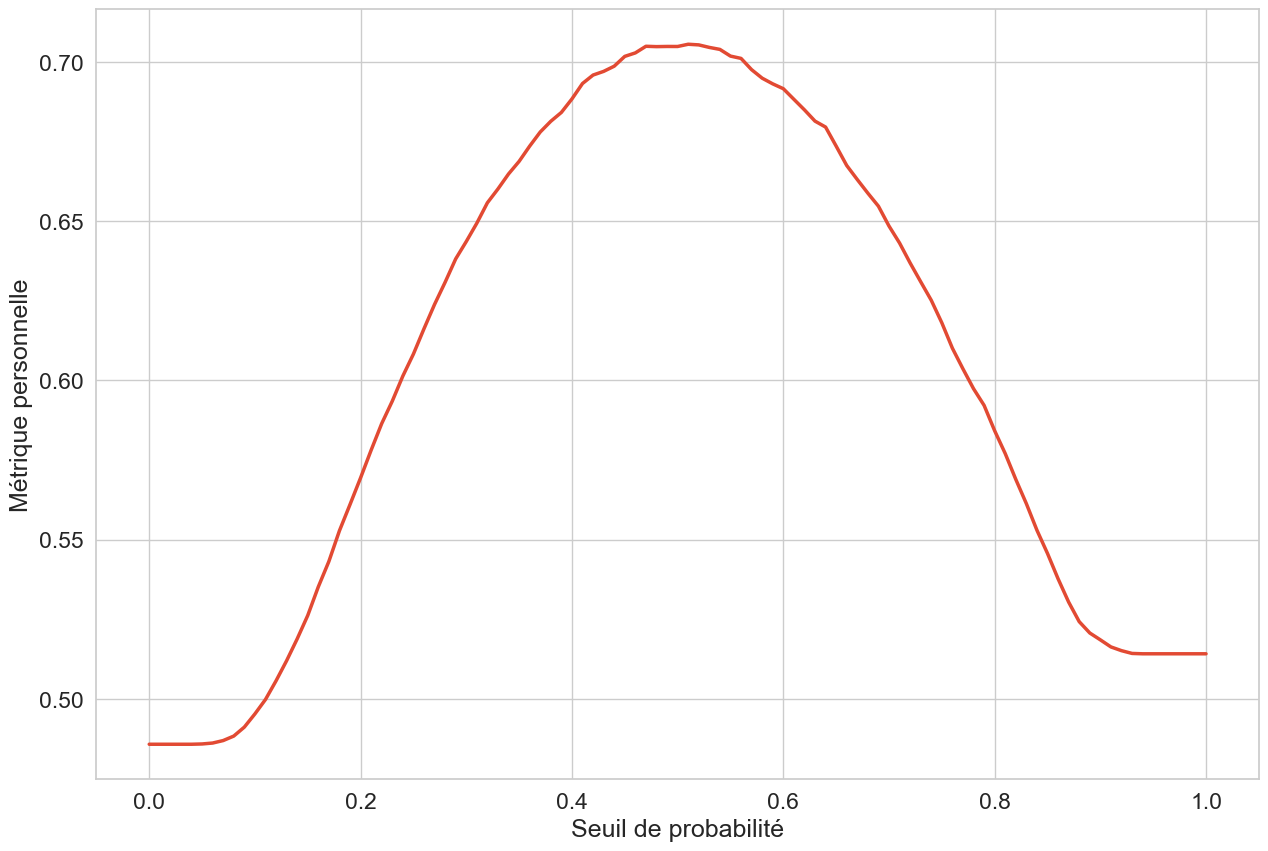

time: 2.69 s (started: 2023-11-18 07:01:02 +01:00)


In [159]:
# Initialisation d'une liste vide pour stocker les scores pour la métrique personnalisée.
scor_int = []

# Création d'une liste de seuils de probabilité de 0.0 à 1.0 avec un pas de 0.01.
int_seuil = np.arange(0.0, 1.01, 0.01)

# Boucle pour calculer les scores pour chaque seuil de probabilité.
for s in int_seuil:
    # Initialisation d'une liste pour stocker les valeurs prédites en fonction du seuil.
    y_seuil = []

    # Boucle pour prédire les valeurs en fonction des probabilités et du seuil.
    for i in probability_default_payment:
        if i >= s:
            y_seuil.append(1)
        elif i < s:
            y_seuil.append(0)

    # Calcul de la matrice de confusion à partir des valeurs prédites et réelles.
    tn, fp, fn, tp = confusion_matrix(y_test, y_seuil, labels=[0, 1]).ravel()

    # Calcul du score pour la métrique personnalisée à l'aide de la fonction score_banq().
    scor_int.append(score_banq(tn, fp, fn, tp, 0, 1, 10, 0))

# Tracé du graphique pour visualiser les scores en fonction des seuils de probabilité.
plt.figure(figsize=(15, 10))
plt.plot(int_seuil, scor_int)
plt.xlabel("Seuil de probabilité")
plt.ylabel("Métrique personnelle")
plt.show()

Nous pouvons voir sur ce graphique qu'il y a un pic maximum ce qui correspond au seuil optimal que devrait choisir la banque lors de l'accord ou non d'un prêt pour avoir le maximum de gain.

In [160]:
# Création d'un DataFrame vide avec les colonnes "int_seuil" et "scor_int".
seuil = pd.DataFrame(columns=['int_seuil', 'scor_int'])

# Attribution des valeurs des seuils de probabilité à la colonne "int_seuil".
seuil['int_seuil'] = int_seuil

# Attribution des valeurs des scores de la métrique personnalisée à la colonne "scor_int".
seuil['scor_int'] = scor_int

time: 0 ns (started: 2023-11-18 07:01:44 +01:00)


In [161]:
# Création d'un nouveau DataFrame "max" en sélectionnant les lignes de "seuil" où la colonne "scor_int" est égale à la valeur maximale de "scor_int".
max = pd.DataFrame(seuil[seuil['scor_int'] == seuil['scor_int'].max()])
max

int_seuil  scor_int
51       0.51  0.705504

time: 0 ns (started: 2023-11-18 07:01:48 +01:00)


In [162]:
# Récupération de la valeur du seuil de probabilité qui a donné le score de la métrique personnalisée le plus élevé.
seuil = max.iloc[0]['int_seuil']
seuil

0.51

time: 15 ms (started: 2023-11-18 07:02:01 +01:00)


Le seuil optimal pour que la banque fasse le maximum de gain est de 0.51

#### 9.4 Exécution seuil optimal pour la banque

In [163]:
# prédire la classe de chaque échantillon en fonction du seuil de probabilité optimal déterminé précédemment
prediction = []

# Parcours de chaque probabilité de défaut de paiement
for i in probability_default_payment:
    if i >= seuil:
        prediction.append(1)  # Si la probabilité est supérieure ou égale au seuil, prédiction de la classe 1 (défaut de paiement)
    elif i < seuil:
        prediction.append(0)  # Si la probabilité est inférieure au seuil, prédiction de la classe 0 (pas de défaut de paiement)

time: 15 ms (started: 2023-11-18 07:02:38 +01:00)


In [164]:
def test_train_col_category(dataframe_train, dataframe_test, col, size, seuil):
    '''la fonction prend en entrée deux DataFrames,
    le nom d'une colonne, une taille pour la figure et un seuil.
    La fonction calcule ensuite les valeurs 
    et les étiquettes de la colonne dans les ensembles d'entraînement 
    et de test, puis crée deux graphiques en camembert 
    pour comparer visuellement la distribution des valeurs de la colonne
    entre les deux ensembles, en tenant compte du seuil spécifié 
    pour le deuxième graphique.
    '''

    # Calculer les valeurs et les étiquettes de la colonne pour l'ensemble d'entraînement
    values_train = dataframe_train[col].value_counts()
    labels_train = dataframe_train[col].value_counts().index

    # Calculer les valeurs et les étiquettes de la colonne pour l'ensemble de test
    values_test = dataframe_test[col].value_counts()
    labels_test = dataframe_test[col].value_counts().index
    
    # Créer une nouvelle figure avec une taille spécifiée
    plt.figure(figsize=size)

    # Première sous-figure (1ère colonne de 2x2)
    plt.subplot(2, 2, 1)
    # Titre du graphique
    plt.title("Distribution of clients at threshold 0.50", fontsize=20)
    # Créer un graphique en camembert (pie chart) pour représenter la distribution des valeurs dans l'ensemble d'entraînement
    plt.pie(values_train, labels=labels_train, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    
    # Deuxième sous-figure (2ème colonne de 2x2)
    plt.subplot(2, 2, 2)
    # Titre du graphique
    plt.title("Distribution of clients at threshold {}".format(seuil), fontsize=20)
    # Créer un graphique en camembert (pie chart) pour représenter la distribution des valeurs dans l'ensemble de test avec le seuil spécifié
    plt.pie(values_test, labels=labels_test, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    # Ajuster l'aspect du graphique pour qu'il soit circulaire
    plt.axis('equal')
    plt.tight_layout()
    # Afficher la légende pour identifier les différentes catégories
    plt.legend()
    # Afficher les graphiques
    plt.show()

time: 16 ms (started: 2023-11-18 07:03:41 +01:00)


In [165]:
# Crée un DataFrame avec deux colonnes : "SK_ID_CURR" pour les identifiants des clients du jeu de test (X_test)
# et "probability_default_payment" pour stocker les prédictions binaires (0 ou 1) pour le défaut de paiement
predictive_class_51 = pd.DataFrame({
    'SK_ID_CURR': X_test.index, # La première colonne 'SK_ID_CURR' contiendra les identifiants uniques des emprunteurs dans l'ensemble de test.
    'probability_default_payment': prediction # La deuxième colonne 'probability_default_payment' contiendra les probabilités de défaut de paiement prédites par le modèle pour chaque emprunteur dans X_test.
    })

time: 16 ms (started: 2023-11-18 07:05:15 +01:00)


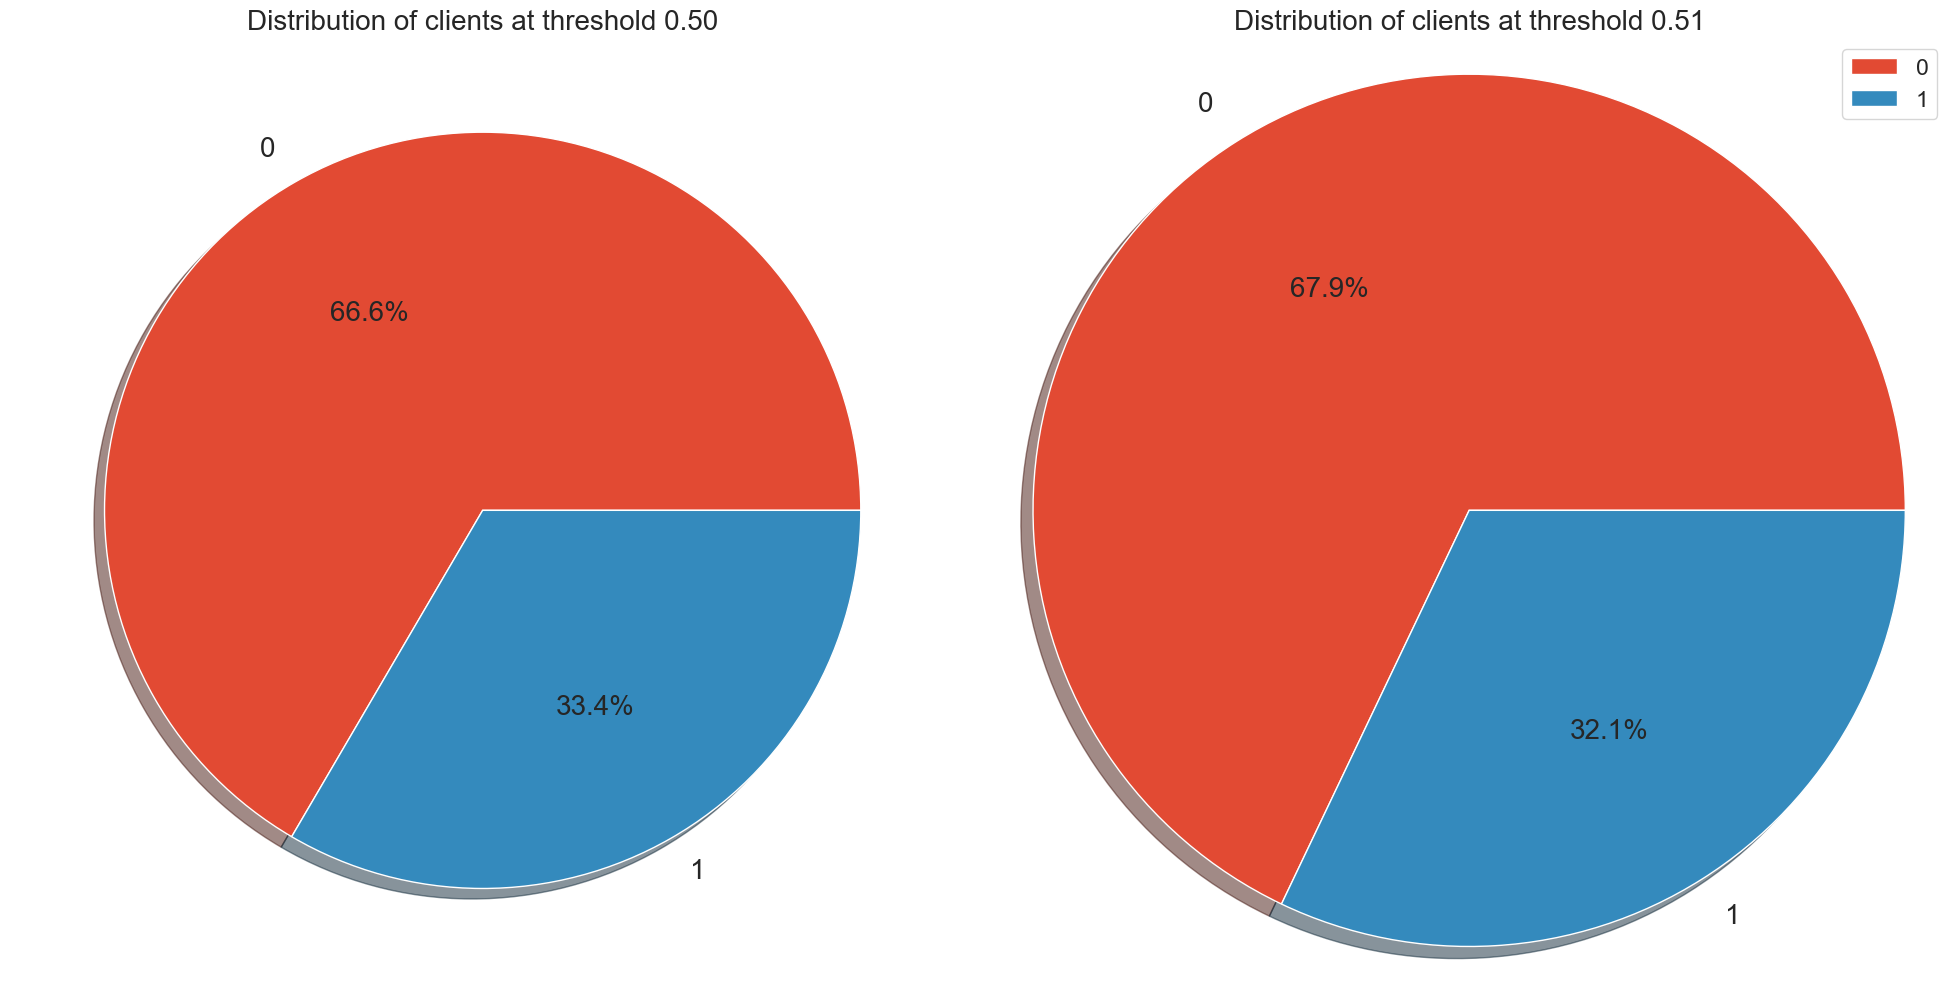

time: 375 ms (started: 2023-11-18 07:05:32 +01:00)


In [166]:
test_train_col_category(predictive_class_50, predictive_class_51, 'probability_default_payment', (20,20), seuil)

In [167]:
# Calcul de l'accuracy entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
accuracy = accuracy_score(y_test, prediction)
print(colored(f'L\'accuracy score est de {accuracy}\n', 'blue'))

# Calcul du score de précision entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
precision = precision_score(y_test, prediction, average='binary')
print(colored(f'Le score de précision est de {precision}\n', 'blue'))

# Calcul du score recall entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
recall = recall_score(y_test, prediction, average='binary')
print(colored(f'Le score recall est de {recall}\n', 'blue'))

# Calcul de l'AUC (Area Under the Curve) entre les vraies étiquettes (y_test) et les probabilités de défaut de paiement (probability_default_payment)
AUC = roc_auc_score(y_test, probability_default_payment)       
print(colored(f'Le score AUC est de {AUC} \n', 'blue'))

# Calcul du score f1 entre les vraies étiquettes (y_test) et les prédictions binaires du modèle (prediction)
f1 = f1_score(y_test, prediction, average='binary')
print(colored(f'Le score f1 est de {f1}\n', 'blue'))

L'accuracy score est de 0.7130108870248082

Le score de précision est de 0.18724114483525994

Le score recall est de 0.6958419480817827

Le score AUC est de 0.7733147918607669 

Le score f1 est de 0.2950803701899659

time: 109 ms (started: 2023-11-18 07:06:56 +01:00)


In [168]:
# "y_test" contient les vraies étiquettes de la classe cible
# "prediction" contient les étiquettes prédites par le modèle
df_matrice_confusion = matrix_TN_FN(y_test, prediction)

# Affichage de la matrice de confusion
print("Matrice de confusion :")
df_matrice_confusion

Matrice de confusion :


Predicted Negative (0) Predicted Positive (1)
Real Negative (0)             32926 (TN)             13148 (FP)
Real Positive (1)              1324 (FN)              3029 (TP)

time: 16 ms (started: 2023-11-18 07:07:26 +01:00)


In [169]:
# Calcul de l'AUC (Area Under the Curve) en utilisant les étiquettes réelles 'y_test' et les probabilités de classe positive 'probability_default_payment'.
roc_auc = roc_auc_score(y_test, probability_default_payment)

# Affichage du résultat de l'AUC 
print('AUC : %0.4f' % roc_auc)

# Calcul du rapport de classification en comparant les étiquettes réelles 'y_test' et les prédictions 'prediction'.
# La fonction 'classification_report' produit un rapport complet incluant les métriques de précision, rappel, F1-score et le support pour chaque classe.
report = classification_report(y_test, prediction)

# Affichage du rapport de classification.
print(report)

AUC : 0.7733
              precision    recall  f1-score   support

           0       0.96      0.71      0.82     46074
           1       0.19      0.70      0.30      4353

    accuracy                           0.71     50427
   macro avg       0.57      0.71      0.56     50427
weighted avg       0.89      0.71      0.77     50427

time: 78 ms (started: 2023-11-18 07:08:27 +01:00)


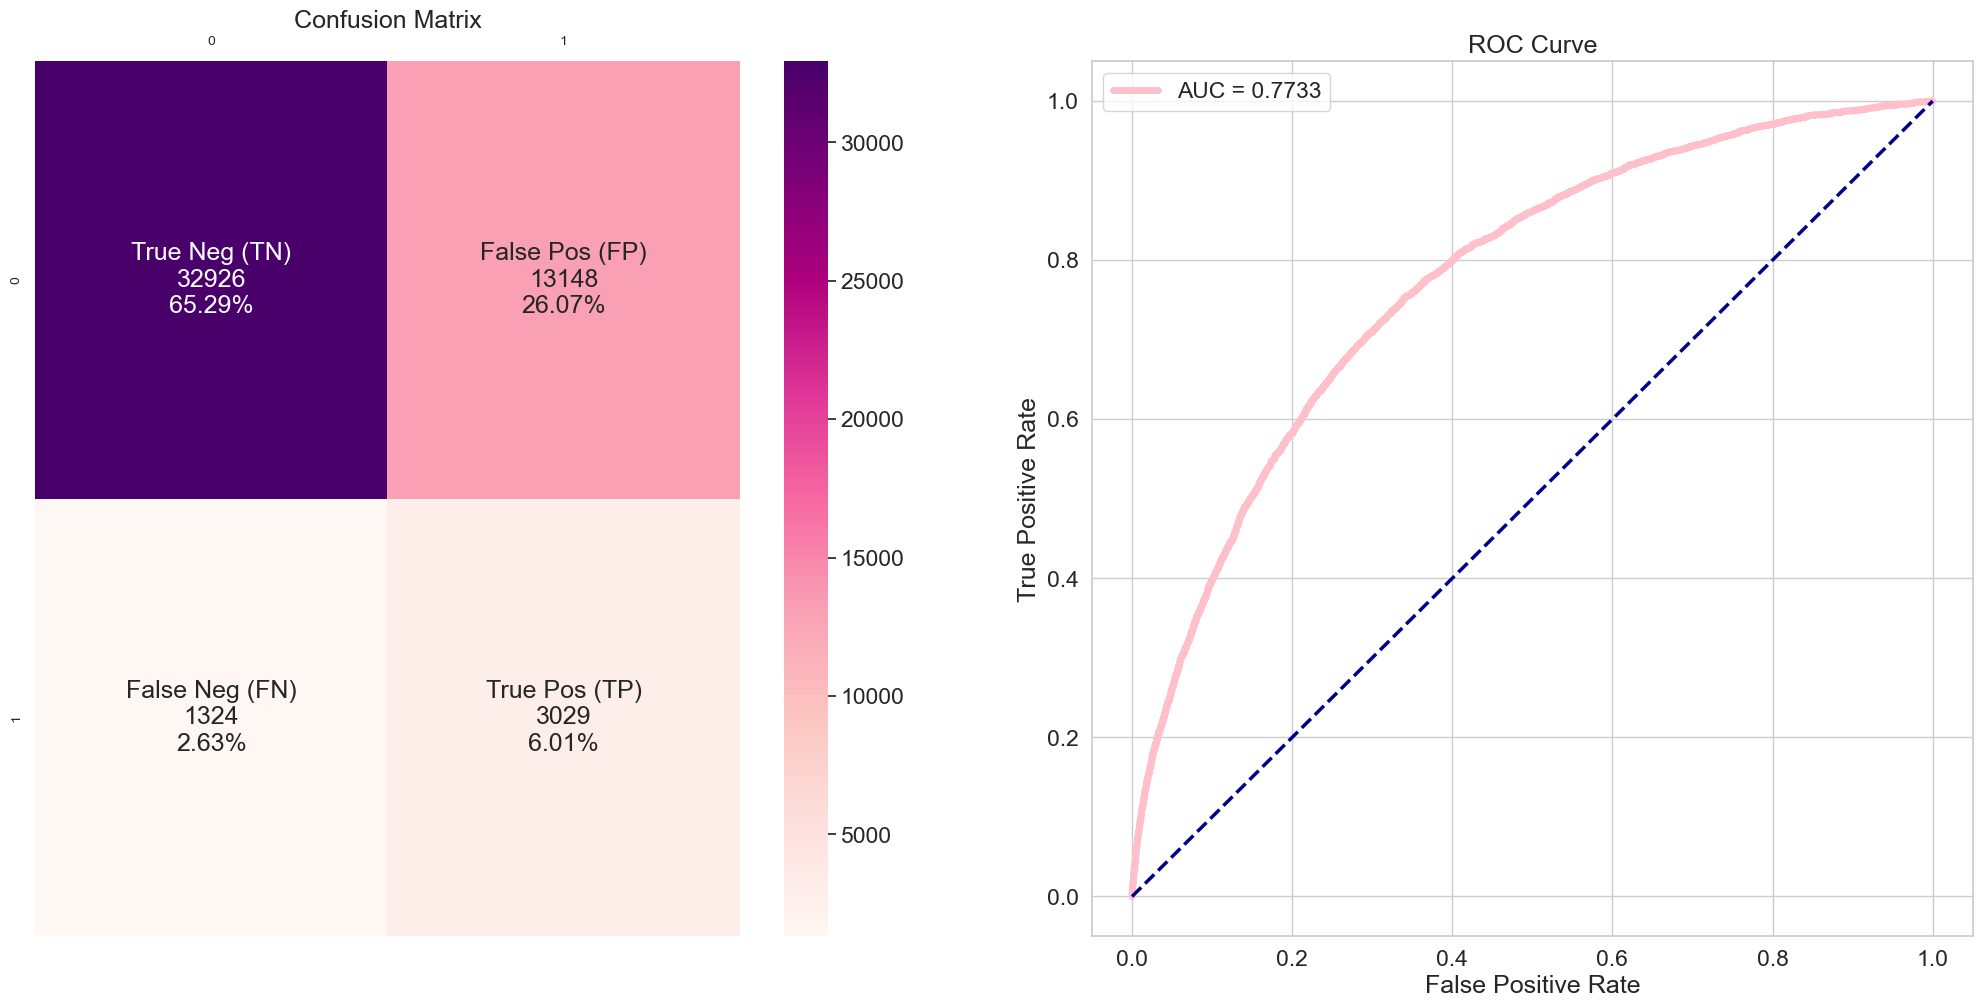

True negative =  32926
False positive =  13148
False negative =  1324
True positive =  3029
time: 563 ms (started: 2023-11-18 07:08:46 +01:00)


In [170]:
# Appliquer la fonction "cf_matrix_roc_auc" pour calculer les valeurs des vrais négatifs (TN), faux positifs (FP), faux négatifs (FN) et vrais positifs (TP)
# Les paramètres passés à la fonction sont :
# - "y_test" : les vraies étiquettes de la classe cible
# - "prediction" : les étiquettes prédites par le modèle
# - "probability" : les probabilités de la classe positive prédites par le modèle
# - (25, 25) : la taille de la figure pour afficher la matrice de confusion et la courbe ROC
tn, fp, fn, tp = cf_matrix_roc_auc(y_test, prediction, probability, (25, 25))

In [171]:
# Appel de la fonction "score_banq" pour calculer le score de gain
# Les paramètres passés à la fonction sont :
# - tn : le nombre de vrais négatifs (True Negatives)
# - fp : le nombre de faux positifs (False Positives)
# - fn : le nombre de faux négatifs (False Negatives)
# - tp : le nombre de vrais positifs (True Positives)
# - 0 : le gain pour un vrai positif (True Positive Gain)
# - 1 : le coût pour un faux positif (False Positive Cost)
# - 10 : le coût pour un faux négatif (False Negative Cost)
# - 0 : le coût pour un vrai négatif (True Negative Cost)
score_gain = score_banq(tn, fp, fn, tp, 0, 1, 10, 0)
score_gain

0.7055042185616713

time: 0 ns (started: 2023-11-18 07:09:06 +01:00)


In [172]:
# Ajout des métriques du modèle 
comparison_thresh_51 = pd.DataFrame(
        {
            "Modele": "Après détermination du seuil optimal (0,51)",
            "Accuracy": accuracy,            # Précision globale du modèle (TP + TN) / (TP + TN + FP + FN)
            "AUC": AUC,                      # Aire sous la courbe ROC du modèle
            "Recall class 1": recall,        # Rappel (recall) de la classe 1 (défaut de paiement) du modèle
            "F1": f1,                        # Score F1, mesure harmonique entre la précision et le rappel
            "TP": tp,                        # Nombre de vrais positifs du modèle (prédictions correctes de la classe 1)
            "Precision": precision,          # Précision du modèle TP / (TP + FP)
            "FN": fn,                        # Nombre de faux négatifs du modèle (prédictions erronées de la classe 1)
            "score Gain": score_gain,        # Score Gain calculé à partir des coûts spécifiés
            "time": prediction_time          # Temps de prédiction pour le modèle
        },
        index=[1],                          # Utilisation de l'index 0 pour ajouter une seule ligne au DataFrame
    )

# Affichage du DataFrame contenant les métriques de performance du modèle 
comparison_thresh = pd.concat([comparison_thresh,comparison_thresh_51])
comparison_thresh

Modele  Accuracy       AUC  \
0  Avant de déterminer le seuil optimal (0,50)  0.701767  0.773315   
1  Après détermination du seuil optimal (0,51)  0.713011  0.773315   

   Recall class 1        F1    TP  Precision    FN  score Gain      time  
0        0.708707  0.290914  3085   0.183021  1268    0.704801  0.421641  
1        0.695842  0.295080  3029   0.187241  1324    0.705504  0.421641

time: 16 ms (started: 2023-11-18 07:10:00 +01:00)


In [173]:
# Création d'un nouveau DataFrame en concaténant X_test et y_test le long de l'axe des colonnes (axis=1).
comparison_percentage = pd.concat([X_test, y_test], axis=1)

# Ajout d'une colonne appelée 'PREDICTION' au DataFrame "comparison_percentage" pour y stocker les prédictions du modèle "prediction".
comparison_percentage['PREDICTION'] = prediction

time: 62 ms (started: 2023-11-18 07:11:10 +01:00)


In [174]:
comparison_percentage

CODE_GENDER  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
SK_ID_CURR                                                             
272844                0             1                1             2   
262199                1             0                1             0   
236291                0             0                0             0   
399708                1             0                0             0   
151614                0             1                1             2   
...                 ...           ...              ...           ...   
125398                1             0                0             0   
151094                1             1                0             3   
287568                1             0                1             0   
214293                0             0                1             1   
387840                1             0                0             0   

            AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
SK_ID_CURR                                                               
272844              2.542926    1.910623     6.960604         2.160389   
262199             -0.143946    1.046797     0.179711         0.953800   
236291              0.014106   -0.730169    -0.438019        -0.868148   
399708             -0.381022   -0.916302    -0.374986        -0.831951   
151614              0.330208    0.790210     1.360441         0.579758   
...                      ...         ...          ...              ...   
125398             -0.270387   -1.100929    -1.206109        -1.109466   
151094             -0.096530    1.589853     0.620332         0.941734   
287568              0.172157    0.887863     4.741509         0.941734   
214293             -0.333607   -0.797620    -1.163676        -0.807819   
387840             -0.143946   -0.838747    -1.011165        -0.747490   

            REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  \
SK_ID_CURR                                                          
272844                        3.729748      -17393          -5577   
262199                       -0.817592      -16092          -1939   
236291                        0.270219      -19521           -892   
399708                       -0.895236      -20399         -10999   
151614                        3.729748      -11681           -445   
...                                ...         ...            ...   
125398                       -1.140085      -21365          -1781   
151094                        0.714054      -13722          -3406   
287568                       -0.011249      -10647           -675   
214293                       -0.462596      -17719          -1033   
387840                       -0.127679      -20982          -5161   

            DAYS_REGISTRATION  DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  \
SK_ID_CURR                                                                   
272844               0.834671             -919           1               1   
262199               0.899861            -3980           1               1   
236291               0.079142            -2884           1               1   
399708              -1.196371            -3878           1               1   
151614              -0.323069            -4244           1               1   
...                       ...              ...         ...             ...   
125398              -1.393479            -2709           1               1   
151094               0.775631            -4116           1               1   
287568              -0.107819            -3287           1               1   
214293               0.129879            -1269           1               1   
387840               0.404170            -4475           1               1   

            FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  \
SK_ID_CURR                                                              
272844                    0                 1        

time: 156 ms (started: 2023-11-18 07:11:15 +01:00)


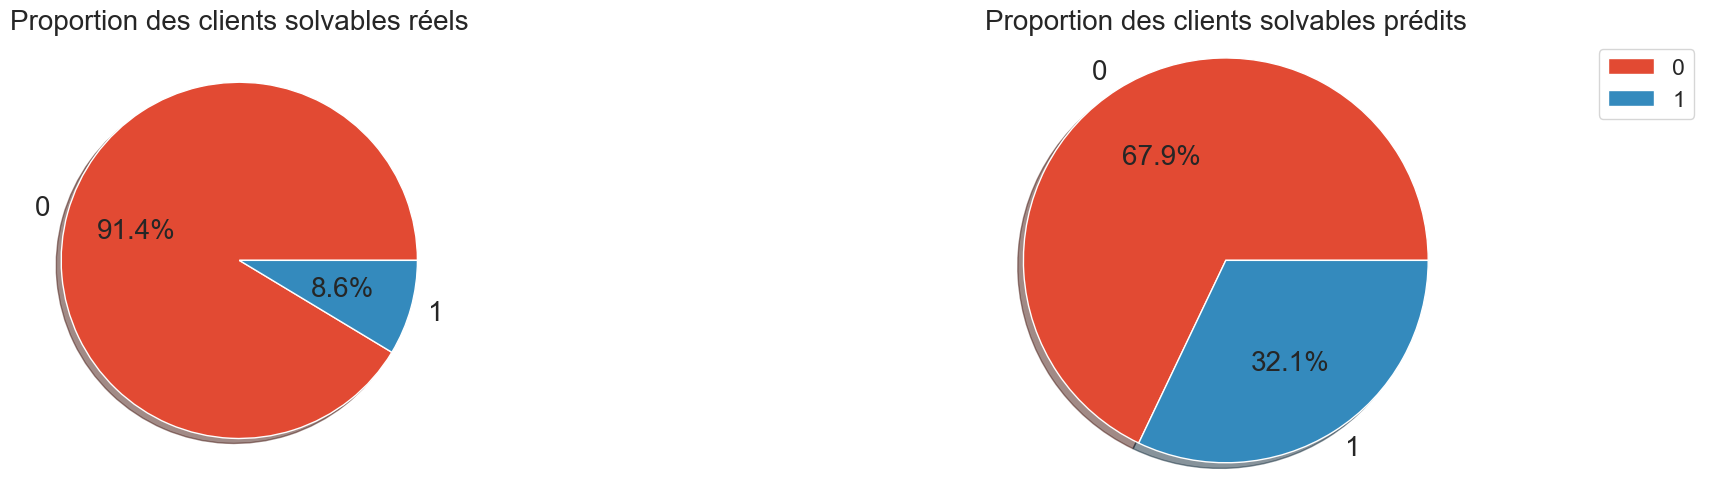

time: 313 ms (started: 2023-11-18 07:12:47 +01:00)


In [175]:
# Compter le nombre de clients solvables (0) et de clients insolvable (1) dans les données réelles (y_test) et stocker les valeurs et les étiquettes.
values_train = comparison_percentage["TARGET"].value_counts()
labels_train = comparison_percentage["TARGET"].value_counts().index

# Compter le nombre de clients solvables (0) et de clients insolvable (1) dans les prédictions du modèle (prediction) et stocker les valeurs et les étiquettes.
values_test = comparison_percentage["PREDICTION"].value_counts()
labels_test = comparison_percentage["PREDICTION"].value_counts().index
    
# Créer une figure de taille (20, 10) pour afficher les deux graphiques côte à côte.
plt.figure(figsize=(20,10))
    
# Sous-plot 1: Afficher un graphique circulaire (pie chart) de la proportion des clients solvables dans les données réelles.
plt.subplot(2, 2, 1)
plt.title("Proportion des clients solvables réels", fontsize=20)
plt.pie(values_train, labels=labels_train, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
    
# Sous-plot 2: Afficher un graphique circulaire (pie chart) de la proportion des clients solvables prédits par le modèle.
plt.subplot(2, 2, 2)
plt.title("Proportion des clients solvables prédits", fontsize=20)
plt.pie(values_test, labels=labels_test, autopct='%.1f%%', shadow=True, textprops={'fontsize': 20})
plt.axis('equal')  # Pour que le graphique soit un cercle complet (un aspect équilibré).
plt.tight_layout()  # Pour éviter que les labels se chevauchent.
plt.legend()  # Ajouter une légende pour indiquer la signification des couleurs.
plt.show()  # Afficher les deux graphiques.

il y a plus de personnes catégorisées comme personnes ne pouvant pas payer leur prêt comparé à la réalité. Le fait qu'il y ait plus de personnes prédites comme des non payeurs n'est pas grave car la banque ne perd pas d'argent.

#### 9.5 Importance des features 

##### 9.5.1 Features importance simple

### Interprétation Globale.

In [176]:
Coefficient_light = best_model.booster_.feature_importance(importance_type='gain')

time: 16 ms (started: 2023-11-18 07:14:23 +01:00)


In [177]:
# Calculer l'importance des fonctionnalités en utilisant les gains (type='gain') du modèle LightGBM.
feature_imp = pd.DataFrame(sorted(zip(best_model.booster_.feature_importance(importance_type='gain'), X_train_undersampled.columns)), columns=['Value', 'Feature'])
# Visualisation
feature_imp

Value                          Feature
0         0.000000        AMT_REQ_CREDIT_BUREAU_DAY
1         0.000000       AMT_REQ_CREDIT_BUREAU_WEEK
2         0.000000      BURO_CNT_CREDIT_PROLONG_SUM
3         0.000000  BURO_CREDIT_ACTIVE_Baddebt_MEAN
4         0.000000      BURO_CREDIT_ACTIVE_nan_MEAN
..             ...                              ...
514   13403.467035                    DAYS_EMPLOYED
515   27410.467050                     PAYMENT_RATE
516   37472.264375                     EXT_SOURCE_1
517  116653.899444                     EXT_SOURCE_3
518  125668.798350                     EXT_SOURCE_2

[519 rows x 2 columns]

time: 16 ms (started: 2023-11-18 07:14:27 +01:00)


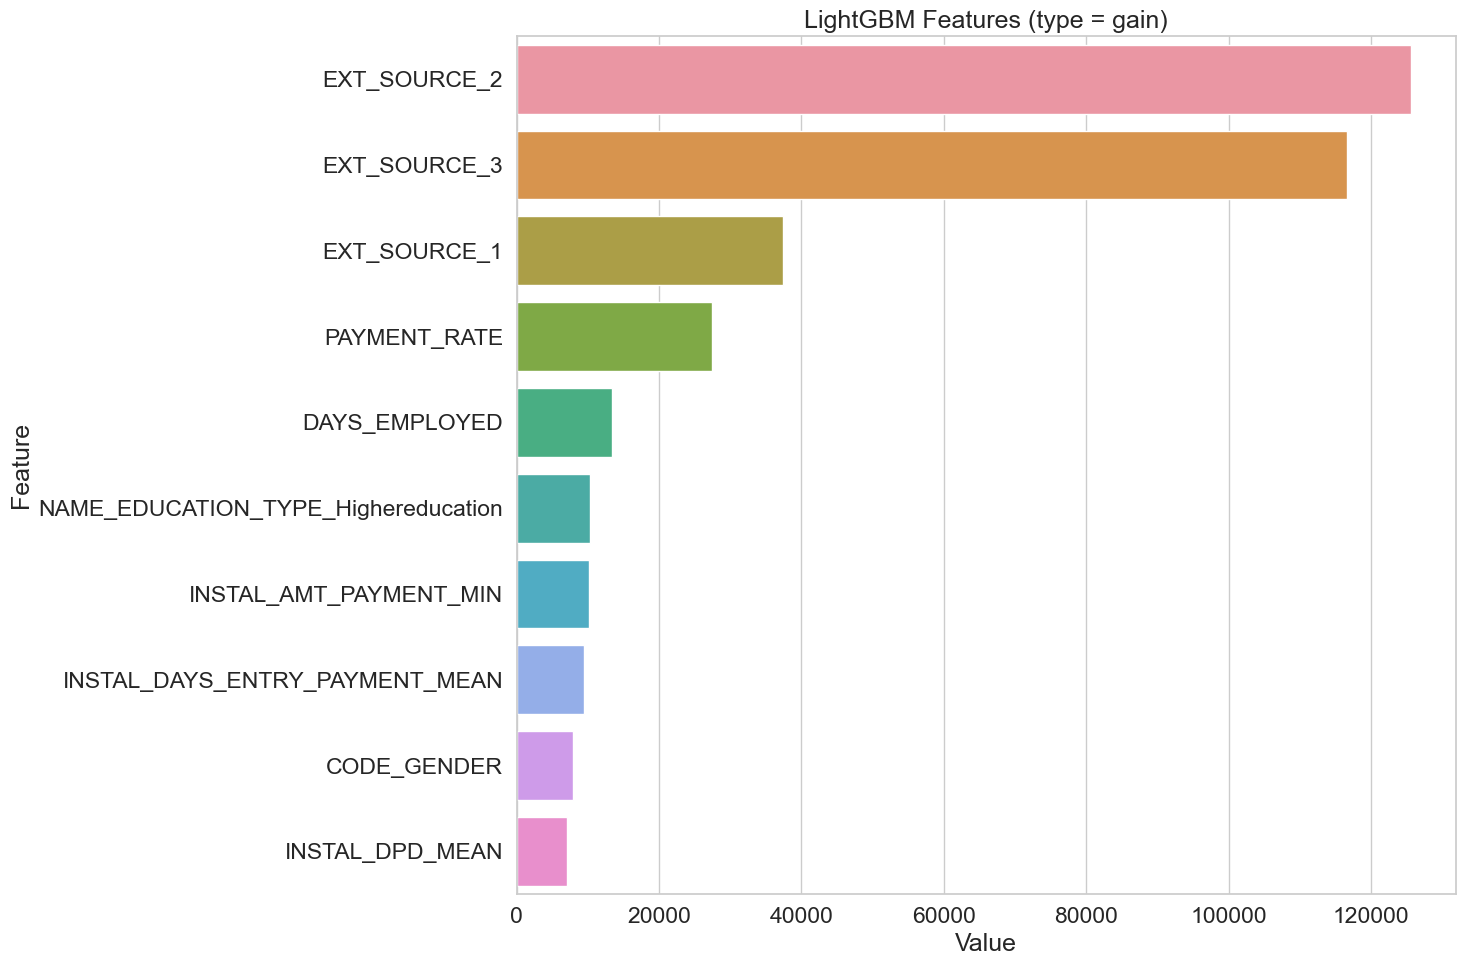

time: 375 ms (started: 2023-11-18 07:14:42 +01:00)


In [178]:
# Créer une figure pour afficher le graphique des fonctionnalités les plus importantes.
plt.figure(figsize=(15, 10))

# Tracer un graphique à barres (barplot) pour afficher les 5 fonctionnalités les plus importantes.
# Les fonctionnalités sont triées par ordre décroissant en fonction de leurs valeurs d'importance (gains).
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(10))

# Ajouter un titre au graphique.
plt.title('LightGBM Features (type = gain)')

# Ajuster la disposition du graphique pour qu'il soit bien affiché.
plt.tight_layout()

# Afficher le graphique des fonctionnalités les plus importantes.
plt.show()

In [179]:
import shap

time: 0 ns (started: 2023-11-18 07:15:37 +01:00)


In [180]:
shap.initjs()

time: 16 ms (started: 2023-11-18 07:15:39 +01:00)


Avec cette représentation, on peut dire que les features les plus importantes pour la prédiction d'accord d'un prêt sont les sources extérieures 2 et 3 qui sont les scores normalisés créés à partir d'une source de données externe. Ces scores pourraient regrouper différentes caractéristiques sur le paiement d'un crédit tel que le retard de paiement par exemple. Plus ces scores sont élevés et plus le client risque de ne pas voir sa demande de prêt accepté.
Puis on trouve la durée que met un client à rembourser un prêt. Plus le temps de remboursement des crédits est grand plus il y a de chance que le prêt ne lui soit pas accordé. Puis il y a la source externe 1. 
Le nombre de jours depuis la naissance des clients donc leur âge joue un rôle important dans l'acceptation d'un crédit. Comme nous l'avons vu lors du préprocessing, les clients jeunes ont plus de mal à rembourser leur prêt. 

##### 9.5.2 Features importance SHAP

Les valeurs de Shapley calculent l’importance d’une variable en comparant la sortie qu’un modèle peut prédire avec et sans cette variable. Cependant, étant donné que l’ordre dans lequel un modèle voit les variables peut affecter ses prédictions, cela se fait dans tous les ordres possibles, afin que les fonctionnalités soient comparées équitablement. Cette approche est inspirée de la théorie des jeux.

SHAP s’utilise pour expliquer un modèle existant. Prenant un cas de classification binaire construite avec un modèle sklearn. On entraine
et teste notre modèle. Ensuite on peut utiliser nos données et le modèle pour créer un modèle supplémentaire de SHAP qui explique notre modèle de classification.

Les valeurs Shap sont des tableaux d'une longueur correspondant au nombre de classes dans la cible. Ici, le problème est la classification binaire, et donc les valeurs Shap ont deux tableaux correspondant à l'une ou l'autre classe.

Les valeurs Shap sont des nombres à virgule flottante correspondant aux données de chaque ligne correspondant à chaque caractéristique. La valeur Shap représente la contribution de ce point de données particulier dans la prédiction des sorties. Si la valeur shap est très proche de zéro, on peut dire que le point de données contribue très peu aux prédictions. Si la valeur shap est une valeur fortement positive ou fortement négative, nous pouvons dire que le point de données contribue grandement à la prédiction de la classe positive ou négative.



In [181]:
# Modèle optimal.
shap_model = best_model.booster_

explainer = shap.TreeExplainer(shap_model)

shap_values = explainer.shap_values(X_test.iloc[:10000, :])

time: 14.7 s (started: 2023-11-18 07:21:36 +01:00)


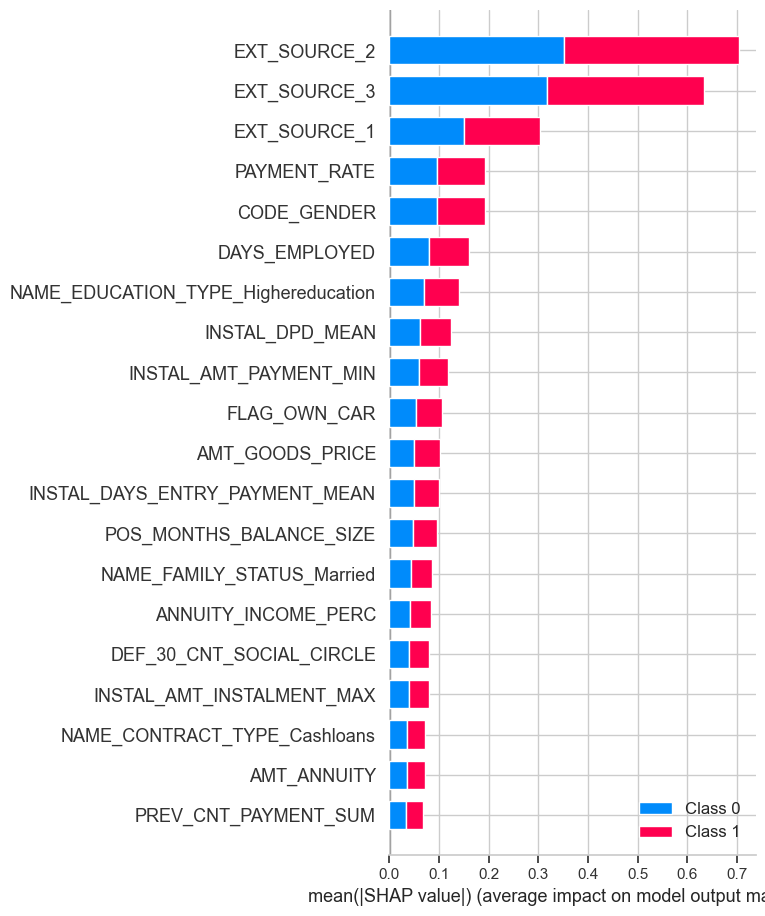

time: 531 ms (started: 2023-11-18 07:22:04 +01:00)


In [182]:
# Features par odre d'importance.
shap.summary_plot(shap_values, X_test.iloc[:10000, :])

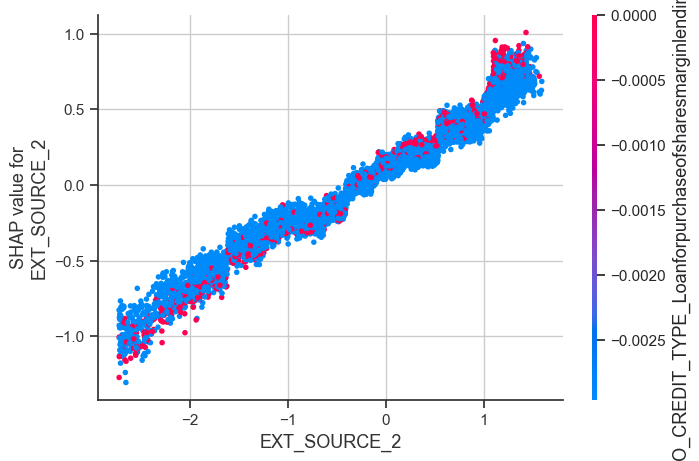

time: 14.3 s (started: 2023-11-18 07:22:50 +01:00)


In [183]:
# # Vérifications des Features.
shap.dependence_plot("EXT_SOURCE_2", shap_values[0], X_test.iloc[:10000, :])

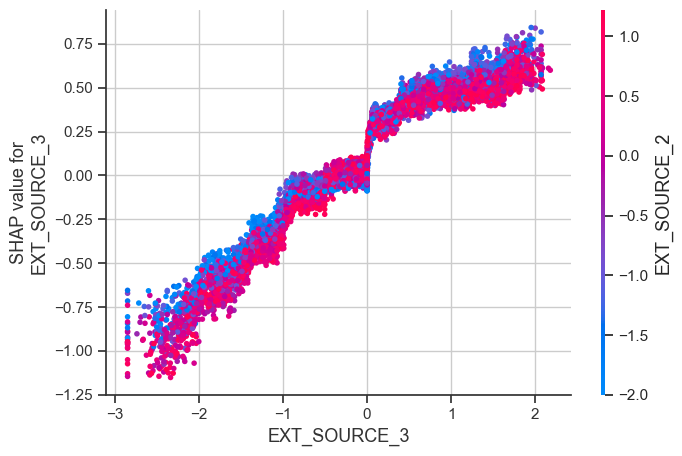

time: 14 s (started: 2023-11-18 07:23:31 +01:00)


In [184]:
# # Vérifications des Features.
shap.dependence_plot("EXT_SOURCE_3", shap_values[0], X_test.iloc[:10000, :])

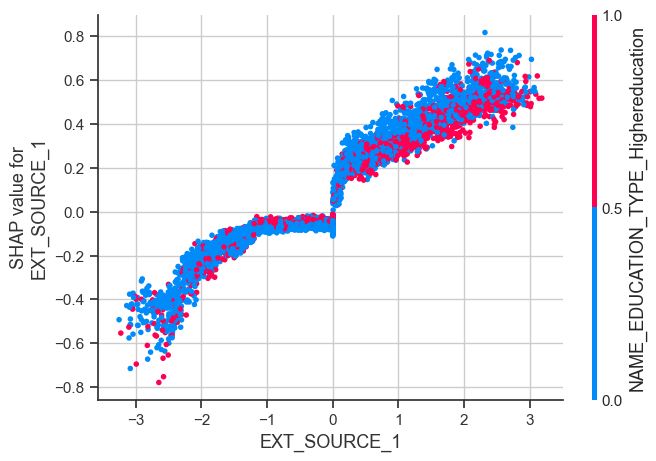

time: 14.1 s (started: 2023-11-18 07:24:44 +01:00)


In [185]:
# # Vérifications des Features.
shap.dependence_plot("EXT_SOURCE_1", shap_values[0], X_test.iloc[:10000, :])

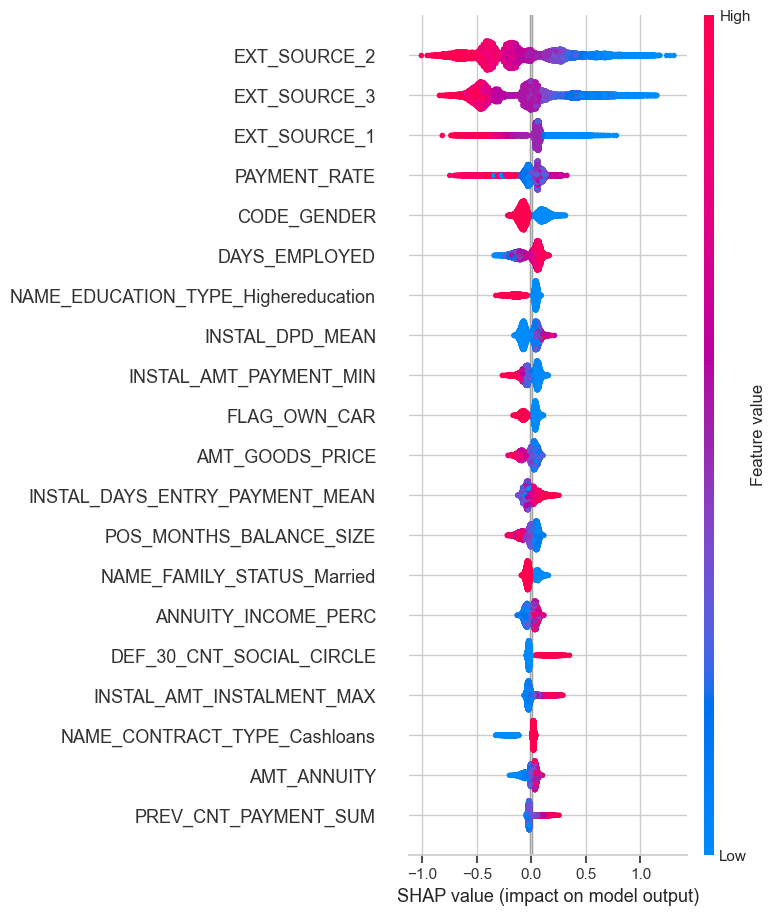

time: 1.86 s (started: 2023-11-18 07:25:24 +01:00)


In [186]:
# Mes vérifications à MOI TOUT SEUL.
shap.summary_plot(shap_values[1], X_test.astype("float").iloc[:10000,:])

### Interprétation Locale.

In [187]:
# # Vérifications des Features locales.
import random

time: 0 ns (started: 2023-11-18 07:26:18 +01:00)


In [188]:
shap.initjs()
# Mes vérifications à MOI TOUT SEUL.
idx = random.randint(1, len(X_test.iloc[:10000, :]))
print("Client numero : ", X_test.iloc[:10000, :].iloc[idx,0])

shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], X_test.iloc[:10000, :].iloc[idx,:])

Client numero :  0


time: 16 ms (started: 2023-11-18 07:26:25 +01:00)


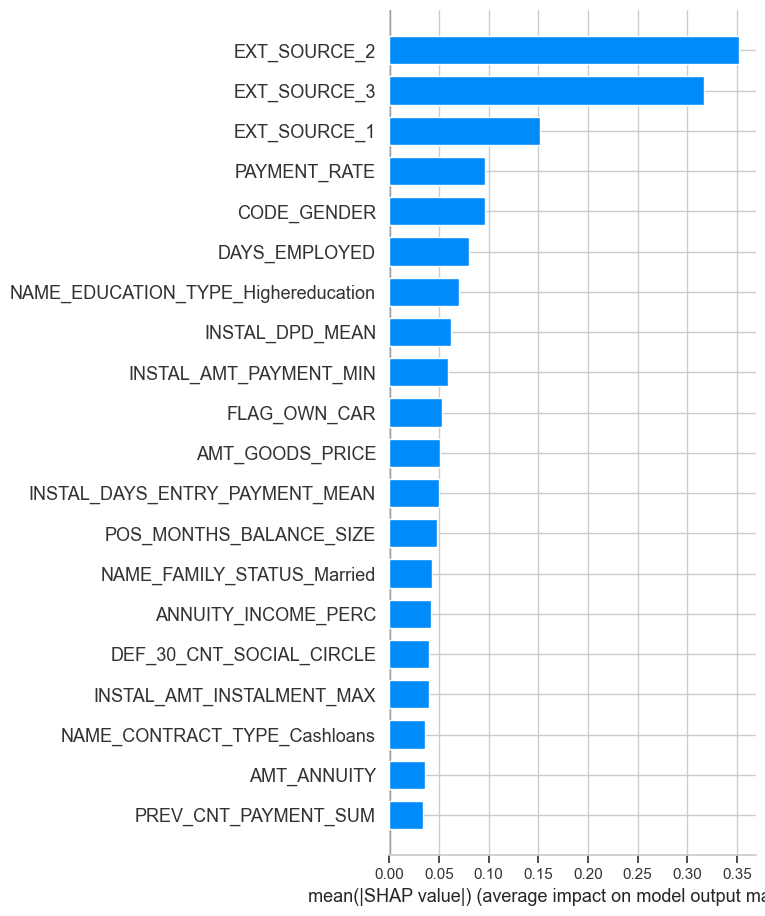

time: 328 ms (started: 2023-11-18 07:26:41 +01:00)


In [189]:
# # Vérifications des Features.
shap.summary_plot(shap_values[0], X_test.iloc[:10000, :], plot_type="bar")

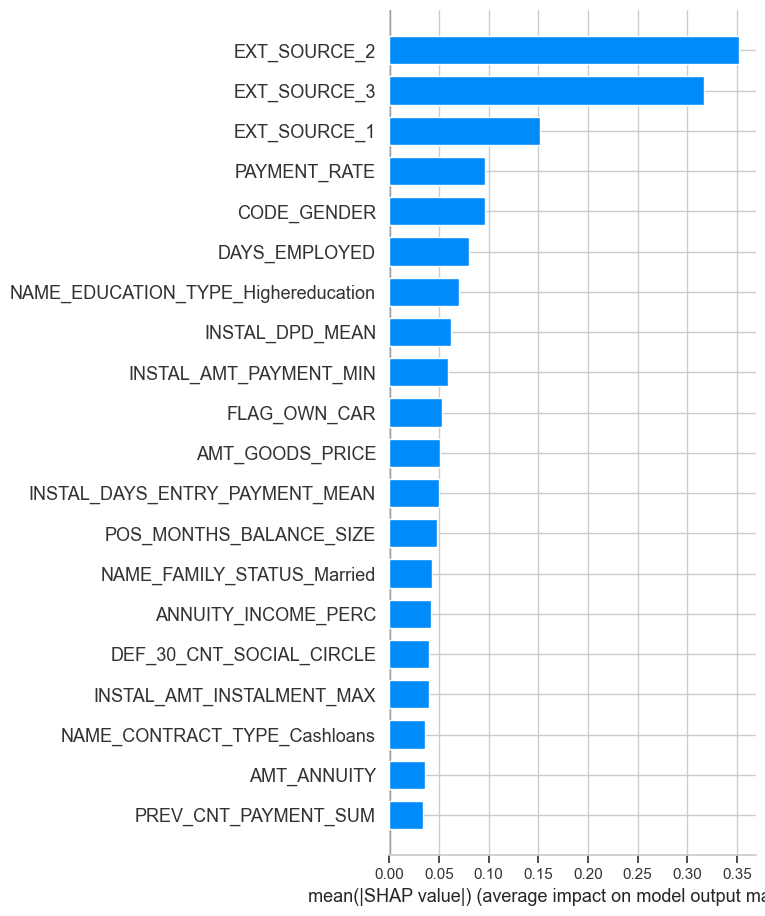

time: 313 ms (started: 2023-11-18 07:26:58 +01:00)


In [190]:
# Vérifications des Features.
shap.summary_plot(shap_values[1], X_test.iloc[:10000, :], plot_type="bar")

### Explication sur le Force Plot  
https://coderzcolumn.com/tutorials/machine-learning/shap-explain-machine-learning-model-predictions-using-game-theoretic-approach#classification

Pour le client identifié n°63: probabilité pour rembourser son crédit: 59% et 41% de ne pas le rembourser.

In [191]:
shap.initjs()
i = 63
display(shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_test.iloc[:10000, :].values[i], feature_names = X_test.iloc[:10000, :].columns, link='logit'))
display(shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_test.iloc[:10000, :].values[i], feature_names = X_test.iloc[:10000, :].columns, link='logit'))

time: 46 ms (started: 2023-11-18 07:28:21 +01:00)


Pour le client identifié n°62: probabilité pour rembourser son crédit: 44% et 56% de ne pas le rembourser.

In [192]:
shap.initjs()
# i = 62 ==> Pr_sol = 0.90 et Pr_insol = 0.10; i = 147 ==> Pr_sol = 0.91 et Pr_insol = 0.09;
i = 62
display(shap.force_plot(explainer.expected_value[0], shap_values[0][i], X_test.iloc[:10000, :].values[i], feature_names = X_test.iloc[:10000, :].columns, link='logit'))
display(shap.force_plot(explainer.expected_value[1], shap_values[1][i], X_test.iloc[:10000, :].values[i], feature_names = X_test.iloc[:10000, :].columns, link='logit'))

time: 32 ms (started: 2023-11-18 07:29:13 +01:00)
